# Attempt classification on 5 differe orgs

In [2]:
import torch
from torch import nn

import altair as alt
import copy
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import random
import seaborn as sns
import scipy
from scipy.stats import pearsonr, spearmanr
from sklearn.metrics import r2_score
from sklearn.metrics import confusion_matrix,ConfusionMatrixDisplay,classification_report

import time


import models as m
import utils as u
import torch_utils as tu
from torch_utils import DatasetSpec

In [3]:
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
DEVICE

device(type='cuda')

# Load 5org data

In [4]:
train_df = pd.read_csv(f'data/5org_cls_splits/cv0_train.tsv',sep='\t').fillna("")
test_df = pd.read_csv(f'data/5org_cls_splits/cv0_test.tsv',sep='\t').fillna("")

In [5]:
test_df

locus_tag  gene                                         product  \
0      EQU24_RS00005  dnaA  chromosomal replication initiator protein DnaA   
1      EQU24_RS00010  dnaN                 DNA polymerase III subunit beta   
2      EQU24_RS00015  recF             DNA replication/repair protein RecF   
3      EQU24_RS00020  gyrB   DNA topoisomerase (ATP-hydrolyzing) subunit B   
4      EQU24_RS00035                                  hypothetical protein   
...              ...   ...                                             ...   
3845  CAETHG_RS04070                     DUF4317 domain-containing protein   
3846  CAETHG_RS04075                                     HesB-like protein   
3847  CAETHG_RS04080  thiI             tRNA 4-thiouridine(8) synthase ThiI   
3848  CAETHG_RS04085                   cysteine desulfurase family protein   
3849  CAETHG_RS04090             polysaccharide deacetylase family protein   

                                        upstream_region    org  id   set  
0     ACTGTTAGCTTGGCACGGCCCTTGGCTCTGCGGGCGTTAAGGACTT...     5G   0  test  
1     GTGGACGCGATCACACCACGGTTATTAATGCTTGTAAACGCATTGC...     5G   0  test  
2     TTGCGAAGAGGGGCGGTTTCTCGTCCGACAGGCGTCGGCGGCAAGG...     5G   0  test  
3     ATTGTTAGTTCTATGTTTAAAGCTTGCGCAAGTACAATTATTGTCG...     5G   0  test  
4     GTATAAACCATGAAAGTCAGCCTATTTCGAAGATACCGACACCCTA...     5G   0  test  
...                                                 ...    ...  ..   ...  
3845  GAATCAAATCATGATCTTTTTTTTCATCTACAGATATGTTAAAAGA...  cauto   4  test  
3846  ACAACTCTCTTTTTTCCACTTCCATCATCTCAAAATGTTCCAGTTC...  cauto   4  test  
3847  TTAAAATAAATAGTGATGGAAGTGACTATTCACCTTATGTATTAAG...  cauto   4  test  
3848  ATCTATAATAGTATGTGCTCTTATAAATTTTTTTATCCGATCGCTG...  cauto   4  test  
3849  ATTAAAATATCATAAAAAGCCAATATAACATATATTATCACACTTA...  cauto   4  test  

[3850 rows x 7 columns]

In [6]:
seq_len = len(train_df['upstream_region'].values[0])

In [7]:
sampler = tu.make_weighted_sampler(train_df,'id')

In [8]:
dataset_types = [
    DatasetSpec('ohe'),
]

dls = tu.build_dataloaders_single(
                train_df, 
                test_df, 
                dataset_types, # just OHE for now
                seq_col='upstream_region',
                target_col='id',
                sampler=sampler,
                shuffle=False,
            )
ohe_train_dl,ohe_val_dl = dls['ohe']

In [9]:
model_res = {}


In [10]:
# Define the models
model = m.DNA_2CNN_2FC_Multi(
            seq_len,
            5, # num tasks
            num_filters1=32,
            num_filters2=32,
            kernel_size1=10,
            kernel_size2=6,
            conv_pool_size1=2,
            fc_node_num1=50,
            fc_node_num2=50,
            dropout1=0.25
        )

m_args = (seq_len,5)
m_kwargs = {
    "num_filters1":32,
    "num_filters2":32,
    "kernel_size1":10,
    "kernel_size2":6,
    "conv_pool_size1":2,
    "fc_node_num1":50,
    "fc_node_num2":50,
    "dropout1":0.25
}

model2 = m.DNA_2CNN_2FC_Multi(*m_args,**m_kwargs)

In [11]:
model2.state_dict()

OrderedDict([('conv_net.0.weight',
              tensor([[[[ 0.0291,  0.0869,  0.0975,  ...,  0.0444,  0.1011,  0.0657],
                        [-0.0203, -0.0818,  0.0111,  ..., -0.0144,  0.1437,  0.0696],
                        [-0.0620, -0.0456, -0.0161,  ..., -0.0205,  0.0729, -0.1182],
                        [-0.0517, -0.1439, -0.1568,  ..., -0.0142,  0.0245,  0.1405]]],
              
              
                      [[[ 0.1349,  0.0063, -0.1104,  ...,  0.0570,  0.1500, -0.0253],
                        [ 0.0868, -0.1157, -0.0507,  ...,  0.0894,  0.1510, -0.0979],
                        [ 0.1242,  0.0726,  0.0894,  ..., -0.0880,  0.0619, -0.0516],
                        [ 0.0397, -0.1014,  0.0412,  ...,  0.1378, -0.0720, -0.1124]]],
              
              
                      [[[ 0.1213, -0.0159,  0.1199,  ..., -0.0520, -0.0143,  0.1579],
                        [-0.0299, -0.1059,  0.1350,  ...,  0.0716, -0.0365,  0.1249],
                        [ 0.1523,  0.0492

In [12]:
model.state_dict()

OrderedDict([('conv_net.0.weight',
              tensor([[[[ 0.1492,  0.0213,  0.1197,  ..., -0.0750,  0.0472, -0.0945],
                        [-0.0470,  0.0736, -0.0814,  ...,  0.0905,  0.1407,  0.1001],
                        [-0.0239, -0.0571, -0.0342,  ..., -0.0419, -0.1376, -0.0457],
                        [ 0.0987, -0.1485, -0.1336,  ..., -0.0975, -0.0524, -0.0870]]],
              
              
                      [[[ 0.0359,  0.0729, -0.0565,  ...,  0.0671, -0.0618,  0.0272],
                        [-0.1434, -0.0247, -0.1155,  ...,  0.0545,  0.0467, -0.1268],
                        [ 0.0786, -0.1211, -0.1089,  ..., -0.0063, -0.1397, -0.1138],
                        [-0.1547, -0.0619, -0.0249,  ..., -0.1342,  0.0052,  0.0442]]],
              
              
                      [[[ 0.0205, -0.0663,  0.0578,  ..., -0.1083, -0.0056, -0.0667],
                        [ 0.0446,  0.0692,  0.0120,  ...,  0.0779, -0.1531, -0.0306],
                        [ 0.0329,  0.1315

In [86]:
def collect_model_stats(model_name,seq_len,
                        train_dl,val_dl,
                        lr=0.001,ep=1000,pat=100,
                        opt=None,opt_warm=False,model=None,load_best=True,chkpt_path='checkpoint.pt'):
    '''
    Execute run of a model and return stats and objects related
    to its results
    '''
    # default model if none specified
    if not model:
        model = m.DNA_2CNN_2FC_Multi(
            seq_len,
            3, # num tasks
        )
    model.to(DEVICE)

    # currently hardcoded for classification
    #loss_func = torch.nn.MSELoss() 
    loss_func = torch.nn.CrossEntropyLoss()
    
    if opt:
        opt = opt(model.parameters(), lr=lr)
        if opt_warm:
            opt.load_state_dict(torch.load(opt_warm))
            
            
            

    # collect run time
    start_time = time.time()
    
    train_losses, \
    val_losses, \
    epoch_stop, \
    best_val_score = tu.run_model(
        train_dl,
        val_dl, 
        model, 
        loss_func, 
        DEVICE,
        lr=lr, 
        epochs=ep, 
        opt=opt,
        patience=pat,
        load_best=load_best,
        chkpt_path=chkpt_path
    )
    total_time = time.time() - start_time

    # to plot loss
    data_label = [((train_losses,val_losses),model_name,epoch_stop,best_val_score)]
    tu.quick_loss_plot(data_label)
    
    return {
        'model_name':model_name,
        'model':model,
        'opt':opt,
        'train_losses':train_losses,
        'val_losses':val_losses,
        'epoch_stop':epoch_stop,
        'best_val_score':best_val_score,
        'data_label':data_label,
        'total_time':total_time
    }

E:258 | train loss:0.122 | val loss: 0.549:   5%|▌         | 259/5000 [02:49<53:46,  1.47it/s]

EarlyStopping counter: 125 out of 500


E:383 | train loss:0.069 | val loss: 0.604:   8%|▊         | 384/5000 [04:11<50:02,  1.54it/s]

EarlyStopping counter: 250 out of 500


E:508 | train loss:0.043 | val loss: 0.651:  10%|█         | 509/5000 [05:32<48:43,  1.54it/s]

EarlyStopping counter: 375 out of 500


E:633 | train loss:0.036 | val loss: 0.727:  13%|█▎        | 633/5000 [06:53<47:35,  1.53it/s]

EarlyStopping counter: 500 out of 500
Early stopping


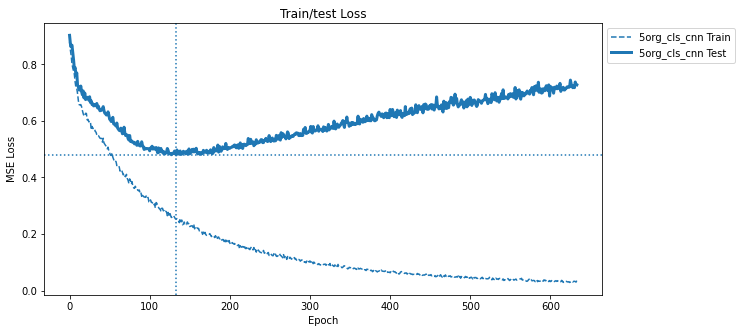

In [15]:
cnn1_name = "5org_cls_cnn"

model_res[cnn1_name] = collect_model_stats(
    cnn1_name,
    seq_len,
    ohe_train_dl,
    ohe_val_dl,
    lr=0.0001,
    ep=5000,
    pat=500,
    opt=torch.optim.Adam,
    model=model,
)

In [16]:
def get_confusion_stats(model,model_name,seq_list,save_file=False,title=None):#seqs,labels,seq_name):
    '''Get class predictions and plot confusion matrix'''

    def plot_confusion_raw_norm(mats):
        f, axes = plt.subplots(len(seq_list), 2, figsize=(9.8, 4.2*len(seq_list)))#, sharey='row')
        #axes = list(axes)
        axes_list = [item for sublist in axes for item in sublist]

        for i,(mat,subtitle) in enumerate(mats):
            disp = ConfusionMatrixDisplay(confusion_matrix=mat)
            disp.plot(ax=axes_list.pop(0))
            #disp.plot(ax=axes.pop(0))
            disp.ax_.set_title(f"{subtitle}")
            disp.im_.colorbar.remove()

        title_str=title if title else model_name
        f.suptitle(f"{title_str}",fontsize=20)
        plt.tight_layout()
        if save_file:
            plt.savefig(save_file)

    model.eval()
    print(f"Running {model_name}")
    
    mats = [] # conf matrices
    res_data = [] # classification results

    for seqs, labels, split_name in seq_list:
        ohe_seqs = torch.stack([torch.tensor(u.one_hot_encode(x)) for x in seqs]).to(DEVICE)
        preds = [x.topk(1).indices.item() for x in model(ohe_seqs.float())]#.tolist()        
        
        cls_rep = classification_report(labels, preds,output_dict=True)
        pr = cls_rep['macro avg']['precision']
        re = cls_rep['macro avg']['recall']
        f1 = cls_rep['macro avg']['f1-score']
        sp = cls_rep['macro avg']['support']
        res_data.append([model_name,split_name,pr,re,f1,sp])
        
        c = confusion_matrix(labels, preds)
        mats.append((c,f"raw counts ({split_name})"))
        # get the normalized confusino matrix
        cp = np.zeros(c.shape)
        for i,row in enumerate(c):
            rowsum = sum(row)
            for j,item in enumerate(row):
                val = item/rowsum
                cp[i][j] = val

        mats.append((cp,f"normed counts ({split_name})"))

    plot_confusion_raw_norm(mats)
    
    res_df = pd.DataFrame(res_data,columns=['model_name','split','mac_precision','mac_recall','mac_f1','support'])
    
    return res_df

In [17]:
pred_dfs = {}


Running 5org_cls_cnn


model_name  split  mac_precision  mac_recall    mac_f1  support
0  5org_cls_cnn  train       0.952919    0.954259  0.953518    15399
1  5org_cls_cnn   test       0.838518    0.836867  0.837538     3850

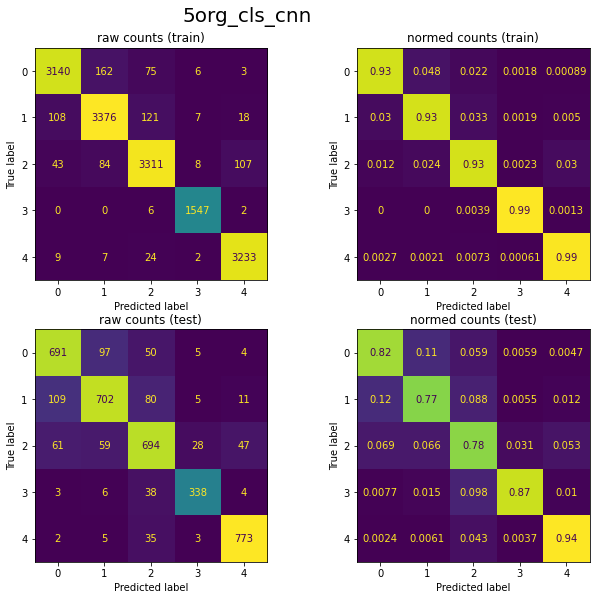

In [18]:
# confusion matrix plotting
seq_list = [
    (train_df["upstream_region"].values,train_df["id"],"train"),
    (test_df["upstream_region"].values,test_df["id"],"test")
]
pred_dfs[cnn1_name] = get_confusion_stats(
    model_res[cnn1_name]['model'],
    model_res[cnn1_name]['model_name'],
    seq_list,
    title=f"{model_res[cnn1_name]['model_name']}"
)

pred_dfs[cnn1_name]

Running untrained_model


/home/ubuntu/anaconda3/envs/torchp/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


model_name  split  mac_precision  mac_recall    mac_f1  support
0  untrained_model  train       0.042535         0.2  0.070151    15399
1  untrained_model   test       0.042494         0.2  0.070094     3850

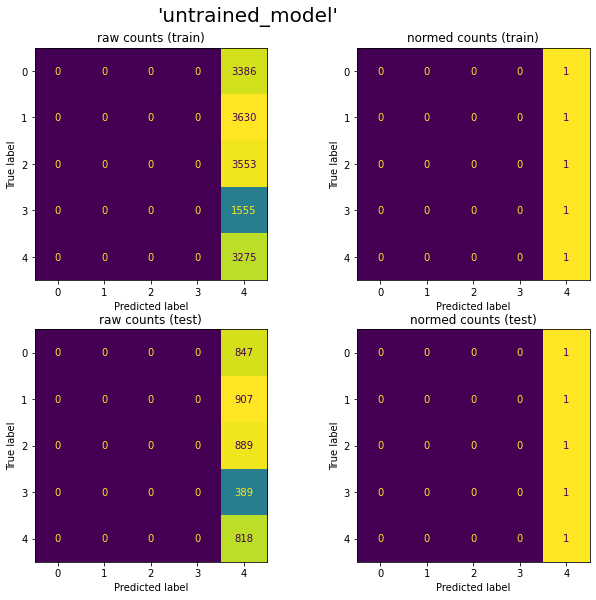

In [19]:
# predictions on untrained model
pred_dfs['untrained_model'] = get_confusion_stats(
    model2.to(DEVICE),
    'untrained_model',
    seq_list,
    title=f"'untrained_model'"
)

pred_dfs['untrained_model']

In [20]:
# # confusion matrix plotting
# fake_seq_list = [
#     (fake_df["upstream_region"].values,[0 for x in fake_df['upstream_region'].values],"5g real"),
#     (fake_df["shuffled_seq"].values,[1 for x in fake_df['shuffled_seq'].values],"shuffles")
# ]
# fake_res_df = get_confusion_stats(
#     t_res['model'],
#     t_res['model_name'],
#     fake_seq_list,
#     title=f"{t_res['model_name']}"
# )

# fake_res_df

In [20]:
# Shuffle all the seqs

In [22]:
def shuffle_seq(dna):
    to_shuffle = list(dna)
    random.shuffle(to_shuffle)
    return  ''.join(to_shuffle)

In [23]:
train_df['shuffled_seq'] = train_df['upstream_region'].apply(lambda x: shuffle_seq(x))
test_df['shuffled_seq'] = test_df['upstream_region'].apply(lambda x: shuffle_seq(x))


Running pred_shuffled_seq


model_name        split  mac_precision  mac_recall    mac_f1  \
0  pred_shuffled_seq  train shuff       0.402947    0.393001  0.378916   
1  pred_shuffled_seq   test shuff       0.389816    0.382543  0.368233   

   support  
0    15399  
1     3850

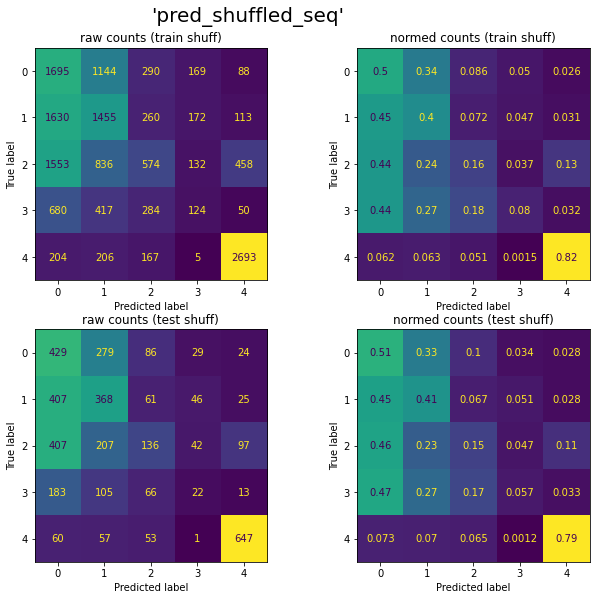

In [25]:
shuff_seq_list = [
    (train_df["shuffled_seq"].values,train_df['id'].values,"train shuff"),
    (test_df["shuffled_seq"].values,test_df['id'].values,"test shuff")
]
pred_dfs['pred_shuffled_seq'] = get_confusion_stats(
    model_res[cnn1_name]['model'],
    'pred_shuffled_seq',
    shuff_seq_list,
    title=f"'pred_shuffled_seq'"
)

pred_dfs['pred_shuffled_seq']

# Look at filters?

In [55]:
def get_conv_layers_from_model(model):
    '''
    Given a trained model, extract its convolutional layers
    '''
    model_children = list(model.children())
    
    # counter to keep count of the conv layers
    model_weights = [] # we will save the conv layer weights in this list
    conv_layers = [] # we will save the actual conv layers in this list
    bias_weights = []
    counter = 0 

    # append all the conv layers and their respective weights to the list
    for i in range(len(model_children)):
        # get model type of Conv1d
        if type(model_children[i]) == nn.Conv2d:
            counter += 1
            model_weights.append(model_children[i].weight)
            conv_layers.append(model_children[i])
            bias_weights.append(model_children[i].bias)

        # also check sequential objects' children for conv1d
        elif type(model_children[i]) == nn.Sequential:
            for child in model_children[i]:
                if type(child) == nn.Conv2d:
                    counter += 1
                    model_weights.append(child.weight)
                    conv_layers.append(child)
                    bias_weights.append(child.bias)

    print(f"Total convolutional layers: {counter}")
    return conv_layers, model_weights, bias_weights

def view_filters(model_weights, num_cols=8):
    # squeeze for conv2d??
    model_weights = model_weights[0].squeeze(1)
    num_filt = model_weights.shape[0]
    filt_width = model_weights[0].shape[1]
    num_rows = int(np.ceil(num_filt/num_cols))
    
    # visualize the first conv layer filters
    plt.figure(figsize=(20, 17))

    for i, filter in enumerate(model_weights):
        ax = plt.subplot(num_rows, num_cols, i+1)
        ax.imshow(filter.cpu().detach(), cmap='gray')
        ax.set_yticks(np.arange(4))
        ax.set_yticklabels(['A', 'C', 'G','T'])
        ax.set_xticks(np.arange(filt_width))
        ax.set_title(f"Filter {i}")

    plt.tight_layout()
    plt.show()
    
def get_conv_output_for_seq(seq, conv_layer):
    '''
    Given an input sequeunce, get the output tensor containing the filter activations
    '''
    #print(f"Running seq {seq}")
    # format seq for input to conv layer (OHE, reshape)
    seq = torch.tensor(u.one_hot_encode(seq)).view(-1,len(seq),4).permute(0,2,1).unsqueeze(0).to(DEVICE)
    # OHE FIX??
    # run through conv layer
    with torch.no_grad(): # don't want as part of gradient graph?
        res = conv_layer(seq.float())
        return res[0]
    

def get_filter_activations(seqs, conv_layer,act_thresh=0):
    '''
    Given a set of input sequences and a trained convolutional layer, 
    determine the subsequences for which each filter in the conv layer 
    activate most strongly. 
    
    1.) Run inputs through conv layer. 
    2.) Loop through filter activations of the resulting tensor, saving the
            position where filter activations were >0. 
    3.) Compile a count matrix for each filter by accumulating subsequences which
            activate the filter
    '''
    # initialize dict of pwms for each filter in the conv layer
    num_filters = conv_layer.out_channels
    filt_width = conv_layer.kernel_size[1]
    filter_pwms = dict((i,torch.zeros(4,filt_width)) for i in range(num_filters))
    
    print("Num filters", num_filters)
    print("filt_width", filt_width)
    #print("filter_pwms", filter_pwms)
    
    # loop through a set of sequences and collect subseqs where each filter activated
    for i,seq in enumerate(seqs):
        if i%100==0:
            print(f"Seq {i} of {len(seqs)}")
        res = get_conv_output_for_seq(seq, conv_layer)
        # for each filter and it's activation vector
        for filt_id,act_vec in enumerate(res):
            act_idxs = torch.where(act_vec>act_thresh)[1]
            activated_positions = [x.item() for x in act_idxs]
            # get subsequences that caused filter to activate
            for pos in activated_positions:
                subseq = seq[pos:pos+filt_width]
                #print("subseq",pos, subseq)
                #subseq_tensor = torch.tensor(u.one_hot_encode(subseq)).view(-1,filt_width,4).permute(0,2,1).squeeze(0)
                #subseq_tensor = torch.tensor(u.one_hot_encode(subseq)).permute(0,2,1).squeeze(0)
                # OHE FIX??
                subseq_tensor = torch.tensor(u.one_hot_encode(subseq)).T
                # add this subseq to the pwm count for this filter
                filter_pwms[filt_id] += subseq_tensor            
            
    return filter_pwms


import logomaker
def view_filters_and_logos(model_weights,filter_activations, num_cols=8,ysc=1.0):
    model_weights = model_weights[0].squeeze(1)
    print(model_weights.shape)
    
    assert(model_weights.shape[0] == len(filter_activations))
    # make sure the model weights agree with the number of filters
    num_filts = len(filter_activations)
    num_rows = int(np.ceil(num_filts/num_cols))*2+1 # not sure why +1 is needed... complained otherwise
    
    plt.figure(figsize=(20, 20*ysc))

    j=0 # use to make sure a filter and it's logo end up vertically paired
    for i, filter in enumerate(model_weights):
        if (i)%num_cols == 0:
            j += num_cols
    #     print('i:', i)
    #     print('j:', j)
    #     print('i%8 == 0', i%8 == 0)
    # #     print('i+1%9 =?', (i+1)%9)
    #     print("i+j+1=", i+j+1)
    #     print("i+j+1+4=", i+j+1+8)
    #     print("*******")

        # display raw filter
        ax1 = plt.subplot(num_rows, num_cols, i+j+1)
        ax1.imshow(filter.cpu().detach(), cmap='gray')
        ax1.set_yticks(np.arange(4))
        ax1.set_yticklabels(['A', 'C', 'G','T'])
        ax1.set_xticks(np.arange(model_weights.shape[2]))
        ax1.set_title(f"Filter {i}")

        # display sequence logo
        ax2 = plt.subplot(num_rows, num_cols, i+j+1+num_cols)
        filt_df = pd.DataFrame(filter_activations[i].T.numpy(),columns=['A','C','G','T'])
        filt_df_info = logomaker.transform_matrix(filt_df,from_type='counts',to_type='information')
        logo = logomaker.Logo(filt_df_info,ax=ax2)
        ax2.set_ylim(0,2)
        ax2.set_title(f"Filter {i}")

    plt.tight_layout()

Total convolutional layers: 2


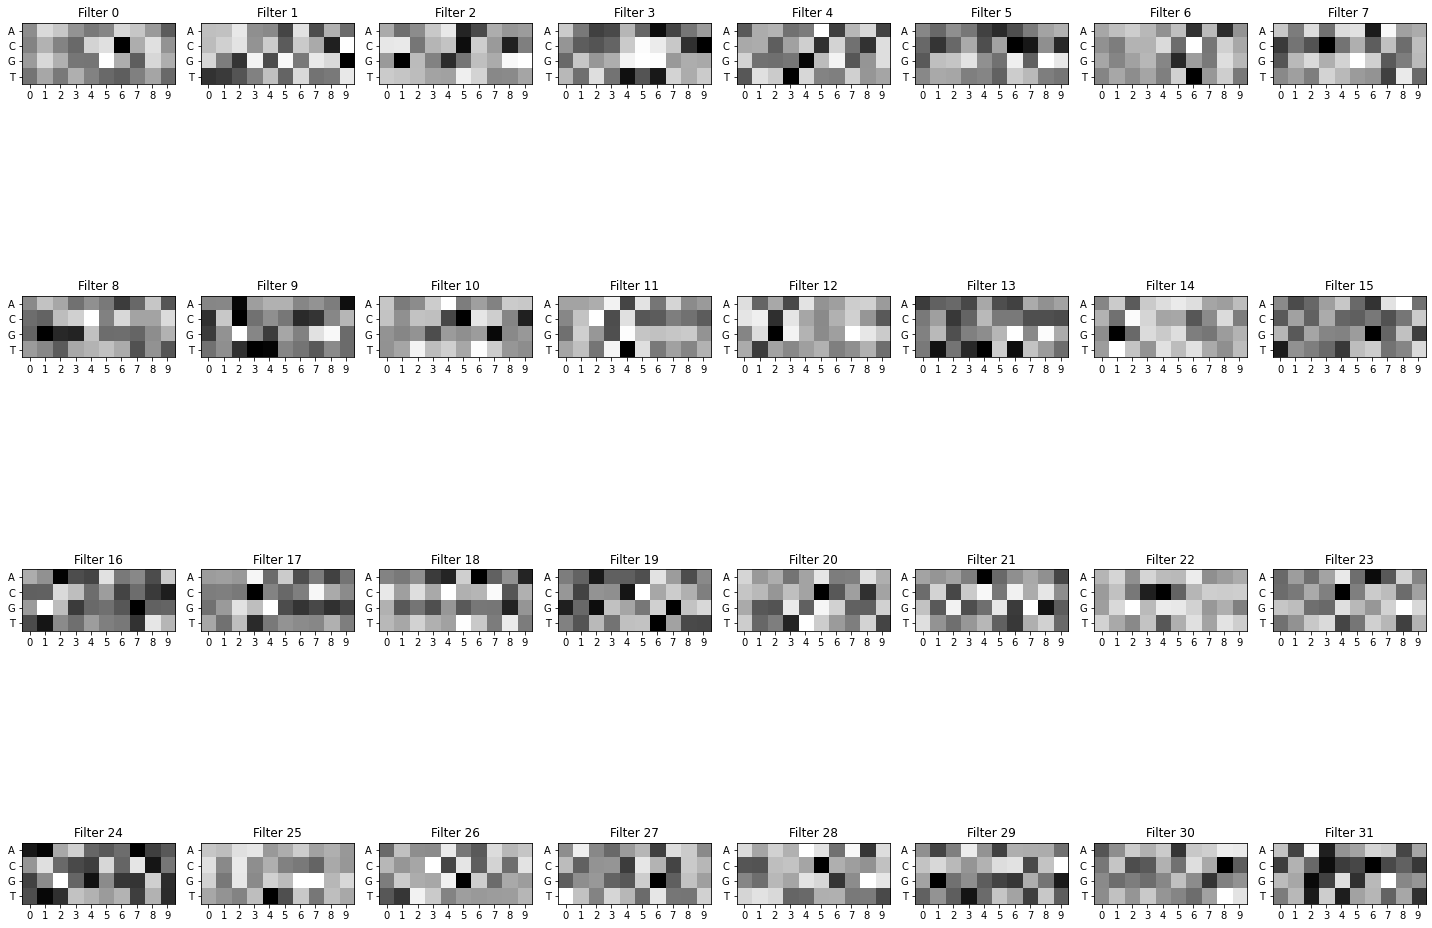

In [56]:
conv_layers, model_weights, bias_weights = get_conv_layers_from_model(t_res['model'])
view_filters(model_weights)

Thresh=1
Num filters 32
filt_width 10
Seq 0 of 3850
Seq 100 of 3850
Seq 200 of 3850
Seq 300 of 3850
Seq 400 of 3850
Seq 500 of 3850
Seq 600 of 3850
Seq 700 of 3850
Seq 800 of 3850
Seq 900 of 3850
Seq 1000 of 3850
Seq 1100 of 3850
Seq 1200 of 3850
Seq 1300 of 3850
Seq 1400 of 3850
Seq 1500 of 3850
Seq 1600 of 3850
Seq 1700 of 3850
Seq 1800 of 3850
Seq 1900 of 3850
Seq 2000 of 3850
Seq 2100 of 3850
Seq 2200 of 3850
Seq 2300 of 3850
Seq 2400 of 3850
Seq 2500 of 3850
Seq 2600 of 3850
Seq 2700 of 3850
Seq 2800 of 3850
Seq 2900 of 3850
Seq 3000 of 3850
Seq 3100 of 3850
Seq 3200 of 3850
Seq 3300 of 3850
Seq 3400 of 3850
Seq 3500 of 3850
Seq 3600 of 3850
Seq 3700 of 3850
Seq 3800 of 3850
torch.Size([32, 4, 10])
Thresh=0.5
Num filters 32
filt_width 10
Seq 0 of 3850
Seq 100 of 3850
Seq 200 of 3850
Seq 300 of 3850
Seq 400 of 3850
Seq 500 of 3850
Seq 600 of 3850
Seq 700 of 3850
Seq 800 of 3850
Seq 900 of 3850
Seq 1000 of 3850
Seq 1100 of 3850
Seq 1200 of 3850
Seq 1300 of 3850
Seq 1400 of 3850
Seq 

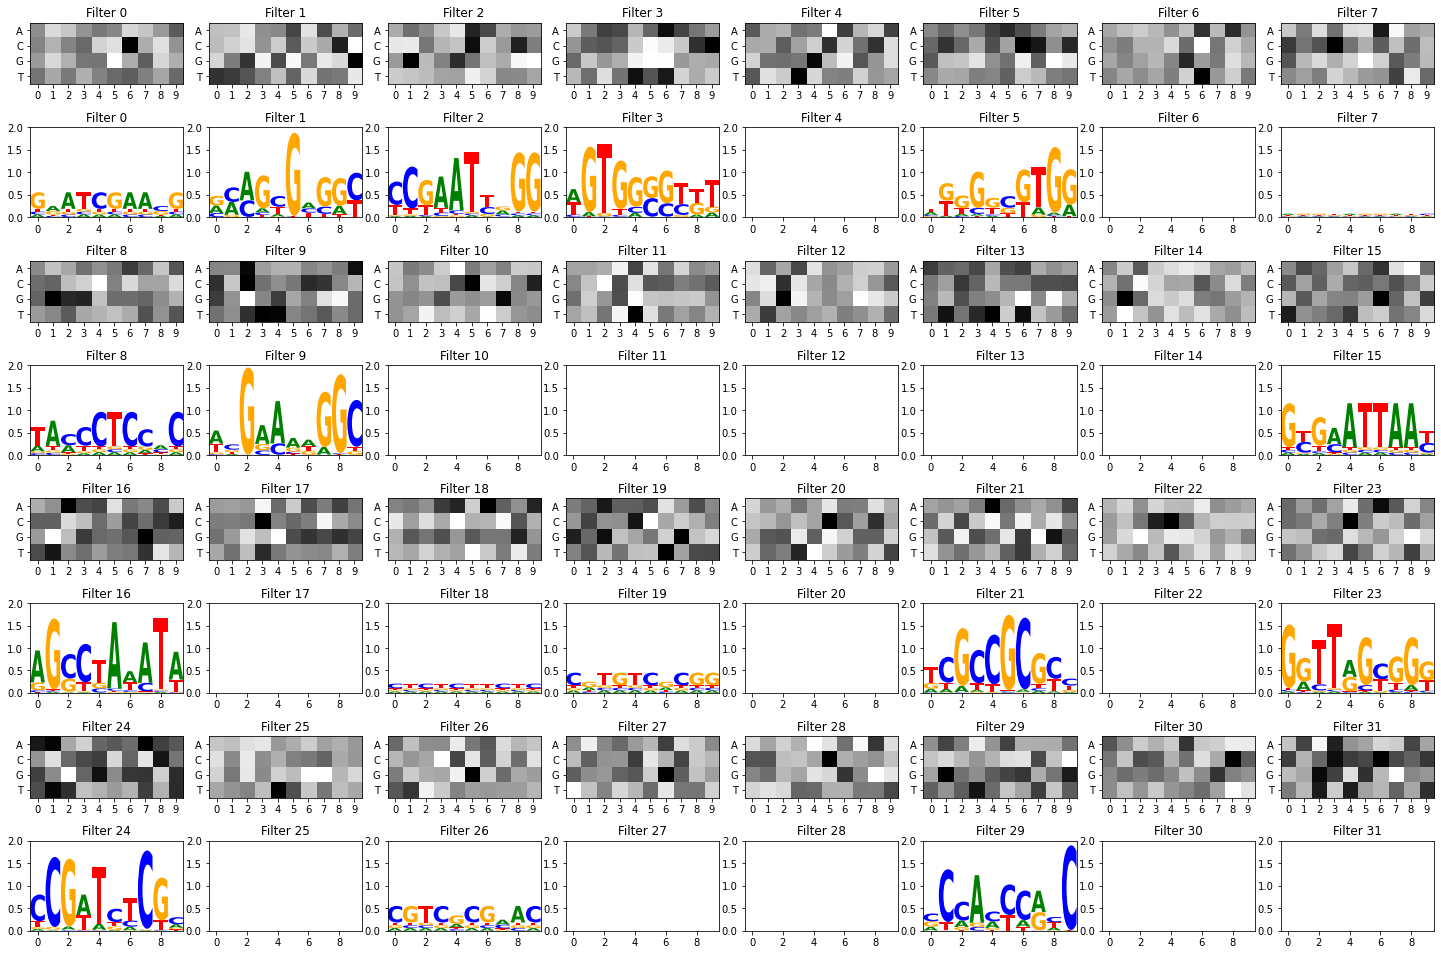

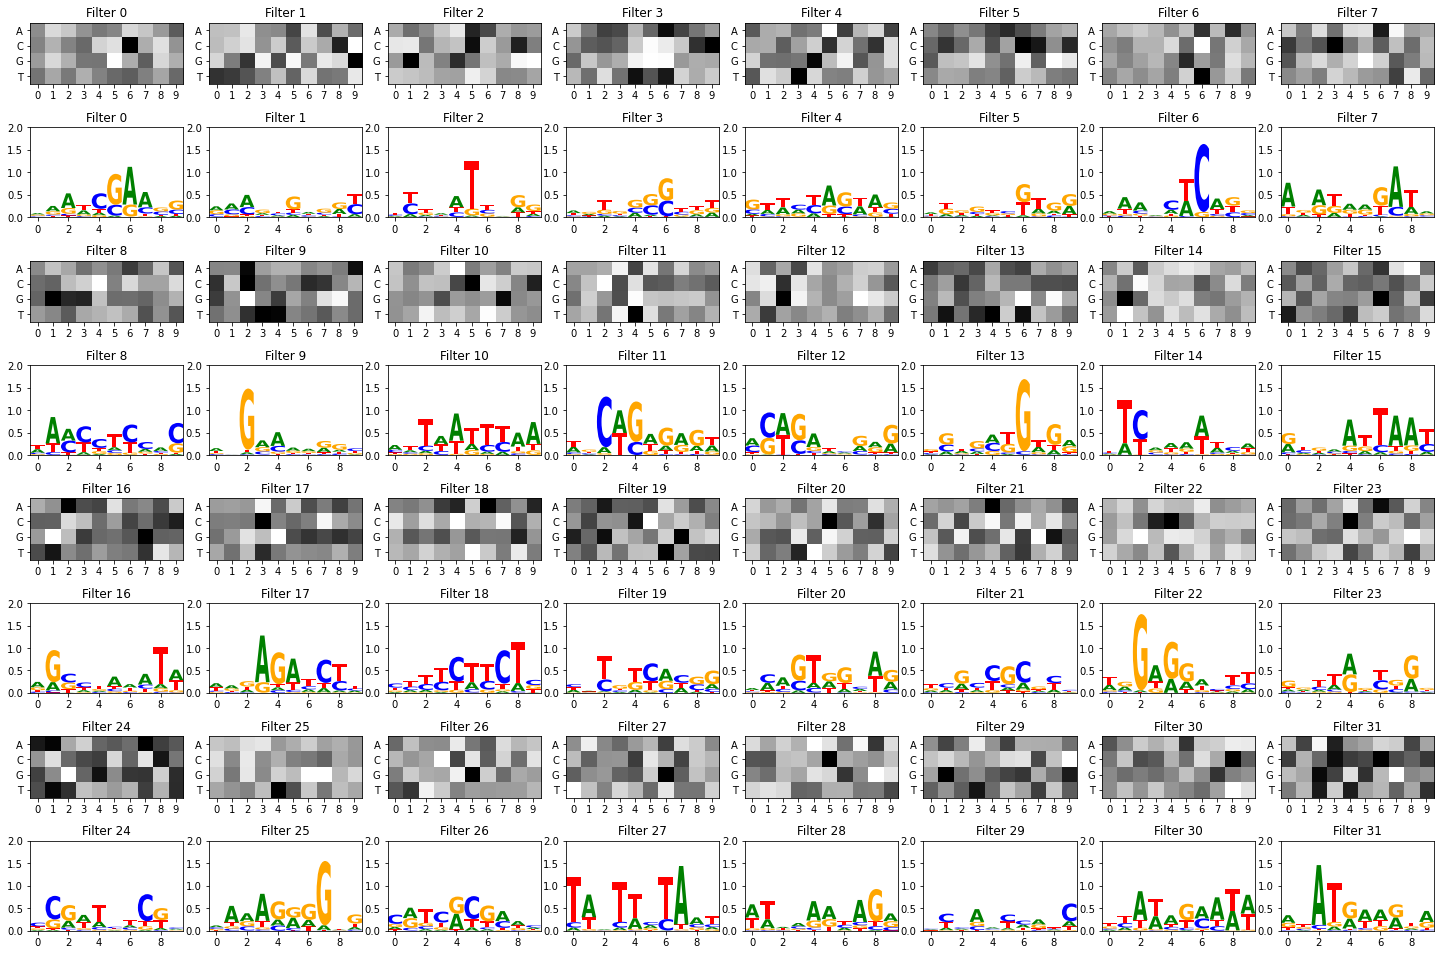

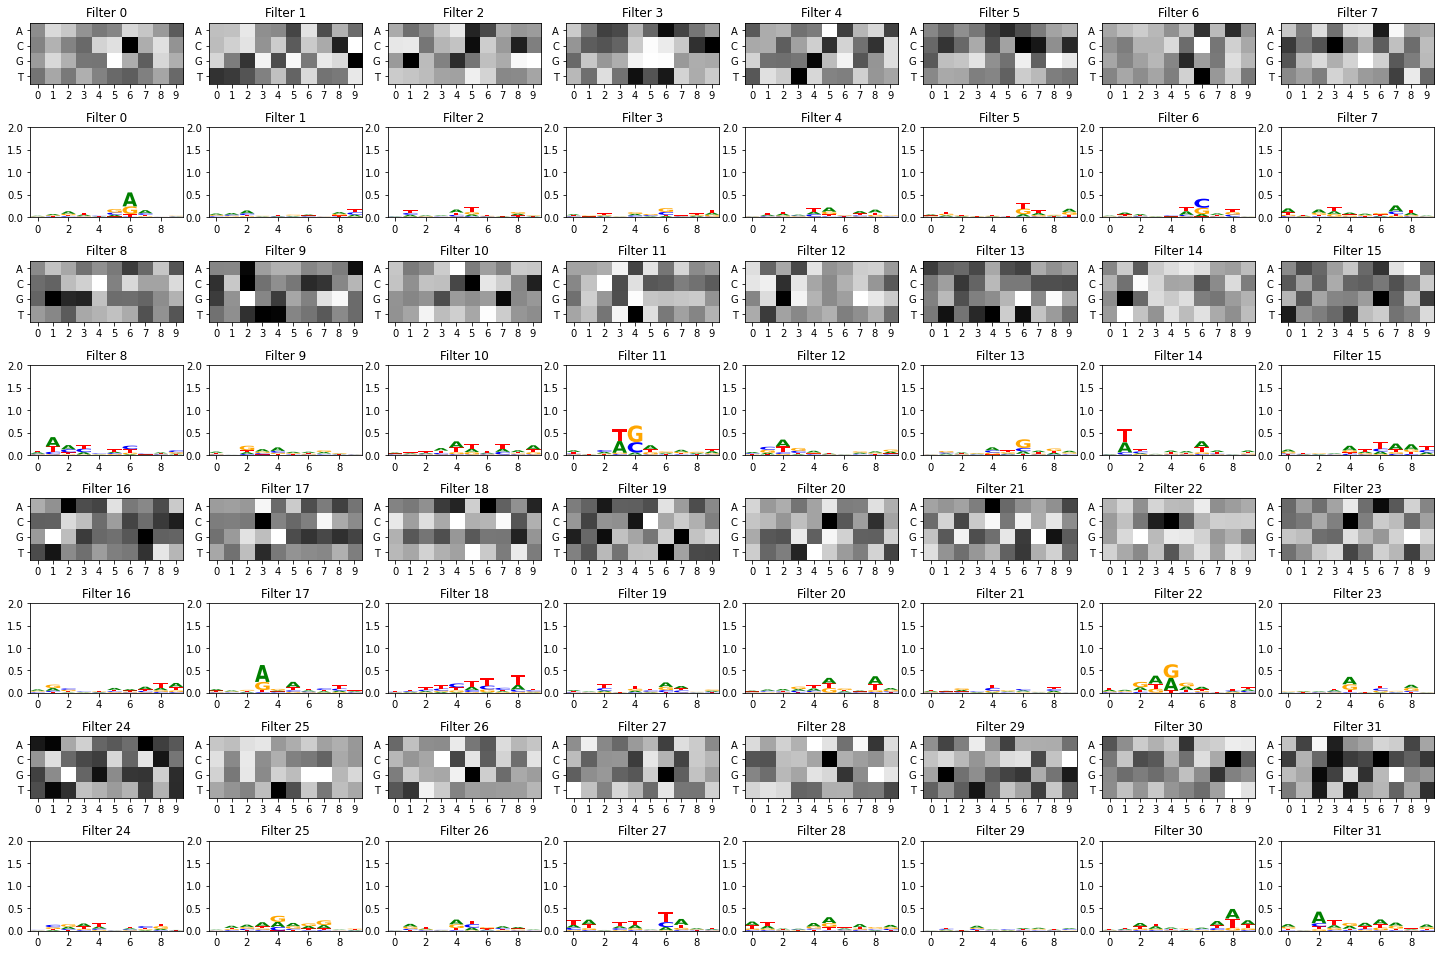

In [57]:
seqs = test_df["upstream_region"].values

print("Thresh=1")
filter_activations = get_filter_activations(seqs, conv_layers[0],act_thresh=1.0)
view_filters_and_logos(model_weights,filter_activations,ysc=0.75)

print("Thresh=0.5")
filter_activations = get_filter_activations(seqs, conv_layers[0],act_thresh=0.5)
view_filters_and_logos(model_weights,filter_activations,ysc=0.75)

print("Thresh=0")
filter_activations = get_filter_activations(seqs, conv_layers[0],act_thresh=0.0)
view_filters_and_logos(model_weights,filter_activations,ysc=0.75)


# Save the model

In [32]:
model = t_res['model']
opt = t_res['opt']

for param_tensor in model.state_dict():
    print(param_tensor, "\t", model.state_dict()[param_tensor].size())
    
# Print optimizer's state_dict
print("Optimizer's state_dict:")
for var_name in opt.state_dict():
    print(var_name, "\t", opt.state_dict()[var_name])

conv_net.0.weight 	 torch.Size([32, 1, 4, 10])
conv_net.0.bias 	 torch.Size([32])
conv_net.4.weight 	 torch.Size([32, 32, 1, 6])
conv_net.4.bias 	 torch.Size([32])
conv_net.8.weight 	 torch.Size([50, 4480])
conv_net.8.bias 	 torch.Size([50])
conv_net.10.weight 	 torch.Size([50, 50])
conv_net.10.bias 	 torch.Size([50])
conv_net.12.weight 	 torch.Size([5, 50])
conv_net.12.bias 	 torch.Size([5])
Optimizer's state_dict:
state 	 {140576937853728: {'step': 79376, 'exp_avg': tensor([[[[-2.7249e-03, -1.5039e-02, -1.1372e-02,  ..., -5.4302e-03,
           -5.0922e-03, -7.5195e-03],
          [-3.1162e-03, -2.2678e-03, -1.4629e-03,  ..., -8.8871e-03,
           -2.6740e-03, -1.6145e-03],
          [-7.3953e-03, -3.8910e-03, -3.7867e-03,  ..., -6.5321e-03,
           -8.1836e-03, -6.4120e-03],
          [-7.8148e-03,  1.4680e-04, -4.4296e-03,  ..., -2.0188e-04,
           -5.1014e-03, -5.5052e-03]]],


        [[[ 1.1443e-02,  8.8581e-03,  7.8530e-03,  ...,  3.6760e-03,
            4.0580e-03,  1

In [30]:
for child in model.named_children():
    print(child)

('conv_net', Sequential(
  (0): Conv2d(1, 32, kernel_size=(4, 10), stride=(1, 1))
  (1): ReLU()
  (2): MaxPool2d(kernel_size=(1, 2), stride=(1, 2), padding=0, dilation=1, ceil_mode=False)
  (3): Dropout(p=0.25, inplace=False)
  (4): Conv2d(32, 32, kernel_size=(1, 6), stride=(1, 1))
  (5): ReLU()
  (6): Dropout(p=0.2, inplace=False)
  (7): Flatten()
  (8): Linear(in_features=4480, out_features=50, bias=True)
  (9): ReLU()
  (10): Linear(in_features=50, out_features=50, bias=True)
  (11): ReLU()
  (12): Linear(in_features=50, out_features=5, bias=True)
))


In [33]:
torch.save(model.state_dict(),'saved_models/5org_cls_cv0_model_state_dict.pt')
torch.save(opt.state_dict(),'saved_models/5org_cls_cv0_opt_state_dict.pt')

In [35]:
t_res.keys()

dict_keys(['model_name', 'model', 'opt', 'train_losses', 'val_losses', 'epoch_stop', 'best_val_score', 'data_label', 'total_time'])

In [37]:
WHOLE_PATH='saved_models/5org_cls_cv0_ALL.tar'

torch.save({
            'epoch': t_res['epoch_stop'],
            'model_state_dict': t_res['model'].state_dict(),
            'opt_state_dict': t_res['opt'].state_dict(),
            'loss': t_res['best_val_score'],
            }, WHOLE_PATH)

In [26]:
# RELOAD MODEL
model3 = m.DNA_2CNN_2FC_Multi(*m_args,**m_kwargs)
model3.load_state_dict(torch.load('saved_models/5org_cls_cv0_model_state_dict.pt'))

<All keys matched successfully>

Running reloaded saved CNN


model_name  split  mac_precision  mac_recall    mac_f1  support
0  reloaded saved CNN  train       0.953473    0.954590  0.953961    15399
1  reloaded saved CNN   test       0.858691    0.857774  0.858161     3850

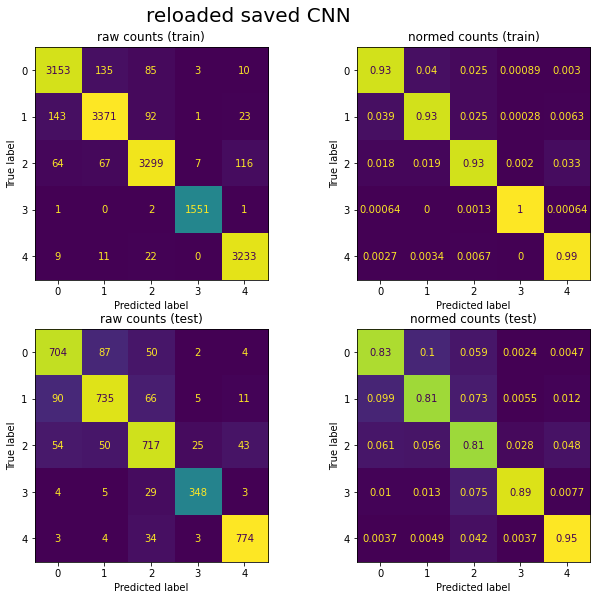

In [28]:
# confusion matrix plotting
seq_list = [
    (train_df["upstream_region"].values,train_df["id"],"train"),
    (test_df["upstream_region"].values,test_df["id"],"test")
]
pred_dfs["reloaded saved CNN"] = get_confusion_stats(
    model3.to(DEVICE),
    "reloaded saved CNN",
    seq_list,
    title=f"reloaded saved CNN"
)

pred_dfs["reloaded saved CNN"]

In [29]:
# Exclude final layer of model.state_dict certain 
to_exclude = ['conv_net.12.weight', 'conv_net.12.bias']
extracted_layers = {k: v for k, v in model3.state_dict().items() if k not in to_exclude}
extracted_layers.keys()

dict_keys(['conv_net.0.weight', 'conv_net.0.bias', 'conv_net.4.weight', 'conv_net.4.bias', 'conv_net.8.weight', 'conv_net.8.bias', 'conv_net.10.weight', 'conv_net.10.bias'])

In [30]:
model4 = m.DNA_2CNN_2FC_Multi(seq_len, 2,**m_kwargs)
model4.load_state_dict(extracted_layers,strict=False)

_IncompatibleKeys(missing_keys=['conv_net.12.weight', 'conv_net.12.bias'], unexpected_keys=[])

In [31]:
model4

DNA_2CNN_2FC_Multi(
  (conv_net): Sequential(
    (0): Conv2d(1, 32, kernel_size=(4, 10), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=(1, 2), stride=(1, 2), padding=0, dilation=1, ceil_mode=False)
    (3): Dropout(p=0.25, inplace=False)
    (4): Conv2d(32, 32, kernel_size=(1, 6), stride=(1, 1))
    (5): ReLU()
    (6): Dropout(p=0.2, inplace=False)
    (7): Flatten()
    (8): Linear(in_features=4480, out_features=50, bias=True)
    (9): ReLU()
    (10): Linear(in_features=50, out_features=50, bias=True)
    (11): ReLU()
    (12): Linear(in_features=50, out_features=2, bias=True)
  )
)

In [ ]:
# ok, successfully loaded warm version of model into model3.
# now can I make model 4 with my alternate prediction head?

Running warm model, 2 heads


/home/ubuntu/anaconda3/envs/torchp/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


model_name  split  mac_precision  mac_recall    mac_f1  support
0  warm model, 2 heads  train       0.087725    0.194340  0.119746    15399
1  warm model, 2 heads   test       0.091870    0.202955  0.124942     3850

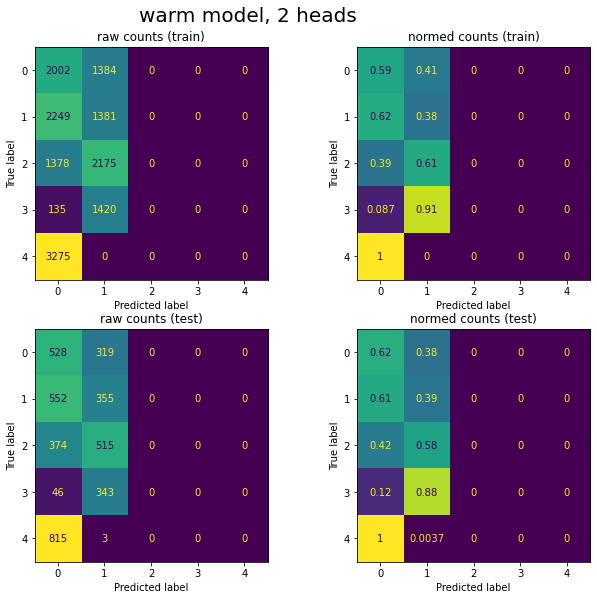

In [32]:
# confusion matrix plotting
seq_list = [
    (train_df["upstream_region"].values,train_df["id"],"train"),
    (test_df["upstream_region"].values,test_df["id"],"test")
]
pred_dfs["warm model, 2 heads"] = get_confusion_stats(
    model4.to(DEVICE),
    "warm model, 2 heads",
    seq_list,
    title=f"warm model, 2 heads"
)

pred_dfs["warm model, 2 heads"]

# Try training a warm model for a different task

### Train/val/test splitting

In [33]:
def plot_train_test_hist(train_df, test_df,val_df=None,score_col='score',bins=10):
    ''' Check distribution of train/test scores, sanity check that its not skewed'''
    plt.hist(train_df[score_col].values,bins=bins,label="train")
    plt.hist(test_df[score_col].values,bins=bins,label='test')
    if val_df is not None:
        plt.hist(val_df[score_col].values,bins=bins,label='val')
    plt.legend()
    plt.xlabel("seq score",fontsize=14)
    plt.ylabel("count",fontsize=14)
    plt.show()

def view_train_test_dist(train_df,test_df,score_cols,title,id_col='locus_tag',val_df=None):
    train_df['set'] = 'train'
    test_df['set'] = 'test'
    if val_df is not None:
        val_df['set'] = "val"
        df = pd.concat([train_df,test_df,val_df])
    else:
        df = pd.concat([train_df,test_df])
    
    df_melt = pd.melt(df, id_vars=[id_col,'set'],value_vars=score_cols,var_name='cond',value_name='score')
    
    sns.stripplot(data=df_melt,x='cond',y='score',hue='set',dodge=True,alpha=0.2)
    plt.title(f"{title} distribution")
    plt.show()
    
    sns.violinplot(data=df_melt,x='cond',y='score',hue='set',dodge=True,alpha=0.2)
    plt.title(f"{title} distribution")
    plt.show()
    
#     sns.boxplot(data=df_melt,x='cond',y='score',hue='set',dodge=True)
#     plt.title(f"{title} distribution")
#     plt.show()
    sns.countplot(data=df_melt,x='score',hue='set')
    plt.title(f"{title} counts")
    plt.show()

In [79]:
# quickly test model on other 5G seqs and shuffled sequences

In [34]:
locus_info_filename = 'data/locus2info_20221031.tsv'
locus_info_df = pd.read_csv(locus_info_filename,sep='\t')
locus2info = u.make_info_dict(locus_info_df)

#data_filename = "data/XY_lr_noCu_opFilt.tsv"
#data_filename = "data/XY_logTPM_opFilt_20221031.tsv"
data_filename = "data/XY_lr_noCu_opFilt_20221031.tsv"
XYdf_og = pd.read_csv(data_filename,sep='\t')
XYdf_og['gene'] = XYdf_og['locus_tag'].apply(lambda x: locus2info[x]['gene'])
XYdf_og['product'] = XYdf_og['locus_tag'].apply(lambda x: locus2info[x]['product'])
XYdf_og['type'] = XYdf_og['locus_tag'].apply(lambda x: locus2info[x]['type'])

XYdf_og

og_index      locus_tag  \
0            0  EQU24_RS00005   
1            1  EQU24_RS00010   
2            2  EQU24_RS00015   
3            4  EQU24_RS00035   
4            9  EQU24_RS00060   
...        ...            ...   
2206      4182  EQU24_RS23145   
2207      4184  EQU24_RS23155   
2208      4186  EQU24_RS23165   
2209      4187  EQU24_RS23170   
2210      4188  EQU24_RS23175   

                                        upstream_region      uMax  \
0     ACTGTTAGCTTGGCACGGCCCTTGGCTCTGCGGGCGTTAAGGACTT...  0.333441   
1     GTGGACGCGATCACACCACGGTTATTAATGCTTGTAAACGCATTGC...  0.179318   
2     TTGCGAAGAGGGGCGGTTTCTCGTCCGACAGGCGTCGGCGGCAAGG...  0.364849   
3     GTATAAACCATGAAAGTCAGCCTATTTCGAAGATACCGACACCCTA...  0.193539   
4     GAATTTTCGGGTTCGGGCATCAGCTACCGGGTATCGCCGGTACTCG...  0.173256   
...                                                 ...       ...   
2206  TTCCGAAAATAAATTGATTTCAAGCGATATACGGGTAGTCGGGTTA...  0.620221   
2207  TTCCGAAAATAAATTGATTTCAAGCGATATACGGGTAGTCGGGTTA...  0.609995   
2208  TTGAAACCCTAAGGTACATTGAGGCGTTAGCAAAGAGCAAGTTTGA...  0.605448   
2209  AATCTTCATTAGAGTCGAACGAAGTTTCATGTTTTCGGCTTCCTCA...  0.604488   
2210  GACAACAAATGAACATGATTCGTCATCTGAACGAAAGCGTAAAGCT...  0.191106   

      lowO2_fast_growth    lowCH4      MeOH  NoCu     medCu    highCu  ...  \
0             -0.087509 -0.248330 -0.654293   0.0  0.252788  0.260753  ...   
1             -0.183682 -0.493245 -1.323530   0.0  0.418315  0.611021  ...   
2              0.170159 -0.338861 -0.347147   0.0  0.287824  0.387577  ...   
3              0.035923  0.136026 -0.642058   0.0  0.189394  0.345084  ...   
4              0.283822 -0.740565 -1.011908   0.0  0.215938  0.306791  ...   
...                 ...       ...       ...   ...       ...       ...  ...   
2206           0.718300  0.245892 -1.598809   0.0  0.171579  0.501296  ...   
2207           0.702416  0.231606 -1.614646   0.0  0.154029  0.483579  ...   
2208           0.688065  0.233752 -1.594922   0.0  0.171939  0.486032  ...   
2209           0.196871 -0.261330  0.125607   0.0 -0.014653  0.229101  ...   
2210          -0.064682 -0.560132  0.116334   0.0 -0.067585 -0.349116  ...   

      WithLanthanum  NoLanthanum  LanzaTech    aa3_KO  crotonic_acid  \
0         -0.117634    -0.180709  -0.516711 -0.472602       0.058102   
1         -0.244793    -0.161434   0.237179 -0.079076       0.132689   
2         -0.249011    -0.066333  -0.987336 -0.990306       0.481623   
3          0.643283     0.566397  -0.952383 -0.465515       0.009531   
4          0.539188     0.622656  -0.716034 -0.025042       0.070784   
...             ...          ...        ...       ...            ...   
2206       0.977712     1.564370   0.701928  1.577361       0.777911   
2207       0.952955     1.548383   0.701457  1.573150       0.761210   
2208       0.899683     1.442487   0.708730  1.520411       0.769644   
2209      -0.233161     0.107133   0.265191 -0.870372       0.814080   
2210      -1.215170    -1.821202  -0.326240 -1.481259       0.175490   

      CH4_500ppm  CH4_1000ppm  gene  \
0       0.668619     0.215153  dnaA   
1      -0.462317    -0.490073  dnaN   
2       0.144467    -0.239513  recF   
3       0.367039     0.695145   NaN   
4      -0.367242    -0.319915   NaN   
...          ...          ...   ...   
2206    0.463434     0.727701  hxlA   
2207    0.433925     0.705205  hxlA   
2208    0.032260     0.305817  hxlA   
2209   -0.245552    -0.285502   NaN   
2210   -2.693962    -3.214980   NaN   

                                                product  type  
0        chromosomal replication initiator protein DnaA   CDS  
1                       DNA polymerase III subunit beta   CDS  
2                   DNA replication/repair protein RecF   CDS  
3                                  hypothetical protein   CDS  
4     bifunctional diguanylate cyclase/phosphodieste...   CDS  
...                                                 ...   ...  
2206                    3-hexulose-6-phosphate synthase   CDS

In [35]:
wt_df = XYdf_og[['locus_tag','upstream_region']]
fake_df = XYdf_og[['locus_tag','upstream_region']]
fake_df['upstream_region'] = fake_df['upstream_region'].apply(lambda x: shuffle_seq(x))
fake_df

/home/ubuntu/anaconda3/envs/torchp/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


locus_tag                                    upstream_region
0     EQU24_RS00005  GTAAATGCTTGTATTGTTACGTTGTTTGAAACTTAGATAGGCCCAC...
1     EQU24_RS00010  AAGATGAATCGGTTTGTGGAAGTCTTCAGTACCGAGAGAATTAACA...
2     EQU24_RS00015  CTCCATGCCTATCGTTTATCTCATATTTGTCGATTCAACCGACGCC...
3     EQU24_RS00035  ATGGGTGACGGTGACTTATCATCGCTGGCAAACATCCTGTCCTTAG...
4     EQU24_RS00060  ACAACAATGTCCCCAACGTAAAATTTCTTCTTTATGGTCAAATTCA...
...             ...                                                ...
2206  EQU24_RS23145  AGGTAATGGACCGGCATCTTTCTGAAAACTCTTGCCTTCGACAAGT...
2207  EQU24_RS23155  AACGCGACACACTTGAGGCTGATAACATTACGGCCTCAATACTCGC...
2208  EQU24_RS23165  ATAAGGTCTAAGTAAAAGCCGGTGAAATTAGCTCACGAAGGGAGAC...
2209  EQU24_RS23170  TCTGCCGATTATACTGTACAGTCTCCTAATAGTGATTGTCAACAGT...
2210  EQU24_RS23175  AATTGCTCAAACCTTTTTATCTTGAACAAGAGGGAGCAACAAACTA...

[2211 rows x 2 columns]

In [36]:
wt_df['id'] = 0
fake_df['id']=1

/home/ubuntu/anaconda3/envs/torchp/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/home/ubuntu/anaconda3/envs/torchp/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [37]:
wtshuff_df = pd.concat([wt_df,fake_df])
wtshuff_df

locus_tag                                    upstream_region  id
0     EQU24_RS00005  ACTGTTAGCTTGGCACGGCCCTTGGCTCTGCGGGCGTTAAGGACTT...   0
1     EQU24_RS00010  GTGGACGCGATCACACCACGGTTATTAATGCTTGTAAACGCATTGC...   0
2     EQU24_RS00015  TTGCGAAGAGGGGCGGTTTCTCGTCCGACAGGCGTCGGCGGCAAGG...   0
3     EQU24_RS00035  GTATAAACCATGAAAGTCAGCCTATTTCGAAGATACCGACACCCTA...   0
4     EQU24_RS00060  GAATTTTCGGGTTCGGGCATCAGCTACCGGGTATCGCCGGTACTCG...   0
...             ...                                                ...  ..
2206  EQU24_RS23145  AGGTAATGGACCGGCATCTTTCTGAAAACTCTTGCCTTCGACAAGT...   1
2207  EQU24_RS23155  AACGCGACACACTTGAGGCTGATAACATTACGGCCTCAATACTCGC...   1
2208  EQU24_RS23165  ATAAGGTCTAAGTAAAAGCCGGTGAAATTAGCTCACGAAGGGAGAC...   1
2209  EQU24_RS23170  TCTGCCGATTATACTGTACAGTCTCCTAATAGTGATTGTCAACAGT...   1
2210  EQU24_RS23175  AATTGCTCAAACCTTTTTATCTTGAACAAGAGGGAGCAACAAACTA...   1

[4422 rows x 3 columns]

In [39]:
from sklearn.model_selection import GroupKFold,GroupShuffleSplit,StratifiedKFold #StratifiedGroupKFold
skf = StratifiedKFold(n_splits=5)


_____Split 0____


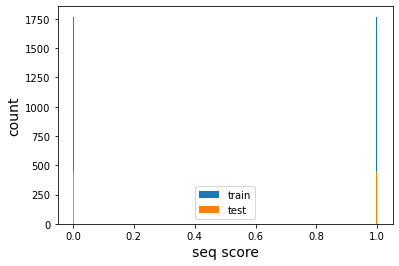

/home/ubuntu/anaconda3/envs/torchp/lib/python3.7/site-packages/ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  del sys.path[0]
/home/ubuntu/anaconda3/envs/torchp/lib/python3.7/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


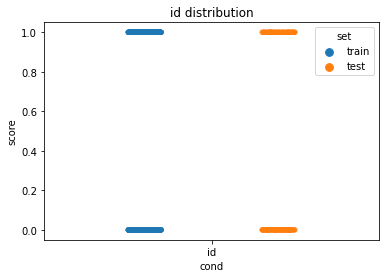

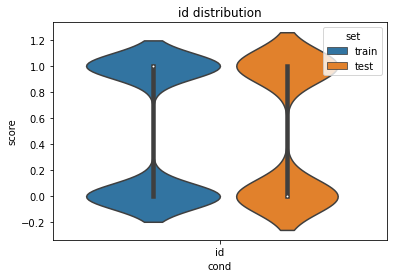

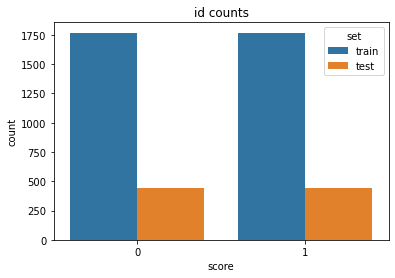


_____Split 1____


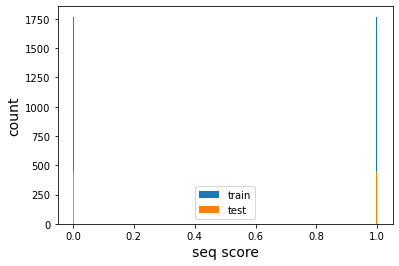

/home/ubuntu/anaconda3/envs/torchp/lib/python3.7/site-packages/ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  del sys.path[0]
/home/ubuntu/anaconda3/envs/torchp/lib/python3.7/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


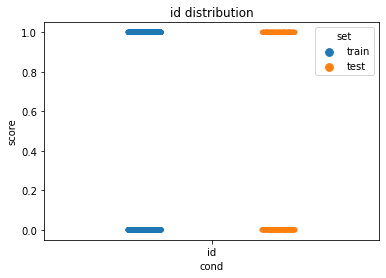

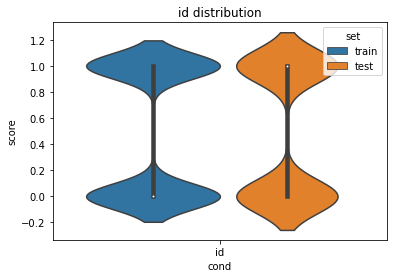

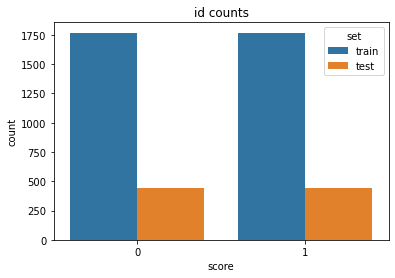


_____Split 2____


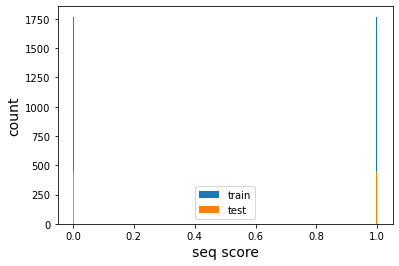

/home/ubuntu/anaconda3/envs/torchp/lib/python3.7/site-packages/ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  del sys.path[0]
/home/ubuntu/anaconda3/envs/torchp/lib/python3.7/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


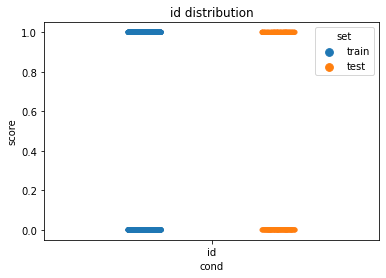

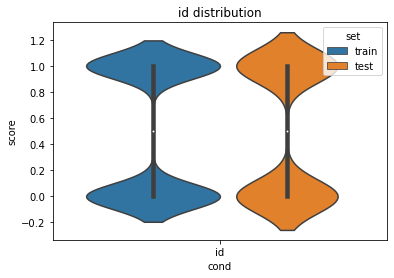

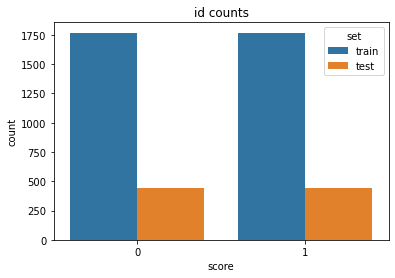


_____Split 3____


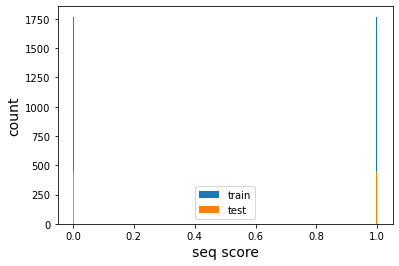

/home/ubuntu/anaconda3/envs/torchp/lib/python3.7/site-packages/ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  del sys.path[0]
/home/ubuntu/anaconda3/envs/torchp/lib/python3.7/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


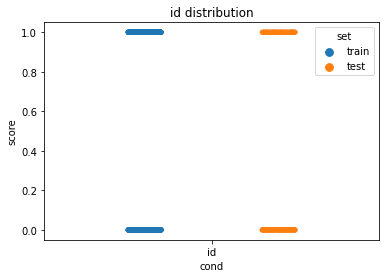

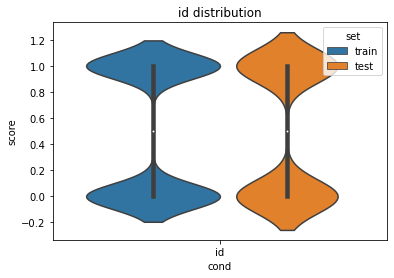

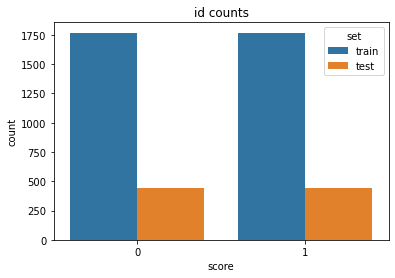


_____Split 4____


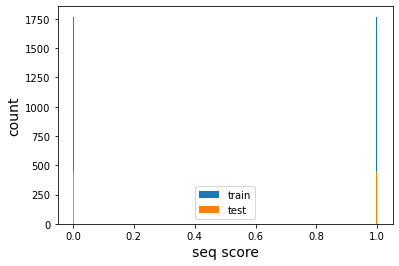

/home/ubuntu/anaconda3/envs/torchp/lib/python3.7/site-packages/ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  del sys.path[0]
/home/ubuntu/anaconda3/envs/torchp/lib/python3.7/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


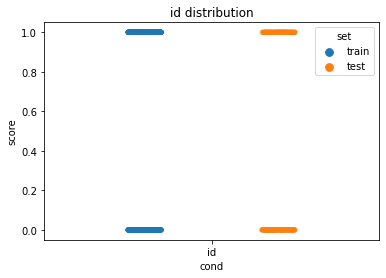

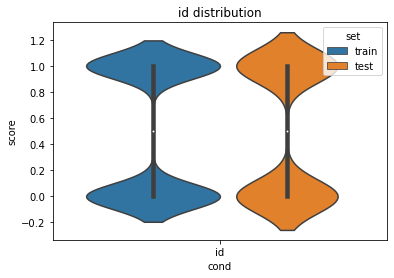

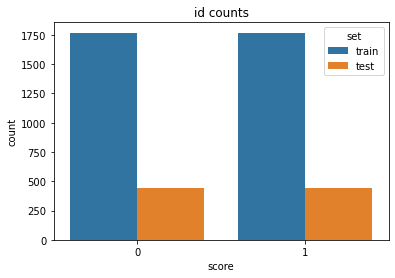

In [40]:
for i, (train_idxs, test_idxs) in enumerate(skf.split(wtshuff_df, wtshuff_df['id'])):
    print(f"_____Split {i}____")
    wts_train_df = wtshuff_df.iloc[train_idxs]
    wts_test_df = wtshuff_df.iloc[test_idxs]
    
    score_col = "id"

    plot_train_test_hist(wts_train_df, wts_test_df,score_col=score_col,bins=200)
    view_train_test_dist(wts_train_df, wts_test_df,[score_col],"id",id_col='locus_tag')
    
    print("")
    
    split_dfs = {
        'train':wts_train_df,
        'test':wts_test_df
    }
    
    wts_train_df.to_csv(f'data/5g_wt_shuff_splits/cv{i}_train.tsv',index=False,sep='\t')
    wts_test_df.to_csv(f'data/5g_wt_shuff_splits/cv{i}_test.tsv',index=False,sep='\t')


In [41]:
dataset_types = [
    DatasetSpec('ohe'),
]

wts_dls = tu.build_dataloaders_single(
                wts_train_df, 
                wts_test_df, 
                dataset_types, # just OHE for now
                seq_col='upstream_region',
                target_col='id',
                sampler=None,
                shuffle=True,
            )
wts_ohe_train_dl,wts_ohe_val_dl = wts_dls['ohe']

E:215 | train loss:0.035 | val loss: 0.248:   4%|▍         | 216/5000 [00:33<12:09,  6.56it/s]

EarlyStopping counter: 125 out of 500


E:340 | train loss:0.016 | val loss: 0.291:   7%|▋         | 341/5000 [00:52<11:47,  6.58it/s]

EarlyStopping counter: 250 out of 500


E:465 | train loss:0.013 | val loss: 0.330:   9%|▉         | 466/5000 [01:11<11:22,  6.64it/s]

EarlyStopping counter: 375 out of 500


E:589 | train loss:0.006 | val loss: 0.341:  12%|█▏        | 589/5000 [01:30<11:19,  6.50it/s]


EarlyStopping counter: 500 out of 500
Early stopping


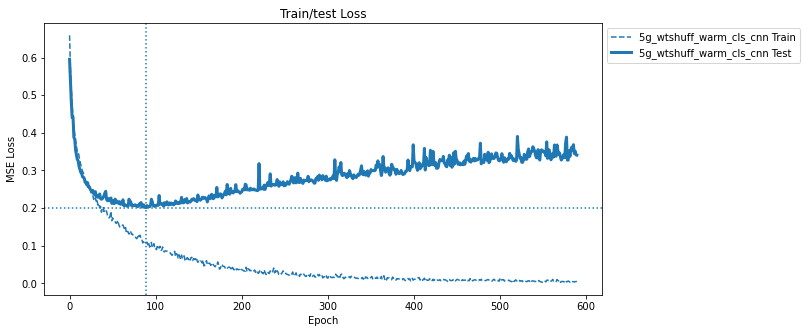

In [42]:
cnn2_name = "5g_wtshuff_warm_cls_cnn"

model_res[cnn2_name] = collect_model_stats(
    cnn2_name,
    seq_len,
    wts_ohe_train_dl,
    wts_ohe_val_dl,
    lr=0.0001,
    ep=5000,
    pat=500,
    opt=torch.optim.Adam,
    model=model4,
)

Running warm model, new task, 2 heads


model_name  split  mac_precision  mac_recall    mac_f1  \
0  warm model, new task, 2 heads  train       0.990956    0.990955  0.990955   
1  warm model, new task, 2 heads   test       0.925557    0.925339  0.925330   

   support  
0     3538  
1      884

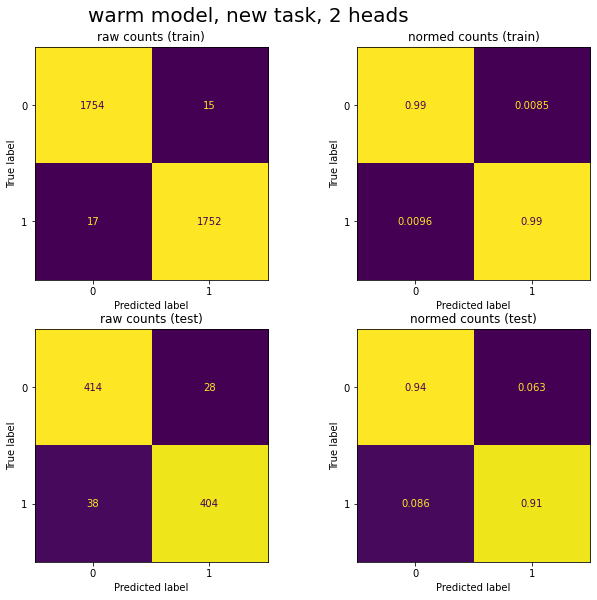

In [44]:
# confusion matrix plotting
seq_list = [
    (wts_train_df["upstream_region"].values,wts_train_df["id"],"train"),
    (wts_test_df["upstream_region"].values,wts_test_df["id"],"test")
]
pred_dfs["warm model, new task, 2 heads"] = get_confusion_stats(
    model4.to(DEVICE),
    "warm model, new task, 2 heads",
    seq_list,
    title=f"warm model, new task, 2 heads"
)

pred_dfs["warm model, new task, 2 heads"]

E:259 | train loss:0.039 | val loss: 0.301:   5%|▌         | 260/5000 [00:40<11:58,  6.60it/s]

EarlyStopping counter: 125 out of 500


E:384 | train loss:0.020 | val loss: 0.310:   8%|▊         | 385/5000 [00:59<11:51,  6.48it/s]

EarlyStopping counter: 250 out of 500


E:509 | train loss:0.007 | val loss: 0.326:  10%|█         | 510/5000 [01:18<11:25,  6.55it/s]

EarlyStopping counter: 375 out of 500


E:633 | train loss:0.008 | val loss: 0.362:  13%|█▎        | 633/5000 [01:37<11:11,  6.50it/s]


EarlyStopping counter: 500 out of 500
Early stopping


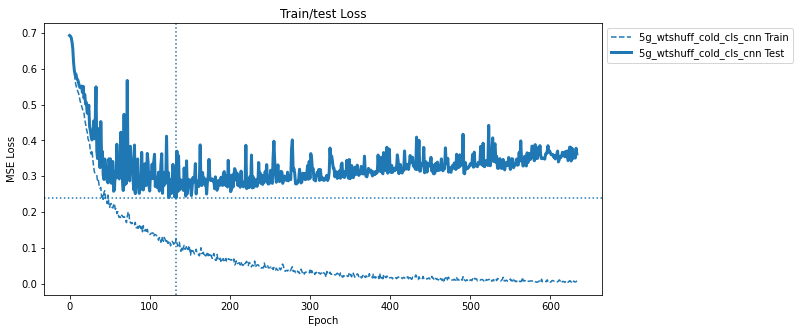

In [45]:
cnn3_name = "5g_wtshuff_cold_cls_cnn"

model5 = m.DNA_2CNN_2FC_Multi(seq_len, 2,**m_kwargs)

model_res[cnn3_name] = collect_model_stats(
    cnn3_name,
    seq_len,
    wts_ohe_train_dl,
    wts_ohe_val_dl,
    lr=0.0001,
    ep=5000,
    pat=500,
    opt=torch.optim.Adam,
    model=model5,
)

Running cold model, new task, 2 heads


model_name  split  mac_precision  mac_recall    mac_f1  \
0  cold model, new task, 2 heads  train       0.994928    0.994912  0.994912   
1  cold model, new task, 2 heads   test       0.901750    0.901584  0.901574   

   support  
0     3538  
1      884

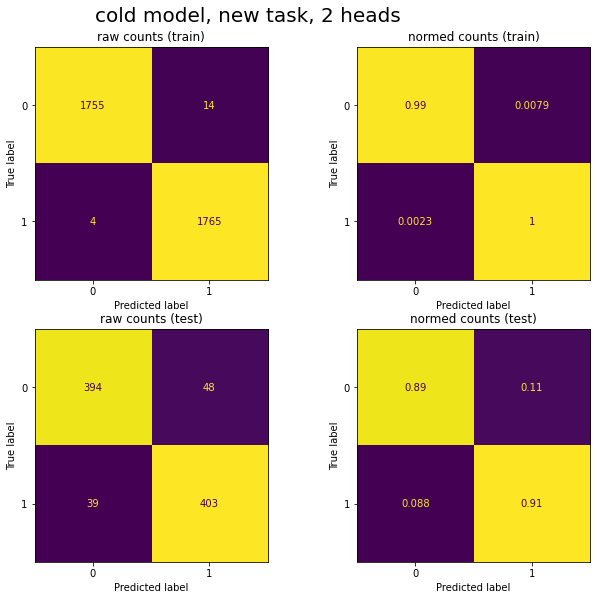

In [46]:
# confusion matrix plotting
seq_list = [
    (wts_train_df["upstream_region"].values,wts_train_df["id"],"train"),
    (wts_test_df["upstream_region"].values,wts_test_df["id"],"test")
]
pred_dfs["cold model, new task, 2 heads"] = get_confusion_stats(
    model5.to(DEVICE),
    "cold model, new task, 2 heads",
    seq_list,
    title=f"cold model, new task, 2 heads"
)

pred_dfs["cold model, new task, 2 heads"]

Running untrained model, new task, 2 heads


/home/ubuntu/anaconda3/envs/torchp/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


model_name  split  mac_precision  mac_recall  \
0  untrained model, new task, 2 heads  train           0.25         0.5   
1  untrained model, new task, 2 heads   test           0.25         0.5   

     mac_f1  support  
0  0.333333     3538  
1  0.333333      884

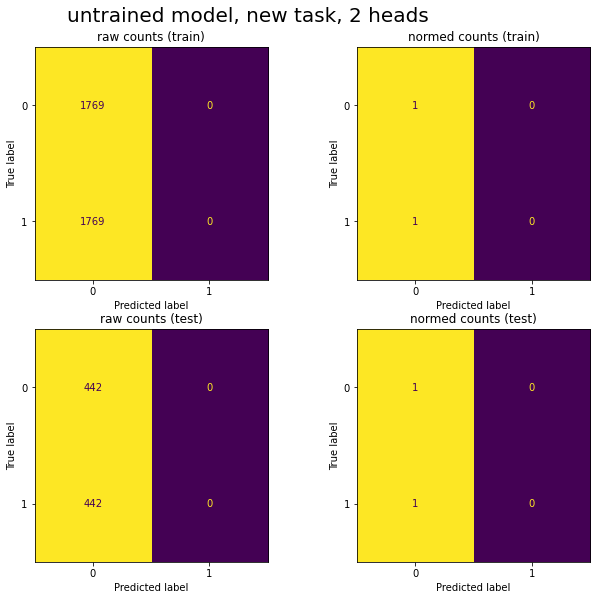

In [47]:
model6 = m.DNA_2CNN_2FC_Multi(seq_len, 2,**m_kwargs)

pred_dfs["untrained model, new task, 2 heads"] = get_confusion_stats(
    model6.to(DEVICE),
    "untrained model, new task, 2 heads",
    seq_list,
    title=f"untrained model, new task, 2 heads"
)

pred_dfs["untrained model, new task, 2 heads"]

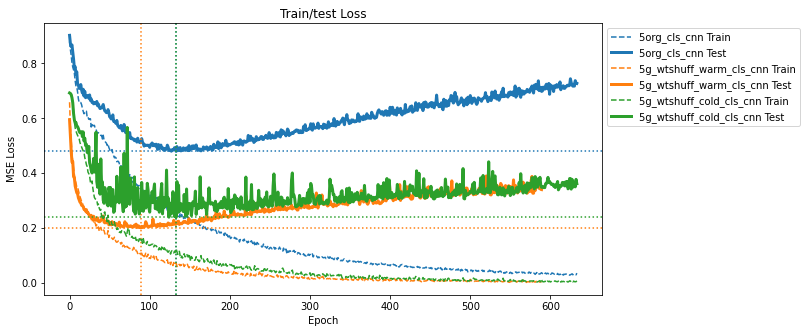

In [48]:
tu.quick_loss_plot([model_res[x]['data_label'][0] for x in model_res])

In [50]:
all_preds = pd.concat([pred_dfs[x] for x in pred_dfs])
all_preds

model_name        split  mac_precision  mac_recall  \
0                        5org_cls_cnn        train       0.952919    0.954259   
1                        5org_cls_cnn         test       0.838518    0.836867   
0                     untrained_model        train       0.042535    0.200000   
1                     untrained_model         test       0.042494    0.200000   
0                   pred_shuffled_seq  train shuff       0.402947    0.393001   
1                   pred_shuffled_seq   test shuff       0.389816    0.382543   
0                  reloaded saved CNN        train       0.953473    0.954590   
1                  reloaded saved CNN         test       0.858691    0.857774   
0                 warm model, 2 heads        train       0.087725    0.194340   
1                 warm model, 2 heads         test       0.091870    0.202955   
0       warm model, new task, 2 heads        train       0.990956    0.990955   
1       warm model, new task, 2 heads         test       0.925557    0.925339   
0       cold model, new task, 2 heads        train       0.994928    0.994912   
1       cold model, new task, 2 heads         test       0.901750    0.901584   
0  untrained model, new task, 2 heads        train       0.250000    0.500000   
1  untrained model, new task, 2 heads         test       0.250000    0.500000   

     mac_f1  support  
0  0.953518    15399  
1  0.837538     3850  
0  0.070151    15399  
1  0.070094     3850  
0  0.378916    15399  
1  0.368233     3850  
0  0.953961    15399  
1  0.858161     3850  
0  0.119746    15399  
1  0.124942     3850  
0  0.990955     3538  
1  0.925330      884  
0  0.994912     3538  
1  0.901574      884  
0  0.333333     3538  
1  0.333333      884

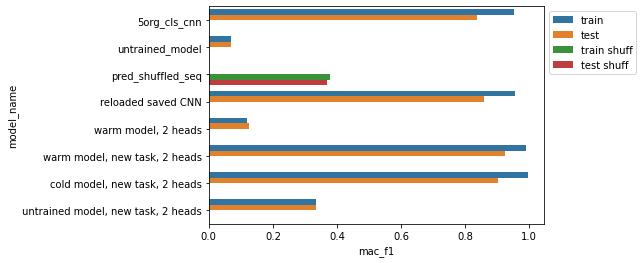

In [57]:
sns.barplot(data=all_preds,y='model_name',x='mac_f1',hue='split',dodge=True)
plt.legend(bbox_to_anchor=(1,1),loc='upper left')


# Ok, try a warm vs cold start for Copper?

In [58]:
XYdf_og

og_index      locus_tag  \
0            0  EQU24_RS00005   
1            1  EQU24_RS00010   
2            2  EQU24_RS00015   
3            4  EQU24_RS00035   
4            9  EQU24_RS00060   
...        ...            ...   
2206      4182  EQU24_RS23145   
2207      4184  EQU24_RS23155   
2208      4186  EQU24_RS23165   
2209      4187  EQU24_RS23170   
2210      4188  EQU24_RS23175   

                                        upstream_region      uMax  \
0     ACTGTTAGCTTGGCACGGCCCTTGGCTCTGCGGGCGTTAAGGACTT...  0.333441   
1     GTGGACGCGATCACACCACGGTTATTAATGCTTGTAAACGCATTGC...  0.179318   
2     TTGCGAAGAGGGGCGGTTTCTCGTCCGACAGGCGTCGGCGGCAAGG...  0.364849   
3     GTATAAACCATGAAAGTCAGCCTATTTCGAAGATACCGACACCCTA...  0.193539   
4     GAATTTTCGGGTTCGGGCATCAGCTACCGGGTATCGCCGGTACTCG...  0.173256   
...                                                 ...       ...   
2206  TTCCGAAAATAAATTGATTTCAAGCGATATACGGGTAGTCGGGTTA...  0.620221   
2207  TTCCGAAAATAAATTGATTTCAAGCGATATACGGGTAGTCGGGTTA...  0.609995   
2208  TTGAAACCCTAAGGTACATTGAGGCGTTAGCAAAGAGCAAGTTTGA...  0.605448   
2209  AATCTTCATTAGAGTCGAACGAAGTTTCATGTTTTCGGCTTCCTCA...  0.604488   
2210  GACAACAAATGAACATGATTCGTCATCTGAACGAAAGCGTAAAGCT...  0.191106   

      lowO2_fast_growth    lowCH4      MeOH  NoCu     medCu    highCu  ...  \
0             -0.087509 -0.248330 -0.654293   0.0  0.252788  0.260753  ...   
1             -0.183682 -0.493245 -1.323530   0.0  0.418315  0.611021  ...   
2              0.170159 -0.338861 -0.347147   0.0  0.287824  0.387577  ...   
3              0.035923  0.136026 -0.642058   0.0  0.189394  0.345084  ...   
4              0.283822 -0.740565 -1.011908   0.0  0.215938  0.306791  ...   
...                 ...       ...       ...   ...       ...       ...  ...   
2206           0.718300  0.245892 -1.598809   0.0  0.171579  0.501296  ...   
2207           0.702416  0.231606 -1.614646   0.0  0.154029  0.483579  ...   
2208           0.688065  0.233752 -1.594922   0.0  0.171939  0.486032  ...   
2209           0.196871 -0.261330  0.125607   0.0 -0.014653  0.229101  ...   
2210          -0.064682 -0.560132  0.116334   0.0 -0.067585 -0.349116  ...   

      WithLanthanum  NoLanthanum  LanzaTech    aa3_KO  crotonic_acid  \
0         -0.117634    -0.180709  -0.516711 -0.472602       0.058102   
1         -0.244793    -0.161434   0.237179 -0.079076       0.132689   
2         -0.249011    -0.066333  -0.987336 -0.990306       0.481623   
3          0.643283     0.566397  -0.952383 -0.465515       0.009531   
4          0.539188     0.622656  -0.716034 -0.025042       0.070784   
...             ...          ...        ...       ...            ...   
2206       0.977712     1.564370   0.701928  1.577361       0.777911   
2207       0.952955     1.548383   0.701457  1.573150       0.761210   
2208       0.899683     1.442487   0.708730  1.520411       0.769644   
2209      -0.233161     0.107133   0.265191 -0.870372       0.814080   
2210      -1.215170    -1.821202  -0.326240 -1.481259       0.175490   

      CH4_500ppm  CH4_1000ppm  gene  \
0       0.668619     0.215153  dnaA   
1      -0.462317    -0.490073  dnaN   
2       0.144467    -0.239513  recF   
3       0.367039     0.695145   NaN   
4      -0.367242    -0.319915   NaN   
...          ...          ...   ...   
2206    0.463434     0.727701  hxlA   
2207    0.433925     0.705205  hxlA   
2208    0.032260     0.305817  hxlA   
2209   -0.245552    -0.285502   NaN   
2210   -2.693962    -3.214980   NaN   

                                                product  type  
0        chromosomal replication initiator protein DnaA   CDS  
1                       DNA polymerase III subunit beta   CDS  
2                   DNA replication/repair protein RecF   CDS  
3                                  hypothetical protein   CDS  
4     bifunctional diguanylate cyclase/phosphodieste...   CDS  
...                                                 ...   ...  
2206                    3-hexulose-6-phosphate synthase   CDS

In [59]:
def set_reg_class_up_down(df, col,thresh=1.0):
    '''
    Given a dataframe of log ratio TPMS, add a column splitting genes into categories
    * Below -thresh: class 0
    * Between -thresh:thresh: class 1
    * Above thresh: class 2
    '''
    def get_class(val):
        if val < -thresh:
            return 0
        elif val > thresh:
            return 2
        else:
            return 1
    
    reg_col = f"{col}_reg_UD"
    df[reg_col] = df[col].apply(lambda x: get_class(x))

In [60]:
XYdf = XYdf_og[~XYdf_og['upstream_region'].str.contains("N")]
XYdf

og_index      locus_tag  \
0            0  EQU24_RS00005   
1            1  EQU24_RS00010   
2            2  EQU24_RS00015   
3            4  EQU24_RS00035   
4            9  EQU24_RS00060   
...        ...            ...   
2206      4182  EQU24_RS23145   
2207      4184  EQU24_RS23155   
2208      4186  EQU24_RS23165   
2209      4187  EQU24_RS23170   
2210      4188  EQU24_RS23175   

                                        upstream_region      uMax  \
0     ACTGTTAGCTTGGCACGGCCCTTGGCTCTGCGGGCGTTAAGGACTT...  0.333441   
1     GTGGACGCGATCACACCACGGTTATTAATGCTTGTAAACGCATTGC...  0.179318   
2     TTGCGAAGAGGGGCGGTTTCTCGTCCGACAGGCGTCGGCGGCAAGG...  0.364849   
3     GTATAAACCATGAAAGTCAGCCTATTTCGAAGATACCGACACCCTA...  0.193539   
4     GAATTTTCGGGTTCGGGCATCAGCTACCGGGTATCGCCGGTACTCG...  0.173256   
...                                                 ...       ...   
2206  TTCCGAAAATAAATTGATTTCAAGCGATATACGGGTAGTCGGGTTA...  0.620221   
2207  TTCCGAAAATAAATTGATTTCAAGCGATATACGGGTAGTCGGGTTA...  0.609995   
2208  TTGAAACCCTAAGGTACATTGAGGCGTTAGCAAAGAGCAAGTTTGA...  0.605448   
2209  AATCTTCATTAGAGTCGAACGAAGTTTCATGTTTTCGGCTTCCTCA...  0.604488   
2210  GACAACAAATGAACATGATTCGTCATCTGAACGAAAGCGTAAAGCT...  0.191106   

      lowO2_fast_growth    lowCH4      MeOH  NoCu     medCu    highCu  ...  \
0             -0.087509 -0.248330 -0.654293   0.0  0.252788  0.260753  ...   
1             -0.183682 -0.493245 -1.323530   0.0  0.418315  0.611021  ...   
2              0.170159 -0.338861 -0.347147   0.0  0.287824  0.387577  ...   
3              0.035923  0.136026 -0.642058   0.0  0.189394  0.345084  ...   
4              0.283822 -0.740565 -1.011908   0.0  0.215938  0.306791  ...   
...                 ...       ...       ...   ...       ...       ...  ...   
2206           0.718300  0.245892 -1.598809   0.0  0.171579  0.501296  ...   
2207           0.702416  0.231606 -1.614646   0.0  0.154029  0.483579  ...   
2208           0.688065  0.233752 -1.594922   0.0  0.171939  0.486032  ...   
2209           0.196871 -0.261330  0.125607   0.0 -0.014653  0.229101  ...   
2210          -0.064682 -0.560132  0.116334   0.0 -0.067585 -0.349116  ...   

      WithLanthanum  NoLanthanum  LanzaTech    aa3_KO  crotonic_acid  \
0         -0.117634    -0.180709  -0.516711 -0.472602       0.058102   
1         -0.244793    -0.161434   0.237179 -0.079076       0.132689   
2         -0.249011    -0.066333  -0.987336 -0.990306       0.481623   
3          0.643283     0.566397  -0.952383 -0.465515       0.009531   
4          0.539188     0.622656  -0.716034 -0.025042       0.070784   
...             ...          ...        ...       ...            ...   
2206       0.977712     1.564370   0.701928  1.577361       0.777911   
2207       0.952955     1.548383   0.701457  1.573150       0.761210   
2208       0.899683     1.442487   0.708730  1.520411       0.769644   
2209      -0.233161     0.107133   0.265191 -0.870372       0.814080   
2210      -1.215170    -1.821202  -0.326240 -1.481259       0.175490   

      CH4_500ppm  CH4_1000ppm  gene  \
0       0.668619     0.215153  dnaA   
1      -0.462317    -0.490073  dnaN   
2       0.144467    -0.239513  recF   
3       0.367039     0.695145   NaN   
4      -0.367242    -0.319915   NaN   
...          ...          ...   ...   
2206    0.463434     0.727701  hxlA   
2207    0.433925     0.705205  hxlA   
2208    0.032260     0.305817  hxlA   
2209   -0.245552    -0.285502   NaN   
2210   -2.693962    -3.214980   NaN   

                                                product  type  
0        chromosomal replication initiator protein DnaA   CDS  
1                       DNA polymerase III subunit beta   CDS  
2                   DNA replication/repair protein RecF   CDS  
3                                  hypothetical protein   CDS  
4     bifunctional diguanylate cyclase/phosphodieste...   CDS  
...                                                 ...   ...  
2206                    3-hexulose-6-phosphate synthase   CDS

In [61]:
set_reg_class_up_down(XYdf,'highCu',thresh=0.6)
XYdf['highCu_reg_UD'].value_counts()


/home/ubuntu/anaconda3/envs/torchp/lib/python3.7/site-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


1    1957
2     158
0      95
Name: highCu_reg_UD, dtype: int64

_____Split 0____
Train: 1    1565
2     127
0      76
Name: highCu_reg_UD, dtype: int64
Test: 1    392
2     31
0     19
Name: highCu_reg_UD, dtype: int64


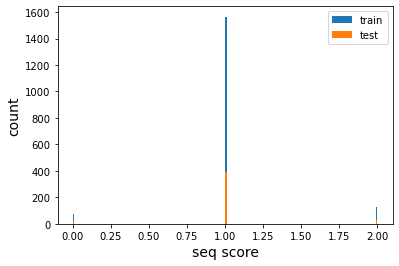

/home/ubuntu/anaconda3/envs/torchp/lib/python3.7/site-packages/ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  del sys.path[0]
/home/ubuntu/anaconda3/envs/torchp/lib/python3.7/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


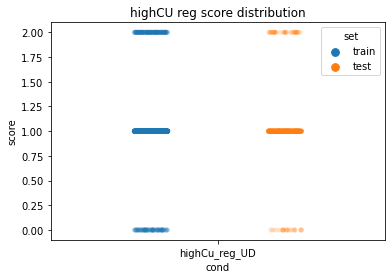

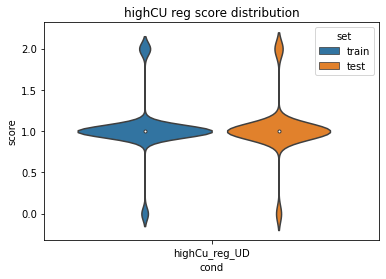

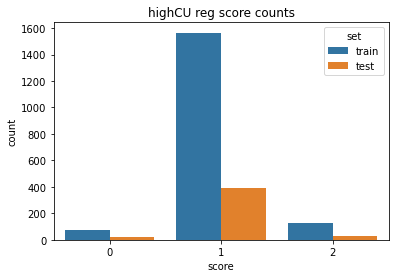


_____Split 1____
Train: 1    1565
2     127
0      76
Name: highCu_reg_UD, dtype: int64
Test: 1    392
2     31
0     19
Name: highCu_reg_UD, dtype: int64


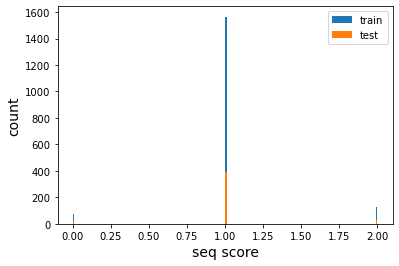

/home/ubuntu/anaconda3/envs/torchp/lib/python3.7/site-packages/ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  del sys.path[0]
/home/ubuntu/anaconda3/envs/torchp/lib/python3.7/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


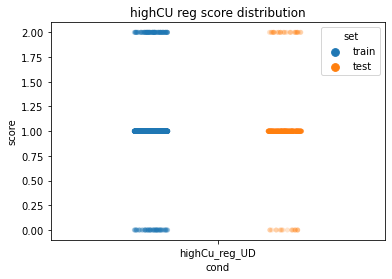

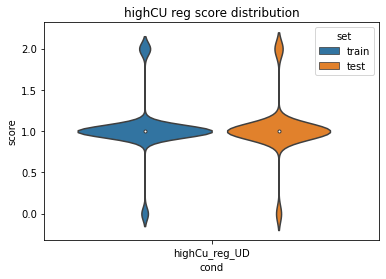

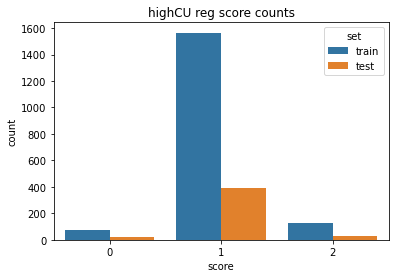


_____Split 2____
Train: 1    1566
2     126
0      76
Name: highCu_reg_UD, dtype: int64
Test: 1    391
2     32
0     19
Name: highCu_reg_UD, dtype: int64


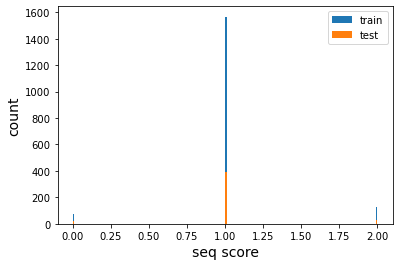

/home/ubuntu/anaconda3/envs/torchp/lib/python3.7/site-packages/ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  del sys.path[0]
/home/ubuntu/anaconda3/envs/torchp/lib/python3.7/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


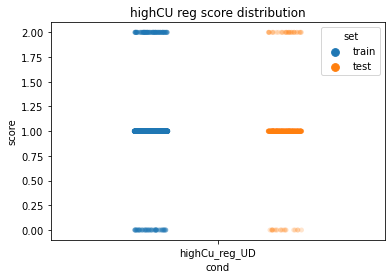

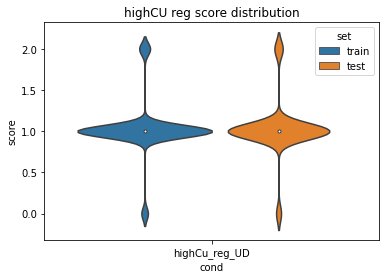

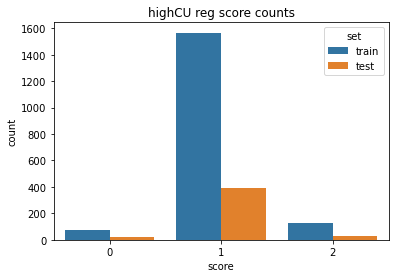


_____Split 3____
Train: 1    1566
2     126
0      76
Name: highCu_reg_UD, dtype: int64
Test: 1    391
2     32
0     19
Name: highCu_reg_UD, dtype: int64


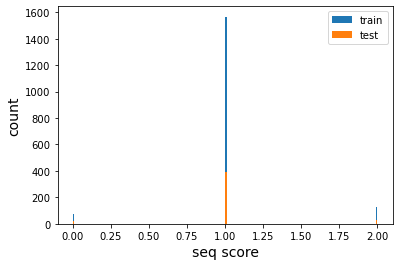

/home/ubuntu/anaconda3/envs/torchp/lib/python3.7/site-packages/ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  del sys.path[0]
/home/ubuntu/anaconda3/envs/torchp/lib/python3.7/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


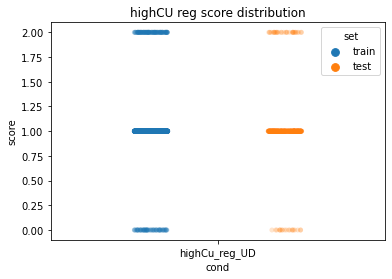

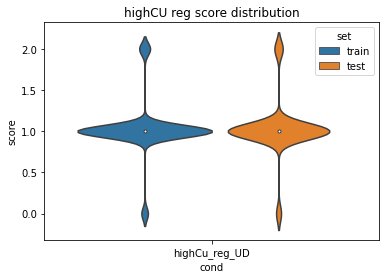

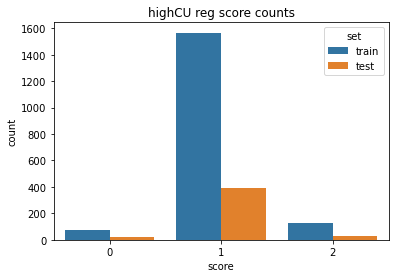


_____Split 4____
Train: 1    1566
2     126
0      76
Name: highCu_reg_UD, dtype: int64
Test: 1    391
2     32
0     19
Name: highCu_reg_UD, dtype: int64


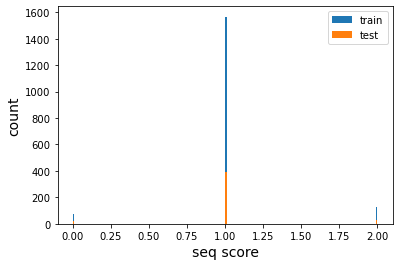

/home/ubuntu/anaconda3/envs/torchp/lib/python3.7/site-packages/ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  del sys.path[0]
/home/ubuntu/anaconda3/envs/torchp/lib/python3.7/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


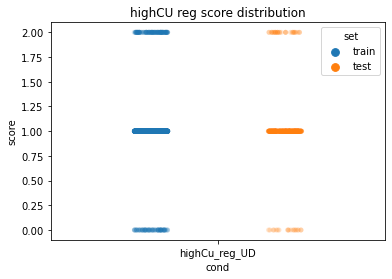

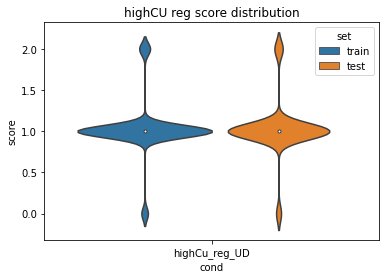

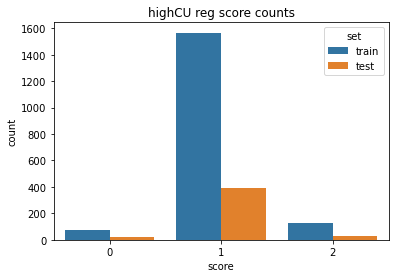

In [65]:
skf = StratifiedKFold(n_splits=5,shuffle=True)
score_col = 'highCu_reg_UD'

for i, (train_idxs, test_idxs) in enumerate(skf.split(XYdf, XYdf[score_col])):
    print(f"_____Split {i}____")
    cu_train_df = XYdf.iloc[train_idxs]
    cu_test_df = XYdf.iloc[test_idxs]
    print("Train:",cu_train_df['highCu_reg_UD'].value_counts())
    print("Test:",cu_test_df['highCu_reg_UD'].value_counts())

    plot_train_test_hist(cu_train_df, cu_test_df,score_col=score_col,bins=200)
    view_train_test_dist(cu_train_df, cu_test_df,[score_col],"highCU reg score",id_col='locus_tag')
    
    print("")
    
    cu_split_dfs = {
        'train':cu_train_df,
        'test':cu_train_df
    }
    
    cu_train_df.to_csv(f'data/5g_UDCu_splits/cv{i}_train.tsv',index=False,sep='\t')
    cu_test_df.to_csv(f'data/5g_UDCu_splits/cv{i}_test.tsv',index=False,sep='\t')

In [67]:
cu_train_df

og_index      locus_tag  \
0            0  EQU24_RS00005   
1            1  EQU24_RS00010   
3            4  EQU24_RS00035   
5           12  EQU24_RS00080   
6           13  EQU24_RS00085   
...        ...            ...   
2204      4176  EQU24_RS23115   
2206      4182  EQU24_RS23145   
2207      4184  EQU24_RS23155   
2208      4186  EQU24_RS23165   
2209      4187  EQU24_RS23170   

                                        upstream_region      uMax  \
0     ACTGTTAGCTTGGCACGGCCCTTGGCTCTGCGGGCGTTAAGGACTT...  0.333441   
1     GTGGACGCGATCACACCACGGTTATTAATGCTTGTAAACGCATTGC...  0.179318   
3     GTATAAACCATGAAAGTCAGCCTATTTCGAAGATACCGACACCCTA...  0.193539   
5     CCCAGACTGAACGCAACAGGATCGATATTAGGATAAGTCAGCATTT...  0.511466   
6     TTACCGGGCCGGATTTTTTGACATAGTTCGTTTAGGGTTGGCAATT...  0.740319   
...                                                 ...       ...   
2204  TTCAAATCTTGCTTTGAGTCAGTAAATAGTAAGGTACTTTTGTTAA...  0.946831   
2206  TTCCGAAAATAAATTGATTTCAAGCGATATACGGGTAGTCGGGTTA...  0.620221   
2207  TTCCGAAAATAAATTGATTTCAAGCGATATACGGGTAGTCGGGTTA...  0.609995   
2208  TTGAAACCCTAAGGTACATTGAGGCGTTAGCAAAGAGCAAGTTTGA...  0.605448   
2209  AATCTTCATTAGAGTCGAACGAAGTTTCATGTTTTCGGCTTCCTCA...  0.604488   

      lowO2_fast_growth    lowCH4      MeOH  NoCu     medCu    highCu  ...  \
0             -0.087509 -0.248330 -0.654293   0.0  0.252788  0.260753  ...   
1             -0.183682 -0.493245 -1.323530   0.0  0.418315  0.611021  ...   
3              0.035923  0.136026 -0.642058   0.0  0.189394  0.345084  ...   
5             -0.169779 -0.228529 -0.178561   0.0  0.093169  0.023929  ...   
6              0.089523  0.033533 -0.419899   0.0  0.811799  0.821546  ...   
...                 ...       ...       ...   ...       ...       ...  ...   
2204           0.482641  0.497547  0.324126   0.0  0.257141  0.176458  ...   
2206           0.718300  0.245892 -1.598809   0.0  0.171579  0.501296  ...   
2207           0.702416  0.231606 -1.614646   0.0  0.154029  0.483579  ...   
2208           0.688065  0.233752 -1.594922   0.0  0.171939  0.486032  ...   
2209           0.196871 -0.261330  0.125607   0.0 -0.014653  0.229101  ...   

      LanzaTech    aa3_KO  crotonic_acid  CH4_500ppm  CH4_1000ppm  gene  \
0     -0.516711 -0.472602       0.058102    0.668619     0.215153  dnaA   
1      0.237179 -0.079076       0.132689   -0.462317    -0.490073  dnaN   
3     -0.952383 -0.465515       0.009531    0.367039     0.695145   NaN   
5     -1.157175 -0.792139       0.052329    0.342699     0.193055   NaN   
6      0.145508  0.251882       1.126993   -0.156899    -0.163949   lgt   
...         ...       ...            ...         ...          ...   ...   
2204   0.695719 -0.128286       1.279768    1.762063     1.280904   NaN   
2206   0.701928  1.577361       0.777911    0.463434     0.727701  hxlA   
2207   0.701457  1.573150       0.761210    0.433925     0.705205  hxlA   
2208   0.708730  1.520411       0.769644    0.032260     0.305817  hxlA   
2209   0.265191 -0.870372       0.814080   -0.245552    -0.285502   NaN   

                                             product  type  highCu_reg_UD  \
0     chromosomal replication initiator protein DnaA   CDS              1   
1                    DNA polymerase III subunit beta   CDS              2   
3                               hypothetical protein   CDS              1   
5                               2OG-Fe(II) oxygenase   CDS              1   
6          prolipoprotein diacylglyceryl transferase   CDS              2   
...                                              ...   ...            ...   
2204                            hypothetical protein   CDS              1   
2206                 3-hexulose-6-phosphate synthase   CDS              1   
2207                 3-hexulose-6-phosphate synthase   CDS              1   
2208                 3-hexulose-6-phosphate synthase   CDS              1   
2209                                     transposase   CDS              1   

        set  
0  

## Train a cold model on CU classification

In [68]:
target_col = 'highCu_reg_UD'
cu_sampler = tu.make_weighted_sampler(cu_train_df,target_col)

cu_dls = tu.build_dataloaders_single(
                cu_train_df, 
                cu_test_df, 
                dataset_types, # just OHE for now
                seq_col='upstream_region',
                target_col=target_col,
                sampler=cu_sampler,
                shuffle=False,
            )
cu_ohe_train_dl,cu_ohe_val_dl = cu_dls['ohe']

E:176 | train loss:0.050 | val loss: 0.903:   4%|▎         | 176/5000 [00:13<06:21, 12.65it/s]

EarlyStopping counter: 125 out of 500


E:301 | train loss:0.028 | val loss: 1.076:   6%|▌         | 302/5000 [00:23<06:04, 12.90it/s]

EarlyStopping counter: 250 out of 500


E:426 | train loss:0.014 | val loss: 1.181:   9%|▊         | 426/5000 [00:33<06:00, 12.67it/s]

EarlyStopping counter: 375 out of 500


E:549 | train loss:0.009 | val loss: 1.227:  11%|█         | 549/5000 [00:43<05:50, 12.69it/s]


EarlyStopping counter: 500 out of 500
Early stopping


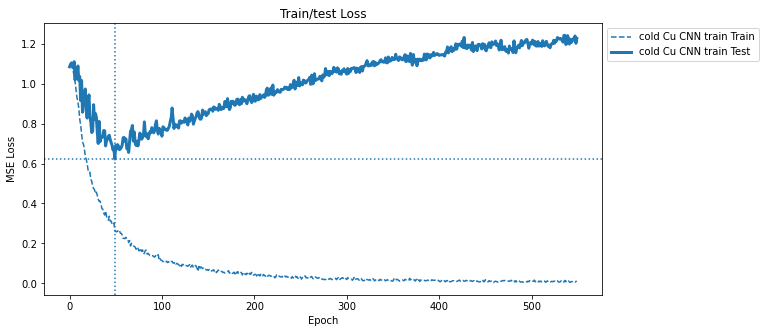

In [69]:
cnn10_name = "cold Cu CNN train"

model10 = m.DNA_2CNN_2FC_Multi(seq_len, 3,**m_kwargs)

model_res[cnn10_name] = collect_model_stats(
    cnn10_name,
    seq_len,
    cu_ohe_train_dl,
    cu_ohe_val_dl,
    lr=0.0001,
    ep=5000,
    pat=500,
    opt=torch.optim.Adam,
    model=model10,
)

Running cold Cu CNN train


model_name  split  mac_precision  mac_recall    mac_f1  support
0  cold Cu CNN train  train       0.793548    0.955969  0.859095     1768
1  cold Cu CNN train   test       0.411881    0.379704  0.390265      442

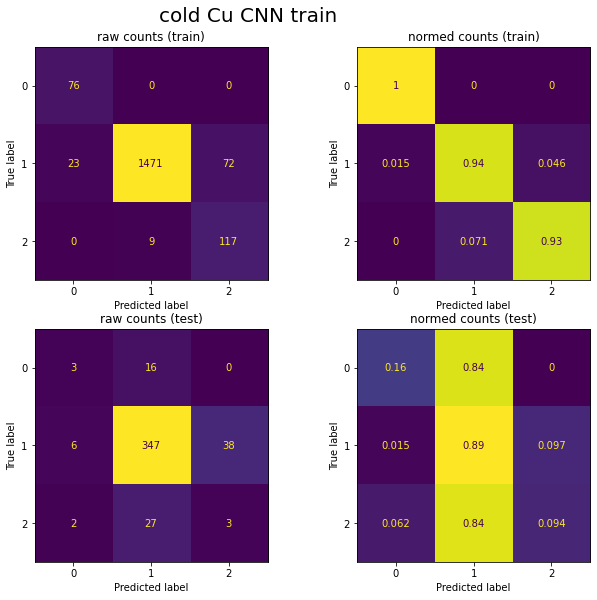

In [70]:
seq_list = [
    (cu_train_df["upstream_region"].values,cu_train_df[target_col],"train"),
    (cu_test_df["upstream_region"].values,cu_test_df[target_col],"test")
]

pred_dfs[cnn10_name] = get_confusion_stats(
    model_res[cnn10_name]['model'],
    model_res[cnn10_name]['model_name'],
    seq_list,
    title=cnn10_name
)

pred_dfs[cnn10_name]

## Train a warm start model on CU classification

In [71]:
model11 = m.DNA_2CNN_2FC_Multi(seq_len, 3,**m_kwargs)
model11.load_state_dict(extracted_layers,strict=False)

_IncompatibleKeys(missing_keys=['conv_net.12.weight', 'conv_net.12.bias'], unexpected_keys=[])

In [72]:
model11

DNA_2CNN_2FC_Multi(
  (conv_net): Sequential(
    (0): Conv2d(1, 32, kernel_size=(4, 10), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=(1, 2), stride=(1, 2), padding=0, dilation=1, ceil_mode=False)
    (3): Dropout(p=0.25, inplace=False)
    (4): Conv2d(32, 32, kernel_size=(1, 6), stride=(1, 1))
    (5): ReLU()
    (6): Dropout(p=0.2, inplace=False)
    (7): Flatten()
    (8): Linear(in_features=4480, out_features=50, bias=True)
    (9): ReLU()
    (10): Linear(in_features=50, out_features=50, bias=True)
    (11): ReLU()
    (12): Linear(in_features=50, out_features=3, bias=True)
  )
)

E:200 | train loss:0.045 | val loss: 0.862:   4%|▍         | 201/5000 [00:16<06:22, 12.53it/s]

EarlyStopping counter: 125 out of 500


E:325 | train loss:0.019 | val loss: 1.021:   6%|▋         | 325/5000 [00:26<06:03, 12.88it/s]

EarlyStopping counter: 250 out of 500


E:450 | train loss:0.010 | val loss: 1.146:   9%|▉         | 451/5000 [00:35<05:51, 12.93it/s]

EarlyStopping counter: 375 out of 500


E:573 | train loss:0.006 | val loss: 1.219:  11%|█▏        | 573/5000 [00:45<05:52, 12.57it/s]


EarlyStopping counter: 500 out of 500
Early stopping


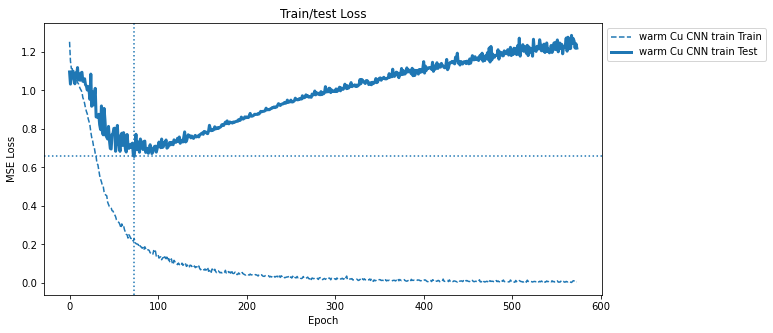

Running warm Cu CNN train


model_name  split  mac_precision  mac_recall    mac_f1  support
0  warm Cu CNN train  train       0.785658    0.978289  0.860500     1768
1  warm Cu CNN train   test       0.378766    0.385858  0.381414      442

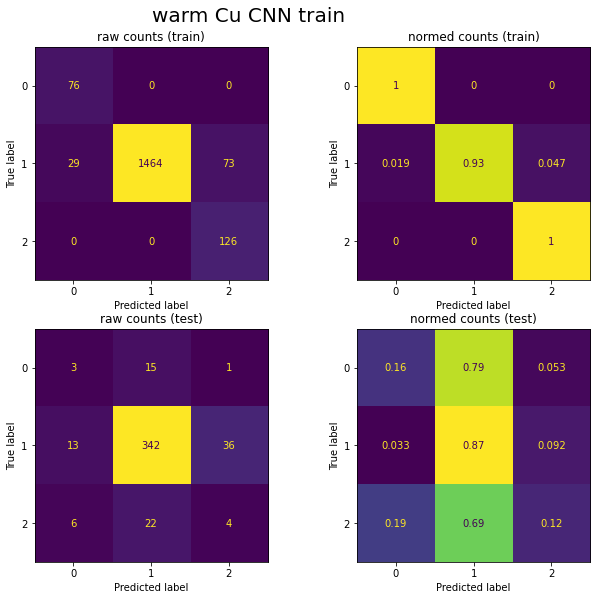

In [73]:
cnn11_name = "warm Cu CNN train"

model_res[cnn11_name] = collect_model_stats(
    cnn11_name,
    seq_len,
    cu_ohe_train_dl,
    cu_ohe_val_dl,
    lr=0.0001,
    ep=5000,
    pat=500,
    opt=torch.optim.Adam,
    model=model11,
)

pred_dfs[cnn11_name] = get_confusion_stats(
    model_res[cnn11_name]['model'],
    model_res[cnn11_name]['model_name'],
    seq_list,
    title=cnn11_name
)

pred_dfs[cnn11_name]


In [89]:
model12 = m.DNA_2CNN_2FC_Multi(seq_len, 3,**m_kwargs)
model12.load_state_dict(extracted_layers,strict=False)

opt12 = torch.optim.Adam(model12.parameters())
opt12.load_state_dict(torch.load('saved_models/5org_cls_cv0_opt_state_dict.pt'))

In [94]:
opt12.state_dict()['param_groups']

[{'lr': 0.0001,
  'betas': (0.9, 0.999),
  'eps': 1e-08,
  'weight_decay': 0,
  'amsgrad': False,
  'params': [140664006167120,
   140664006164800,
   140664005052768,
   140664005054208,
   140664005051328,
   140664005051248,
   140664005053328,
   140664005051728,
   140664005052128,
   140664005052608]}]

In [96]:
# warm start opt too?

# model12 = m.DNA_2CNN_2FC_Multi(seq_len, 3,**m_kwargs)
# model12.load_state_dict(extracted_layers,strict=False)

# #opt12 = torch.optim.Adam(model12.parameters())
# #opt12.load_state_dict(torch.load('saved_models/5org_cls_cv0_opt_state_dict.pt'))
# opt12_path = 'saved_models/5org_cls_cv0_opt_state_dict.pt'

# cnn12_name = "warm Cu CNN, warm opt train"

# model_res[cnn12_name] = collect_model_stats(
#     cnn12_name,
#     seq_len,
#     cu_ohe_train_dl,
#     cu_ohe_val_dl,
#     lr=0.0001,
#     ep=5000,
#     pat=500,
#     opt=torch.optim.Adam,#model_res[cnn1_name]['opt'],
#     opt_warm=opt12_path,
#     model=model12,
# )

# pred_dfs[cnn12_name] = get_confusion_stats(
#     model_res[cnn12_name]['model'],
#     model_res[cnn12_name]['model_name'],
#     seq_list,
#     title=cnn12_name
# )

# pred_dfs[cnn12_name]



In [95]:
# Can't figure out how to warm start the optimizer... maybes its not needed...?

# 5-fold warm start

Running CV0


E:207 | train loss:0.032 | val loss: 0.903:   4%|▍         | 208/5000 [00:16<06:11, 12.90it/s]

EarlyStopping counter: 125 out of 500


E:332 | train loss:0.010 | val loss: 1.058:   7%|▋         | 332/5000 [00:25<05:58, 13.02it/s]

EarlyStopping counter: 250 out of 500


E:457 | train loss:0.005 | val loss: 1.170:   9%|▉         | 458/5000 [00:35<05:47, 13.06it/s]

EarlyStopping counter: 375 out of 500


E:580 | train loss:0.013 | val loss: 1.215:  12%|█▏        | 580/5000 [00:44<05:42, 12.92it/s]


EarlyStopping counter: 500 out of 500
Early stopping


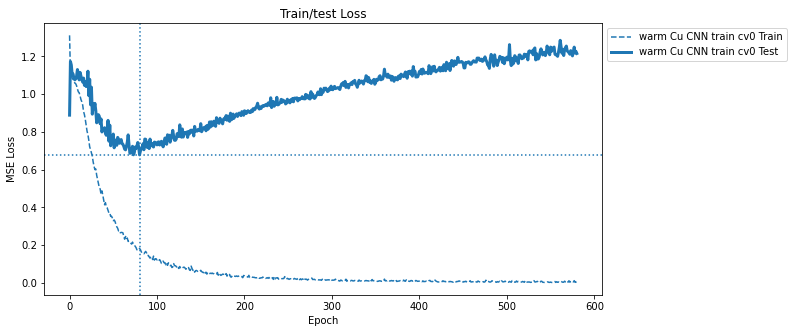

Running warm Cu CNN train cv0
Running CV1


E:198 | train loss:0.032 | val loss: 0.797:   4%|▍         | 198/5000 [00:15<06:04, 13.17it/s]

EarlyStopping counter: 125 out of 500


E:323 | train loss:0.011 | val loss: 0.988:   6%|▋         | 324/5000 [00:24<06:02, 12.89it/s]

EarlyStopping counter: 250 out of 500


E:448 | train loss:0.003 | val loss: 1.192:   9%|▉         | 448/5000 [00:34<05:51, 12.93it/s]

EarlyStopping counter: 375 out of 500


E:571 | train loss:0.002 | val loss: 1.298:  11%|█▏        | 571/5000 [00:43<05:39, 13.04it/s]


EarlyStopping counter: 500 out of 500
Early stopping


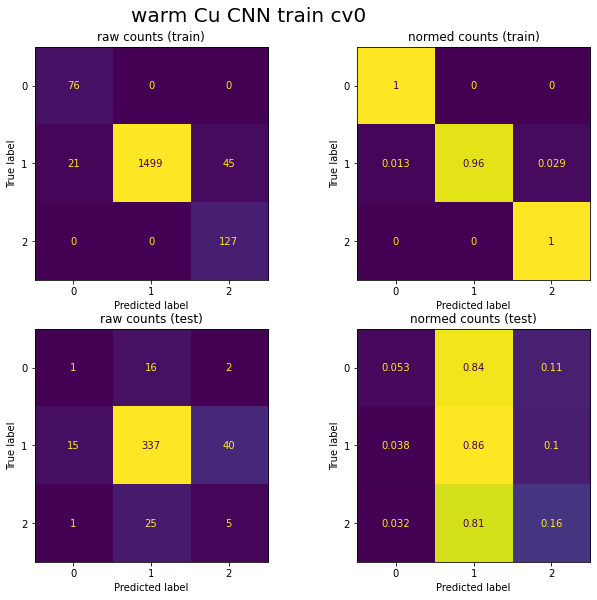

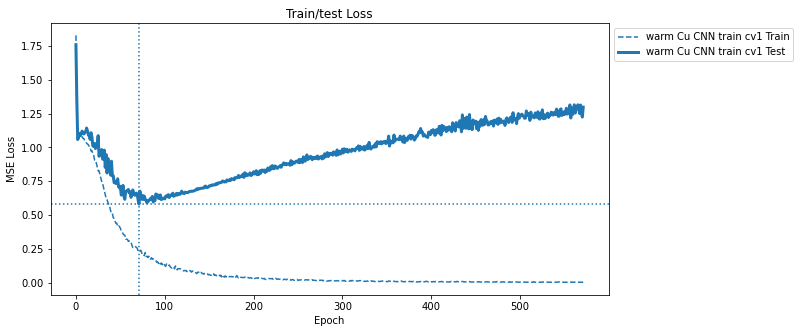

Running warm Cu CNN train cv1
Running CV2


E:185 | train loss:0.042 | val loss: 0.876:   4%|▎         | 186/5000 [00:14<06:09, 13.04it/s]

EarlyStopping counter: 125 out of 500


E:310 | train loss:0.018 | val loss: 1.048:   6%|▌         | 310/5000 [00:23<05:56, 13.16it/s]

EarlyStopping counter: 250 out of 500


E:435 | train loss:0.008 | val loss: 1.199:   9%|▊         | 436/5000 [00:33<05:48, 13.11it/s]

EarlyStopping counter: 375 out of 500


E:558 | train loss:0.006 | val loss: 1.279:  11%|█         | 558/5000 [00:42<05:39, 13.07it/s]


EarlyStopping counter: 500 out of 500
Early stopping


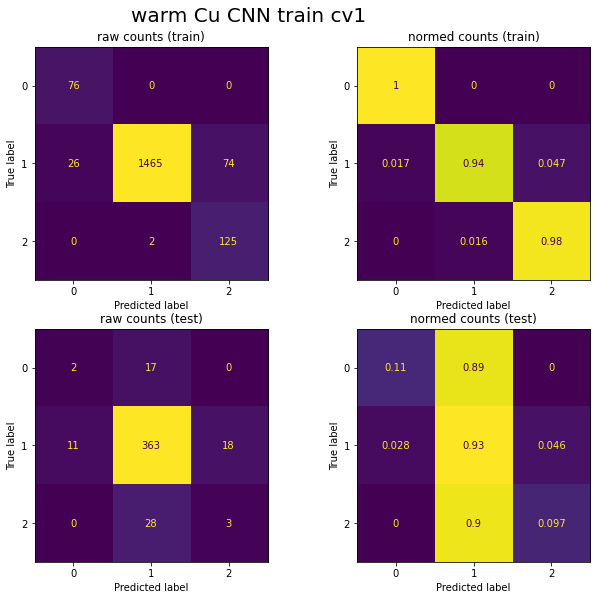

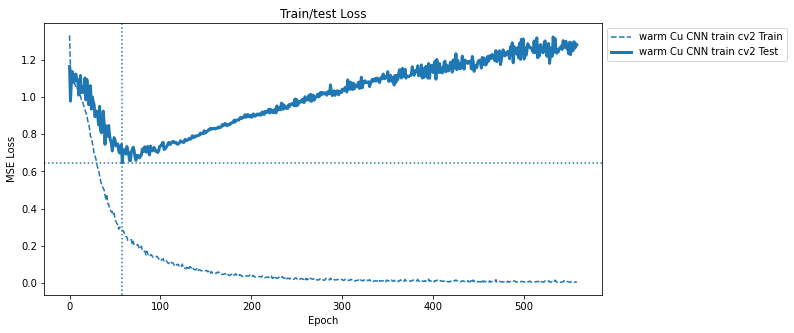

Running warm Cu CNN train cv2
Running CV3


E:198 | train loss:0.033 | val loss: 1.007:   4%|▍         | 199/5000 [00:15<06:05, 13.15it/s]

EarlyStopping counter: 125 out of 500


E:323 | train loss:0.016 | val loss: 1.178:   6%|▋         | 323/5000 [00:24<05:57, 13.09it/s]

EarlyStopping counter: 250 out of 500


E:448 | train loss:0.005 | val loss: 1.311:   9%|▉         | 449/5000 [00:34<05:53, 12.87it/s]

EarlyStopping counter: 375 out of 500


E:571 | train loss:0.012 | val loss: 1.406:  11%|█▏        | 571/5000 [00:44<05:41, 12.97it/s]


EarlyStopping counter: 500 out of 500
Early stopping


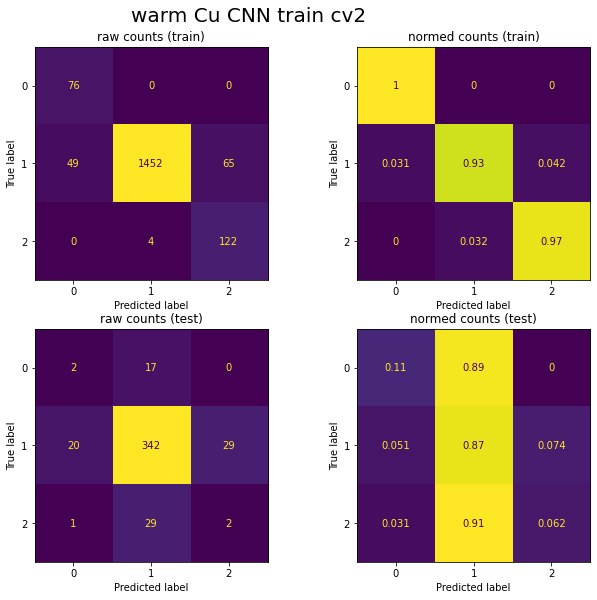

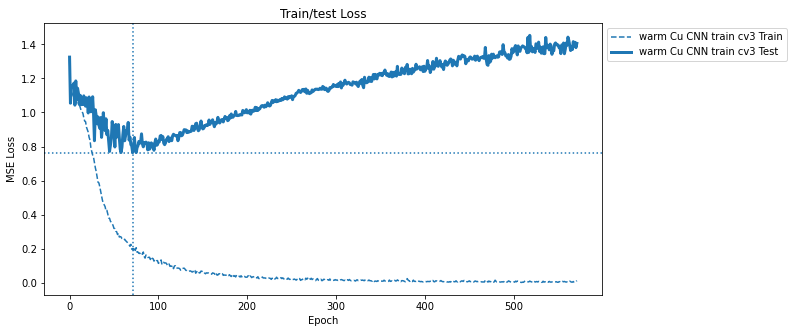

Running warm Cu CNN train cv3
Running CV4


E:199 | train loss:0.020 | val loss: 0.824:   4%|▍         | 200/5000 [00:15<06:07, 13.07it/s]

EarlyStopping counter: 125 out of 500


E:324 | train loss:0.007 | val loss: 0.962:   6%|▋         | 324/5000 [00:24<05:54, 13.17it/s]

EarlyStopping counter: 250 out of 500


E:449 | train loss:0.003 | val loss: 1.055:   9%|▉         | 450/5000 [00:34<05:44, 13.20it/s]

EarlyStopping counter: 375 out of 500


E:572 | train loss:0.003 | val loss: 1.157:  11%|█▏        | 572/5000 [00:43<05:37, 13.11it/s]


EarlyStopping counter: 500 out of 500
Early stopping


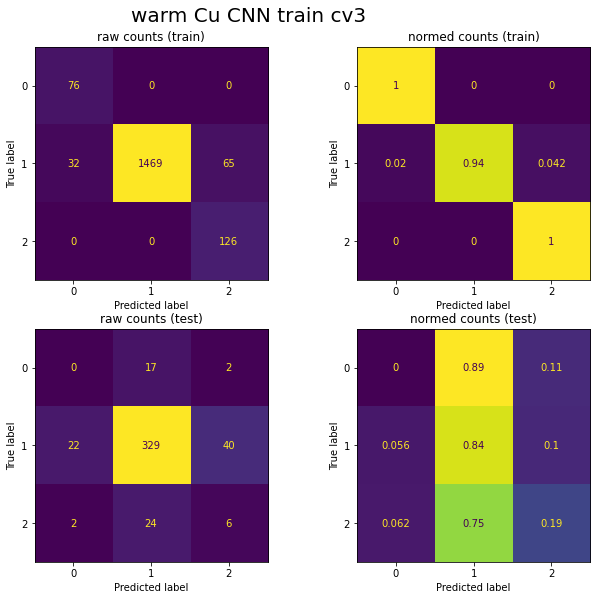

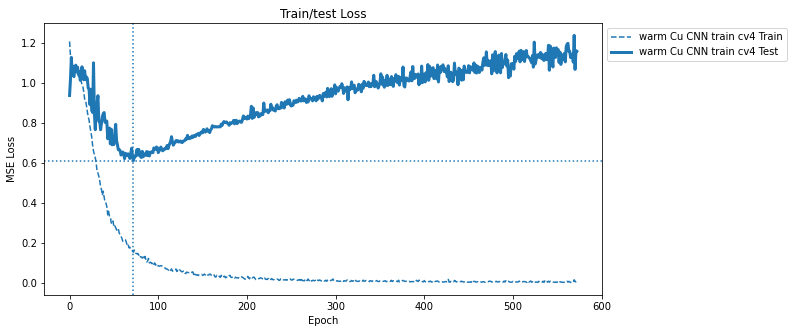

Running warm Cu CNN train cv4


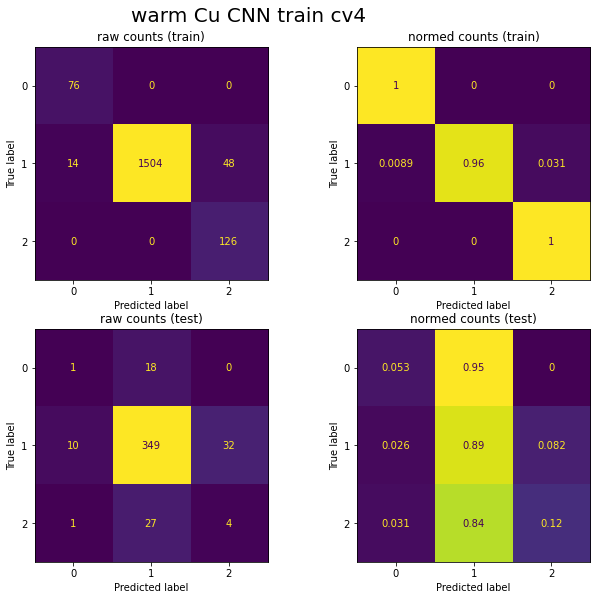

In [98]:
cv_names = []
for i in [0,1,2,3,4]:
    print(f"Running CV{i}")
    cu_train_df = pd.read_csv(f'data/5g_UDCu_splits/cv{i}_train.tsv',sep='\t')
    cu_test_df = pd.read_csv(f'data/5g_UDCu_splits/cv{i}_test.tsv',sep='\t')
    
    target_col = 'highCu_reg_UD'
    cu_sampler = tu.make_weighted_sampler(cu_train_df,target_col)

    cu_dls = tu.build_dataloaders_single(
                    cu_train_df, 
                    cu_test_df, 
                    dataset_types, # just OHE for now
                    seq_col='upstream_region',
                    target_col=target_col,
                    sampler=cu_sampler,
                    shuffle=False,
                )
    cu_ohe_train_dl,cu_ohe_val_dl = cu_dls['ohe']
    
    model_cv = m.DNA_2CNN_2FC_Multi(seq_len, 3,**m_kwargs)
    model_cv.load_state_dict(extracted_layers,strict=False)
    
    cnn_cv_name = f"warm Cu CNN train cv{i}"

    model_res[cnn_cv_name] = collect_model_stats(
        cnn_cv_name,
        seq_len,
        cu_ohe_train_dl,
        cu_ohe_val_dl,
        lr=0.0001,
        ep=5000,
        pat=500,
        opt=torch.optim.Adam,
        model=model_cv,
    )

    seq_list = [
        (cu_train_df["upstream_region"].values,cu_train_df[target_col],"train"),
        (cu_test_df["upstream_region"].values,cu_test_df[target_col],"test")
    ]
    
    pred_dfs[cnn_cv_name] = get_confusion_stats(
        model_res[cnn_cv_name]['model'],
        model_res[cnn_cv_name]['model_name'],
        seq_list,
        title=cnn_cv_name
    )

    cv_names.append(cnn_cv_name)

    

Running CV0


E:176 | train loss:0.042 | val loss: 1.007:   4%|▎         | 176/5000 [00:13<06:07, 13.14it/s]

EarlyStopping counter: 125 out of 500


E:301 | train loss:0.017 | val loss: 1.119:   6%|▌         | 302/5000 [00:23<05:59, 13.07it/s]

EarlyStopping counter: 250 out of 500


E:426 | train loss:0.015 | val loss: 1.221:   9%|▊         | 426/5000 [00:32<05:47, 13.17it/s]

EarlyStopping counter: 375 out of 500


E:549 | train loss:0.004 | val loss: 1.276:  11%|█         | 549/5000 [00:42<05:41, 13.03it/s]


EarlyStopping counter: 500 out of 500
Early stopping


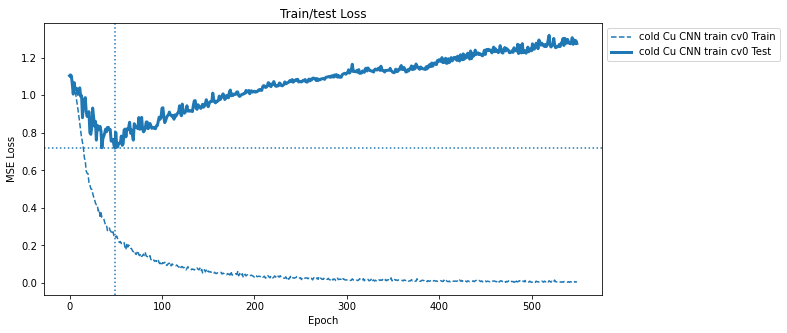

Running cold Cu CNN train cv0
Running CV1


E:187 | train loss:0.057 | val loss: 0.783:   4%|▍         | 188/5000 [00:14<06:14, 12.85it/s]

EarlyStopping counter: 125 out of 500


E:312 | train loss:0.010 | val loss: 0.933:   6%|▌         | 312/5000 [00:24<06:01, 12.96it/s]

EarlyStopping counter: 250 out of 500


E:437 | train loss:0.009 | val loss: 1.009:   9%|▉         | 438/5000 [00:34<05:55, 12.85it/s]

EarlyStopping counter: 375 out of 500


E:560 | train loss:0.004 | val loss: 1.072:  11%|█         | 560/5000 [00:43<05:45, 12.84it/s]


EarlyStopping counter: 500 out of 500
Early stopping


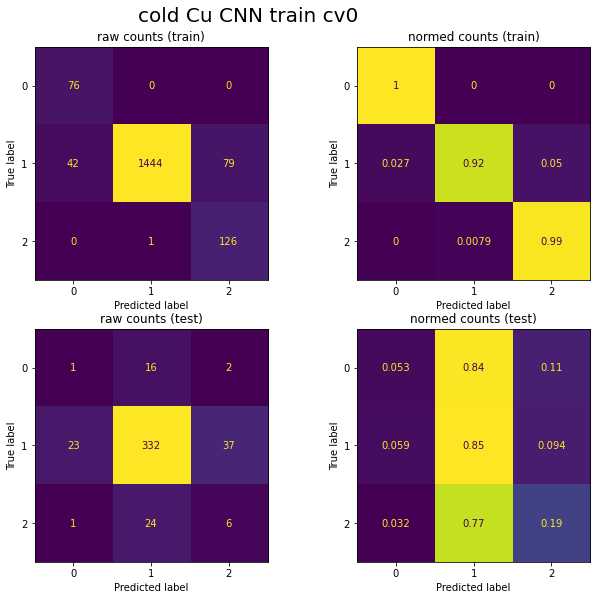

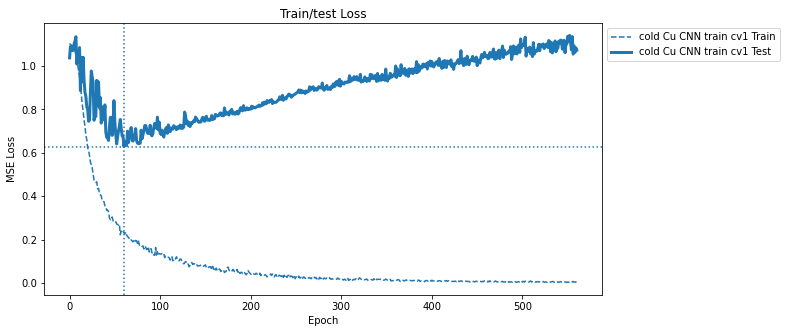

Running cold Cu CNN train cv1
Running CV2


E:167 | train loss:0.063 | val loss: 0.825:   3%|▎         | 168/5000 [00:13<06:09, 13.09it/s]

EarlyStopping counter: 125 out of 500


E:292 | train loss:0.020 | val loss: 0.943:   6%|▌         | 292/5000 [00:22<06:08, 12.79it/s]

EarlyStopping counter: 250 out of 500


E:417 | train loss:0.011 | val loss: 1.052:   8%|▊         | 418/5000 [00:32<05:53, 12.97it/s]

EarlyStopping counter: 375 out of 500


E:540 | train loss:0.012 | val loss: 1.051:  11%|█         | 540/5000 [00:41<05:45, 12.92it/s]


EarlyStopping counter: 500 out of 500
Early stopping


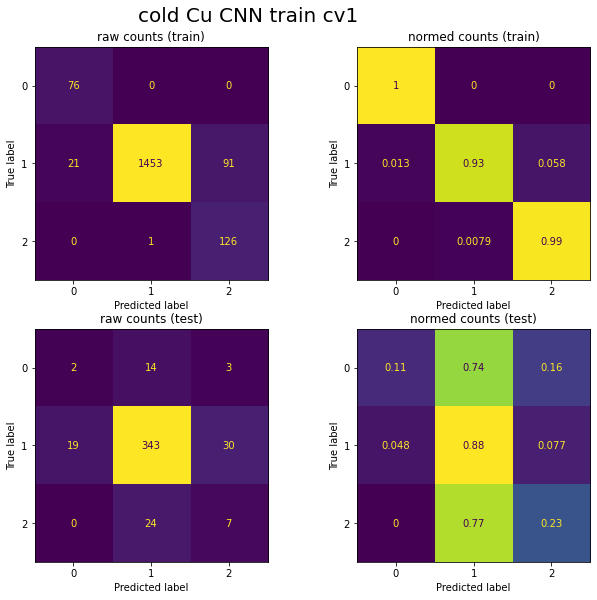

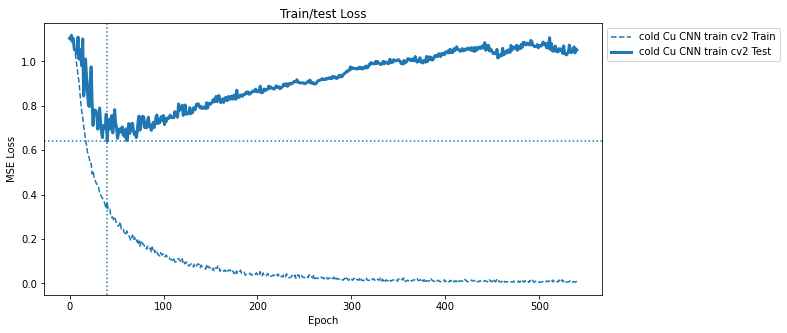

Running cold Cu CNN train cv2
Running CV3


E:153 | train loss:0.057 | val loss: 0.938:   3%|▎         | 154/5000 [00:11<06:08, 13.16it/s]

EarlyStopping counter: 125 out of 500


E:278 | train loss:0.024 | val loss: 1.081:   6%|▌         | 278/5000 [00:21<05:58, 13.15it/s]

EarlyStopping counter: 250 out of 500


E:403 | train loss:0.012 | val loss: 1.199:   8%|▊         | 404/5000 [00:30<05:51, 13.09it/s]

EarlyStopping counter: 375 out of 500


E:526 | train loss:0.009 | val loss: 1.236:  11%|█         | 526/5000 [00:40<05:43, 13.04it/s]


EarlyStopping counter: 500 out of 500
Early stopping


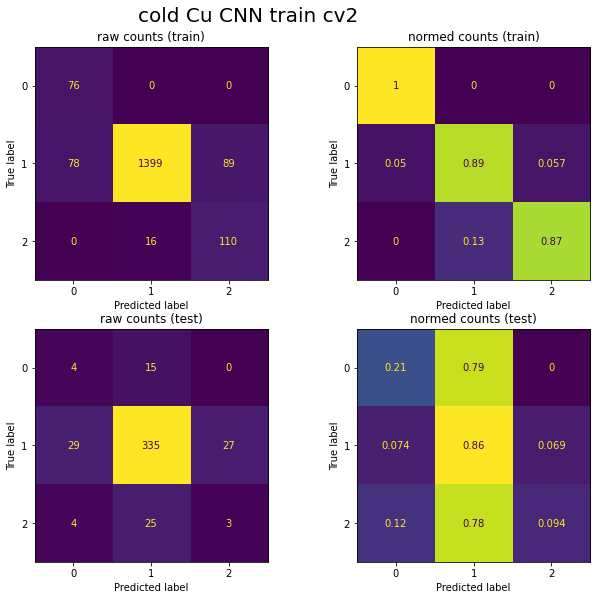

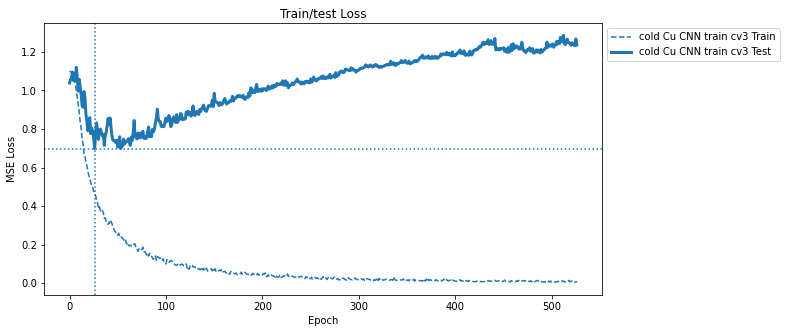

Running cold Cu CNN train cv3
Running CV4


E:171 | train loss:0.066 | val loss: 0.916:   3%|▎         | 172/5000 [00:13<06:12, 12.96it/s]

EarlyStopping counter: 125 out of 500


E:296 | train loss:0.026 | val loss: 1.063:   6%|▌         | 296/5000 [00:22<05:57, 13.16it/s]

EarlyStopping counter: 250 out of 500


E:421 | train loss:0.009 | val loss: 1.155:   8%|▊         | 422/5000 [00:32<05:53, 12.96it/s]

EarlyStopping counter: 375 out of 500


E:544 | train loss:0.011 | val loss: 1.212:  11%|█         | 544/5000 [00:41<05:42, 13.01it/s]


EarlyStopping counter: 500 out of 500
Early stopping


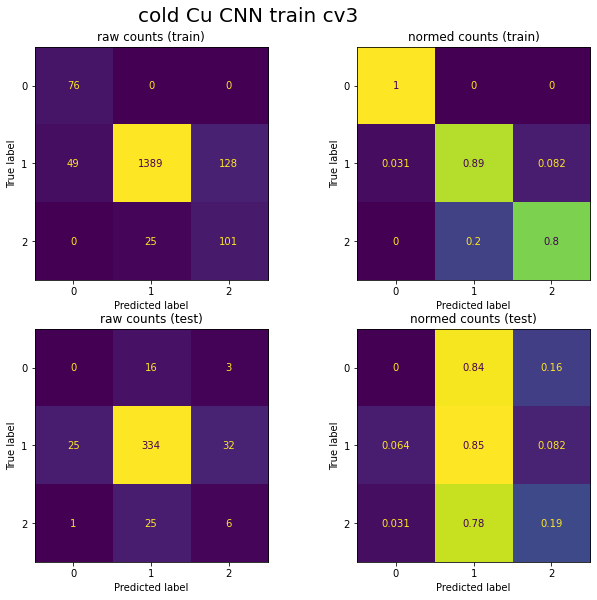

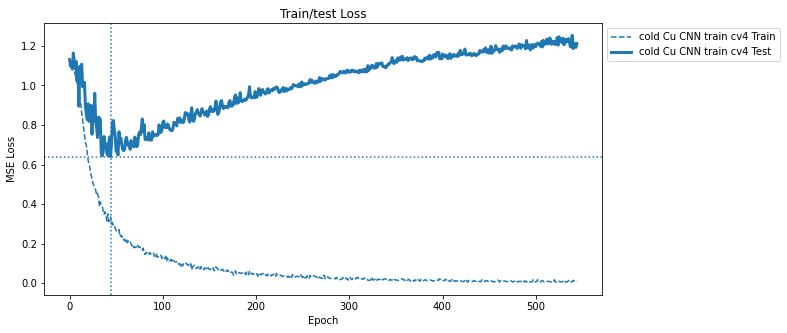

Running cold Cu CNN train cv4


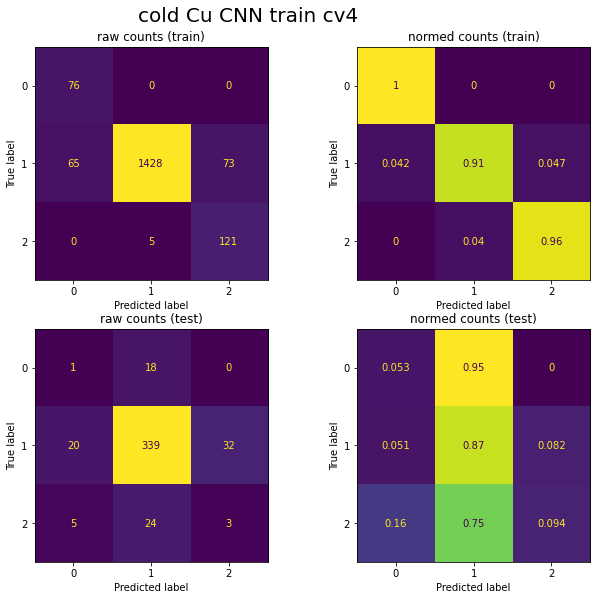

In [99]:
# COLD STARTS

for i in [0,1,2,3,4]:
    print(f"Running CV{i}")
    cu_train_df = pd.read_csv(f'data/5g_UDCu_splits/cv{i}_train.tsv',sep='\t')
    cu_test_df = pd.read_csv(f'data/5g_UDCu_splits/cv{i}_test.tsv',sep='\t')
    
    target_col = 'highCu_reg_UD'
    cu_sampler = tu.make_weighted_sampler(cu_train_df,target_col)

    cu_dls = tu.build_dataloaders_single(
                    cu_train_df, 
                    cu_test_df, 
                    dataset_types, # just OHE for now
                    seq_col='upstream_region',
                    target_col=target_col,
                    sampler=cu_sampler,
                    shuffle=False,
                )
    cu_ohe_train_dl,cu_ohe_val_dl = cu_dls['ohe']
    
    model_cv = m.DNA_2CNN_2FC_Multi(seq_len, 3,**m_kwargs)
    #model_cv.load_state_dict(extracted_layers,strict=False)
    
    cnn_cv_name = f"cold Cu CNN train cv{i}"

    model_res[cnn_cv_name] = collect_model_stats(
        cnn_cv_name,
        seq_len,
        cu_ohe_train_dl,
        cu_ohe_val_dl,
        lr=0.0001,
        ep=5000,
        pat=500,
        opt=torch.optim.Adam,
        model=model_cv,
    )
    seq_list = [
        (cu_train_df["upstream_region"].values,cu_train_df[target_col],"train"),
        (cu_test_df["upstream_region"].values,cu_test_df[target_col],"test")
    ]
    
    pred_dfs[cnn_cv_name] = get_confusion_stats(
        model_res[cnn_cv_name]['model'],
        model_res[cnn_cv_name]['model_name'],
        seq_list,
        title=cnn_cv_name
    )

    cv_names.append(cnn_cv_name)

In [ ]:
# PLOT WARMS VS COLDS

In [101]:
pred_dfs.keys()

dict_keys(['5org_cls_cnn', 'untrained_model', 'pred_shuffled_seq', 'reloaded saved CNN', 'warm model, 2 heads', 'warm model, new task, 2 heads', 'cold model, new task, 2 heads', 'untrained model, new task, 2 heads', 'cold Cu CNN train', 'warm Cu CNN train', 'warm Cu CNN train cv0', 'warm Cu CNN train cv1', 'warm Cu CNN train cv2', 'warm Cu CNN train cv3', 'warm Cu CNN train cv4', 'cold Cu CNN train cv0', 'cold Cu CNN train cv1', 'cold Cu CNN train cv2', 'cold Cu CNN train cv3', 'cold Cu CNN train cv4'])

In [107]:
warms = pd.concat([pred_dfs[x] for x in pred_dfs.keys() if x.startswith('warm Cu CNN train cv')])
warms['start'] = 'warm'
colds = pd.concat([pred_dfs[x] for x in pred_dfs.keys() if x.startswith('cold Cu CNN train cv')])
colds['start'] = 'cold'

In [108]:
wc_df = pd.concat([warms,colds])
wc_df

model_name  split  mac_precision  mac_recall    mac_f1  support  \
0  warm Cu CNN train cv0  train       0.840626    0.985942  0.902190     1768   
1  warm Cu CNN train cv0   test       0.352247    0.357872  0.353028      442   
0  warm Cu CNN train cv1  train       0.790625    0.973451  0.862388     1768   
1  warm Cu CNN train cv1   test       0.395470    0.376019  0.382628      442   
0  warm Cu CNN train cv2  train       0.752553    0.965152  0.832242     1768   
1  warm Cu CNN train cv2   test       0.344305    0.347481  0.345593      442   
0  warm Cu CNN train cv3  train       0.787797    0.979353  0.863026     1768   
1  warm Cu CNN train cv3   test       0.338063    0.342977  0.338217      442   
0  warm Cu CNN train cv4  train       0.856194    0.986803  0.911822     1768   
1  warm Cu CNN train cv4   test       0.360077    0.356738  0.357112      442   
0  cold Cu CNN train cv0  train       0.752670    0.971603  0.834003     1768   
1  cold Cu CNN train cv0   test       0.355269    0.364373  0.357486      442   
0  cold Cu CNN train cv1  train       0.787821    0.973520  0.857914     1768   
1  cold Cu CNN train cv1   test       0.390167    0.402023  0.394878      442   
0  cold Cu CNN train cv2  train       0.678321    0.922125  0.758801     1768   
1  cold Cu CNN train cv2   test       0.367147    0.387018  0.371435      442   
0  cold Cu CNN train cv3  train       0.677123    0.896187  0.752483     1768   
1  cold Cu CNN train cv3   test       0.345669    0.347240  0.345482      442   
0  cold Cu CNN train cv4  train       0.719743    0.957398  0.803009     1768   
1  cold Cu CNN train cv4   test       0.337980    0.337796  0.337412      442   

  start  
0  warm  
1  warm  
0  warm  
1  warm  
0  warm  
1  warm  
0  warm  
1  warm  
0  warm  
1  warm  
0  cold  
1  cold  
0  cold  
1  cold  
0  cold  
1  cold  
0  cold  
1  cold  
0  cold  
1  cold

In [115]:
def box_swarm_plot(df,metric,split,x_col,yrange=None):
    df_split = df[df['split']==split]
    
    fig = plt.figure(figsize=(5,5))
    #ax = sns.boxplot(data=df_split,x=x_col,y=metric,hue='model_name',dodge=True,boxprops=dict(alpha=.3))
    ax = sns.boxplot(data=df_split,x=x_col,y=metric,hue='start',dodge=True,boxprops=dict(alpha=.3))
    plt.setp(ax.collections,alpha=0.3)

    handles = ax.legend_.legendHandles
    labels = [text.get_text() for text in ax.legend_.texts]

    sns.swarmplot(data=df_split,x=x_col,y=metric,hue='start',
                  dodge=True,edgecolor='black',linewidth=1,ax=ax,size=8)

    plt.legend(handles, labels,loc='best')
    plt.ylim(yrange)
    plt.ylabel(f"{metric} score",fontsize=16)
    plt.xlabel(f"{x_col} variant",fontsize=16)
    plt.title(f"{split} set prediction results",fontsize=20)
    plt.show()

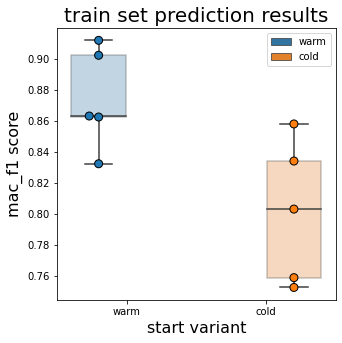

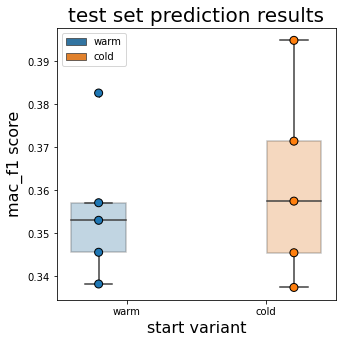

In [117]:
box_swarm_plot(wc_df,'mac_f1','train','start')
box_swarm_plot(wc_df,'mac_f1','test','start')

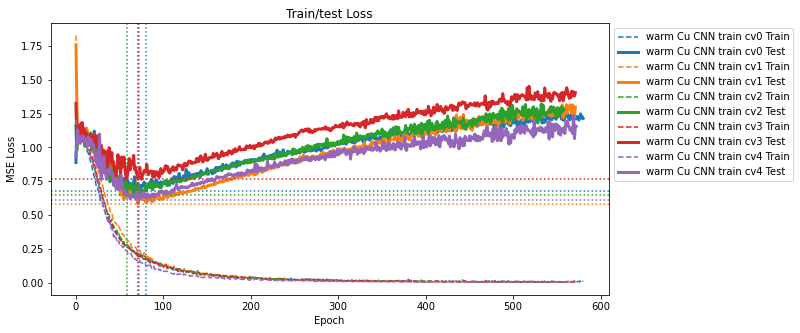

In [120]:
tu.quick_loss_plot([model_res[x]['data_label'][0] for x in warms['model_name'].unique()])

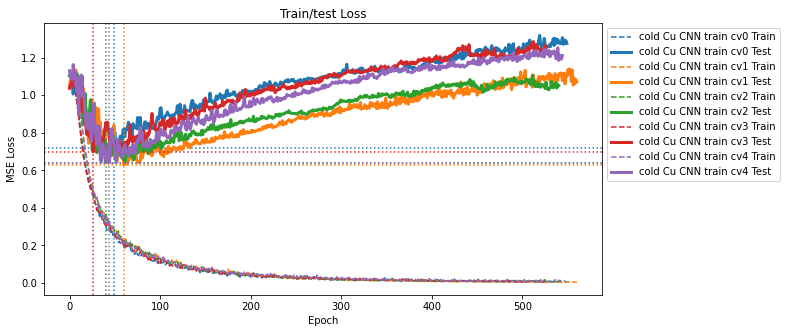

In [121]:
tu.quick_loss_plot([model_res[x]['data_label'][0] for x in colds['model_name'].unique()])

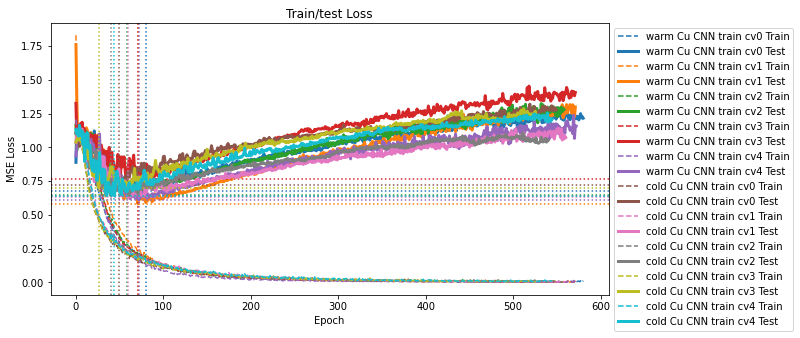

In [122]:
tu.quick_loss_plot([model_res[x]['data_label'][0] for x in wc_df['model_name'].unique()])

## Load 5G data

In [4]:
locus2info['EQU24_RS19315']

{'gene': 'pmoC',
 'product': 'methane monooxygenase/ammonia monooxygenase subunit C',
 'type': 'CDS'}

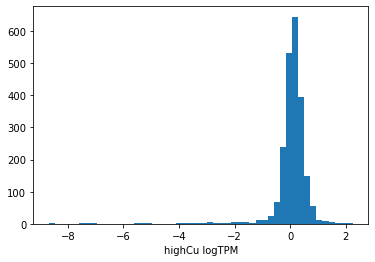

In [5]:
plt.hist(XYdf_og['highCu'],bins=50)
plt.xlabel("highCu logTPM")
plt.show()

In [6]:
XYdf_og[XYdf_og['upstream_region'].str.contains("N")]

og_index      locus_tag  \
2112      4034  EQU24_RS22155   

                                        upstream_region      uMax  \
2112  NNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNN...  0.424743   

      lowO2_fast_growth    lowCH4      MeOH  NoCu     medCu    highCu  ...  \
2112           0.303697 -0.879836 -1.737032   0.0  0.574217  0.743902  ...   

      WithLanthanum  NoLanthanum  LanzaTech    aa3_KO  crotonic_acid  \
2112      -1.594517    -1.543377  -0.605951 -0.528291      -0.482834   

      CH4_500ppm  CH4_1000ppm  gene                    product  type  
2112    -2.07773    -2.524997  rpmH  50S ribosomal protein L34   CDS  

[1 rows x 23 columns]

In [7]:
# remove seq with N's for now
XYdf = XYdf_og[~XYdf_og['upstream_region'].str.contains("N")]
XYdf

og_index      locus_tag  \
0            0  EQU24_RS00005   
1            1  EQU24_RS00010   
2            2  EQU24_RS00015   
3            4  EQU24_RS00035   
4            9  EQU24_RS00060   
...        ...            ...   
2206      4182  EQU24_RS23145   
2207      4184  EQU24_RS23155   
2208      4186  EQU24_RS23165   
2209      4187  EQU24_RS23170   
2210      4188  EQU24_RS23175   

                                        upstream_region      uMax  \
0     ACTGTTAGCTTGGCACGGCCCTTGGCTCTGCGGGCGTTAAGGACTT...  0.333441   
1     GTGGACGCGATCACACCACGGTTATTAATGCTTGTAAACGCATTGC...  0.179318   
2     TTGCGAAGAGGGGCGGTTTCTCGTCCGACAGGCGTCGGCGGCAAGG...  0.364849   
3     GTATAAACCATGAAAGTCAGCCTATTTCGAAGATACCGACACCCTA...  0.193539   
4     GAATTTTCGGGTTCGGGCATCAGCTACCGGGTATCGCCGGTACTCG...  0.173256   
...                                                 ...       ...   
2206  TTCCGAAAATAAATTGATTTCAAGCGATATACGGGTAGTCGGGTTA...  0.620221   
2207  TTCCGAAAATAAATTGATTTCAAGCGATATACGGGTAGTCGGGTTA...  0.609995   
2208  TTGAAACCCTAAGGTACATTGAGGCGTTAGCAAAGAGCAAGTTTGA...  0.605448   
2209  AATCTTCATTAGAGTCGAACGAAGTTTCATGTTTTCGGCTTCCTCA...  0.604488   
2210  GACAACAAATGAACATGATTCGTCATCTGAACGAAAGCGTAAAGCT...  0.191106   

      lowO2_fast_growth    lowCH4      MeOH  NoCu     medCu    highCu  ...  \
0             -0.087509 -0.248330 -0.654293   0.0  0.252788  0.260753  ...   
1             -0.183682 -0.493245 -1.323530   0.0  0.418315  0.611021  ...   
2              0.170159 -0.338861 -0.347147   0.0  0.287824  0.387577  ...   
3              0.035923  0.136026 -0.642058   0.0  0.189394  0.345084  ...   
4              0.283822 -0.740565 -1.011908   0.0  0.215938  0.306791  ...   
...                 ...       ...       ...   ...       ...       ...  ...   
2206           0.718300  0.245892 -1.598809   0.0  0.171579  0.501296  ...   
2207           0.702416  0.231606 -1.614646   0.0  0.154029  0.483579  ...   
2208           0.688065  0.233752 -1.594922   0.0  0.171939  0.486032  ...   
2209           0.196871 -0.261330  0.125607   0.0 -0.014653  0.229101  ...   
2210          -0.064682 -0.560132  0.116334   0.0 -0.067585 -0.349116  ...   

      WithLanthanum  NoLanthanum  LanzaTech    aa3_KO  crotonic_acid  \
0         -0.117634    -0.180709  -0.516711 -0.472602       0.058102   
1         -0.244793    -0.161434   0.237179 -0.079076       0.132689   
2         -0.249011    -0.066333  -0.987336 -0.990306       0.481623   
3          0.643283     0.566397  -0.952383 -0.465515       0.009531   
4          0.539188     0.622656  -0.716034 -0.025042       0.070784   
...             ...          ...        ...       ...            ...   
2206       0.977712     1.564370   0.701928  1.577361       0.777911   
2207       0.952955     1.548383   0.701457  1.573150       0.761210   
2208       0.899683     1.442487   0.708730  1.520411       0.769644   
2209      -0.233161     0.107133   0.265191 -0.870372       0.814080   
2210      -1.215170    -1.821202  -0.326240 -1.481259       0.175490   

      CH4_500ppm  CH4_1000ppm  gene  \
0       0.668619     0.215153  dnaA   
1      -0.462317    -0.490073  dnaN   
2       0.144467    -0.239513  recF   
3       0.367039     0.695145   NaN   
4      -0.367242    -0.319915   NaN   
...          ...          ...   ...   
2206    0.463434     0.727701  hxlA   
2207    0.433925     0.705205  hxlA   
2208    0.032260     0.305817  hxlA   
2209   -0.245552    -0.285502   NaN   
2210   -2.693962    -3.214980   NaN   

                                                product  type  
0        chromosomal replication initiator protein DnaA   CDS  
1                       DNA polymerase III subunit beta   CDS  
2                   DNA replication/repair protein RecF   CDS  
3                                  hypothetical protein   CDS  
4     bifunctional diguanylate cyclase/phosphodieste...   CDS  
...                                                 ...   ...  
2206                    3-hexulose-6-phosphate synthase   CDS

In [12]:
set_reg_class_up_down(XYdf,'score',thresh=5)
XYdf

/home/ubuntu/anaconda3/envs/torchp/lib/python3.7/site-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


og_index      locus_tag  \
0            0  EQU24_RS00005   
1            1  EQU24_RS00010   
2            2  EQU24_RS00015   
3            4  EQU24_RS00035   
4            9  EQU24_RS00060   
...        ...            ...   
2206      4182  EQU24_RS23145   
2207      4184  EQU24_RS23155   
2208      4186  EQU24_RS23165   
2209      4187  EQU24_RS23170   
2210      4188  EQU24_RS23175   

                                        upstream_region      uMax  \
0     ACTGTTAGCTTGGCACGGCCCTTGGCTCTGCGGGCGTTAAGGACTT...  0.333441   
1     GTGGACGCGATCACACCACGGTTATTAATGCTTGTAAACGCATTGC...  0.179318   
2     TTGCGAAGAGGGGCGGTTTCTCGTCCGACAGGCGTCGGCGGCAAGG...  0.364849   
3     GTATAAACCATGAAAGTCAGCCTATTTCGAAGATACCGACACCCTA...  0.193539   
4     GAATTTTCGGGTTCGGGCATCAGCTACCGGGTATCGCCGGTACTCG...  0.173256   
...                                                 ...       ...   
2206  TTCCGAAAATAAATTGATTTCAAGCGATATACGGGTAGTCGGGTTA...  0.620221   
2207  TTCCGAAAATAAATTGATTTCAAGCGATATACGGGTAGTCGGGTTA...  0.609995   
2208  TTGAAACCCTAAGGTACATTGAGGCGTTAGCAAAGAGCAAGTTTGA...  0.605448   
2209  AATCTTCATTAGAGTCGAACGAAGTTTCATGTTTTCGGCTTCCTCA...  0.604488   
2210  GACAACAAATGAACATGATTCGTCATCTGAACGAAAGCGTAAAGCT...  0.191106   

      lowO2_fast_growth    lowCH4      MeOH  NoCu     medCu    highCu  ...  \
0             -0.087509 -0.248330 -0.654293   0.0  0.252788  0.260753  ...   
1             -0.183682 -0.493245 -1.323530   0.0  0.418315  0.611021  ...   
2              0.170159 -0.338861 -0.347147   0.0  0.287824  0.387577  ...   
3              0.035923  0.136026 -0.642058   0.0  0.189394  0.345084  ...   
4              0.283822 -0.740565 -1.011908   0.0  0.215938  0.306791  ...   
...                 ...       ...       ...   ...       ...       ...  ...   
2206           0.718300  0.245892 -1.598809   0.0  0.171579  0.501296  ...   
2207           0.702416  0.231606 -1.614646   0.0  0.154029  0.483579  ...   
2208           0.688065  0.233752 -1.594922   0.0  0.171939  0.486032  ...   
2209           0.196871 -0.261330  0.125607   0.0 -0.014653  0.229101  ...   
2210          -0.064682 -0.560132  0.116334   0.0 -0.067585 -0.349116  ...   

      LanzaTech    aa3_KO  crotonic_acid  CH4_500ppm  CH4_1000ppm  gene  \
0     -0.516711 -0.472602       0.058102    0.668619     0.215153  dnaA   
1      0.237179 -0.079076       0.132689   -0.462317    -0.490073  dnaN   
2     -0.987336 -0.990306       0.481623    0.144467    -0.239513  recF   
3     -0.952383 -0.465515       0.009531    0.367039     0.695145   NaN   
4     -0.716034 -0.025042       0.070784   -0.367242    -0.319915   NaN   
...         ...       ...            ...         ...          ...   ...   
2206   0.701928  1.577361       0.777911    0.463434     0.727701  hxlA   
2207   0.701457  1.573150       0.761210    0.433925     0.705205  hxlA   
2208   0.708730  1.520411       0.769644    0.032260     0.305817  hxlA   
2209   0.265191 -0.870372       0.814080   -0.245552    -0.285502   NaN   
2210  -0.326240 -1.481259       0.175490   -2.693962    -3.214980   NaN   

                                                product  type     score  \
0        chromosomal replication initiator protein DnaA   CDS -0.563333   
1                       DNA polymerase III subunit beta   CDS -0.130000   
2                   DNA replication/repair protein RecF   CDS -0.073333   
3                                  hypothetical protein   CDS  0.220000   
4     bifunctional diguanylate cyclase/phosphodieste...   CDS -0.146667   
...                                                 ...   ...       ...   
2206                    3-hexulose-6-phosphate synthase   CDS  0.383333   
2207                    3-hexulose-6-phosphate synthase   CDS  0.383333   
2208                    3-hexulose-6-phosphate synthase   CDS -0.220000   
2209                                        transposase   CDS -0.236667   
2210  type II toxin-antitoxin system RelE/ParE famil...   CDS  0.103333   

      score_reg_UD  
0                1  

In [13]:
XYdf['score_reg_UD'].value_counts()

1    1953
2     169
0      88
Name: score_reg_UD, dtype: int64

In [14]:
set_reg_class_up_down(XYdf,'highCu',thresh=0.6)
XYdf['highCu_reg_UD'].value_counts()


/home/ubuntu/anaconda3/envs/torchp/lib/python3.7/site-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


1    1957
2     158
0      95
Name: highCu_reg_UD, dtype: int64

In [70]:
def shuffle_seq(dna):
    to_shuffle = list(dna)
    random.shuffle(to_shuffle)
    return  ''.join(to_shuffle)

XYdf['shuffled_seq'] = XYdf['upstream_region'].apply(lambda x: shuffle_seq(x))
XYdf[['upstream_region','shuffled_seq']]

NameError: name 'XYdf' is not defined

In [18]:
XYdf['score_shuff'] = XYdf['shuffled_seq'].apply(lambda x: score_seq(x))
set_reg_class_up_down(XYdf,'score_shuff',thresh=5)
XYdf['score_shuff_reg_UD'].value_counts()


/home/ubuntu/anaconda3/envs/torchp/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/home/ubuntu/anaconda3/envs/torchp/lib/python3.7/site-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


1    1868
2     275
0      67
Name: score_shuff_reg_UD, dtype: int64

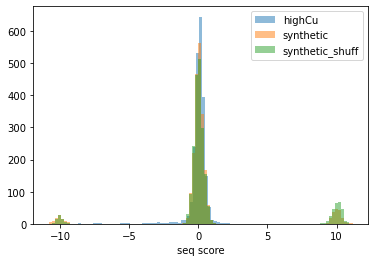

In [19]:
plt.hist(XYdf['highCu'],bins=50,alpha=0.5,label='highCu')
plt.hist(XYdf['score'],bins=100,alpha=0.5,label='synthetic')
plt.hist(XYdf['score_shuff'],bins=100,alpha=0.5,label='synthetic_shuff')
plt.xlabel("seq score")
plt.legend()
plt.show()

In [20]:
from sklearn.model_selection import GroupKFold,GroupShuffleSplit,StratifiedKFold #StratifiedGroupKFold

In [21]:
#skf = StratifiedKFold(n_splits=5)
skf_shuff = StratifiedKFold(n_splits=5)

_____Split 0____


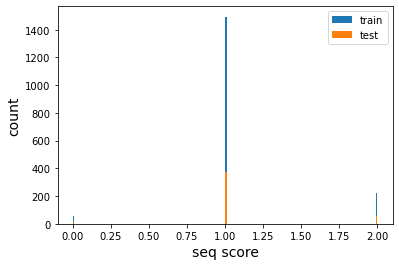

/home/ubuntu/anaconda3/envs/torchp/lib/python3.7/site-packages/ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  del sys.path[0]
/home/ubuntu/anaconda3/envs/torchp/lib/python3.7/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/home/ubuntu/anaconda3/envs/torchp/lib/python3.7/site-packages/ipykernel_launcher.py:29: FutureWarning: This dataframe has a column name that matches the 'value_name' column name of the resulting Dataframe. In the future this

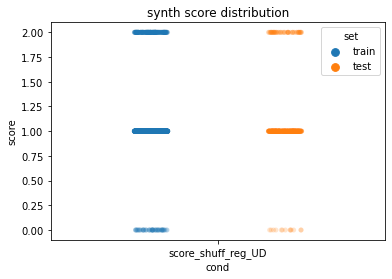

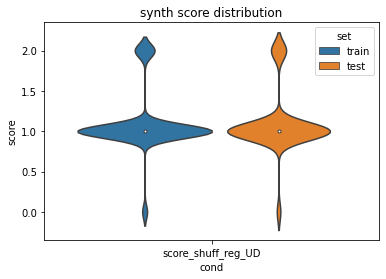

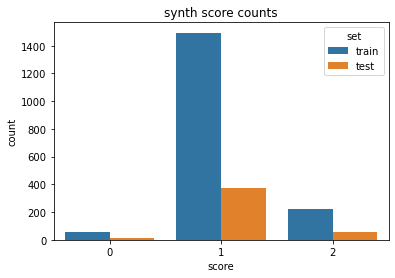


_____Split 1____


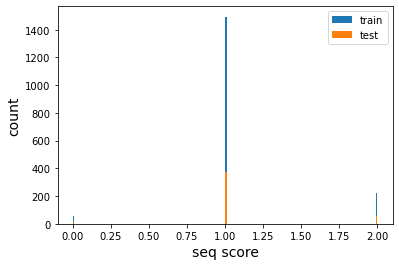

/home/ubuntu/anaconda3/envs/torchp/lib/python3.7/site-packages/ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  del sys.path[0]
/home/ubuntu/anaconda3/envs/torchp/lib/python3.7/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/home/ubuntu/anaconda3/envs/torchp/lib/python3.7/site-packages/ipykernel_launcher.py:29: FutureWarning: This dataframe has a column name that matches the 'value_name' column name of the resulting Dataframe. In the future this

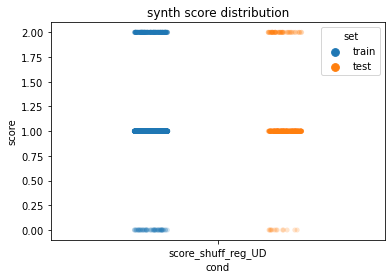

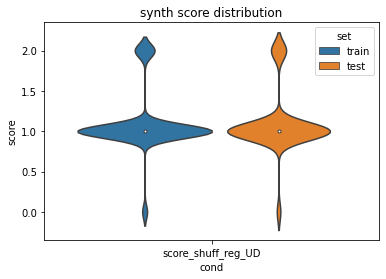

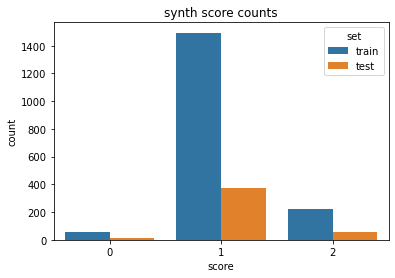


_____Split 2____


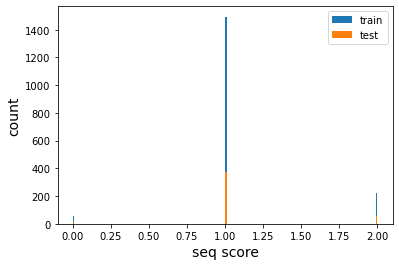

/home/ubuntu/anaconda3/envs/torchp/lib/python3.7/site-packages/ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  del sys.path[0]
/home/ubuntu/anaconda3/envs/torchp/lib/python3.7/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/home/ubuntu/anaconda3/envs/torchp/lib/python3.7/site-packages/ipykernel_launcher.py:29: FutureWarning: This dataframe has a column name that matches the 'value_name' column name of the resulting Dataframe. In the future this

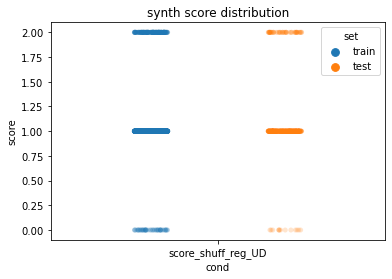

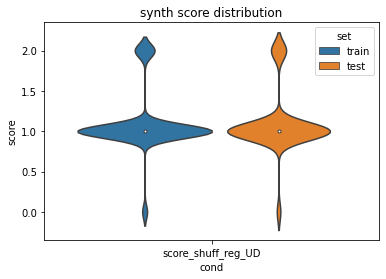

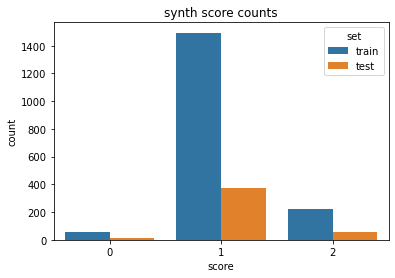


_____Split 3____


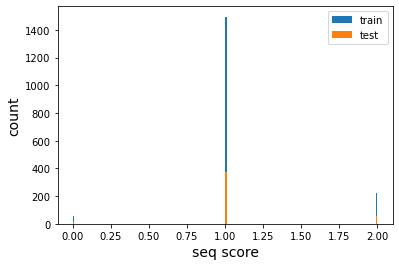

/home/ubuntu/anaconda3/envs/torchp/lib/python3.7/site-packages/ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  del sys.path[0]
/home/ubuntu/anaconda3/envs/torchp/lib/python3.7/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/home/ubuntu/anaconda3/envs/torchp/lib/python3.7/site-packages/ipykernel_launcher.py:29: FutureWarning: This dataframe has a column name that matches the 'value_name' column name of the resulting Dataframe. In the future this

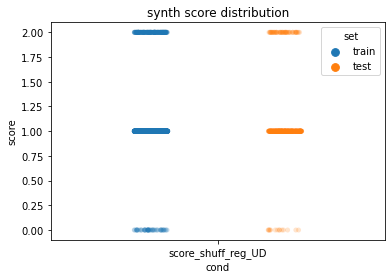

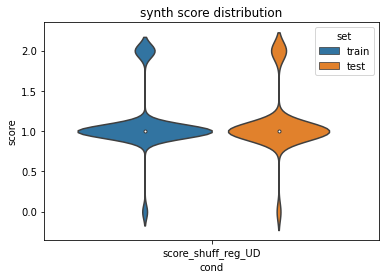

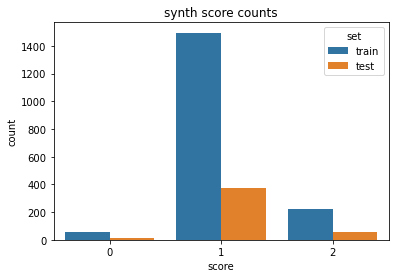


_____Split 4____


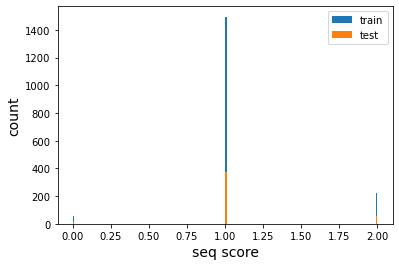

/home/ubuntu/anaconda3/envs/torchp/lib/python3.7/site-packages/ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  del sys.path[0]
/home/ubuntu/anaconda3/envs/torchp/lib/python3.7/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/home/ubuntu/anaconda3/envs/torchp/lib/python3.7/site-packages/ipykernel_launcher.py:29: FutureWarning: This dataframe has a column name that matches the 'value_name' column name of the resulting Dataframe. In the future this

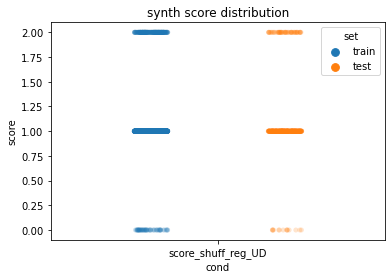

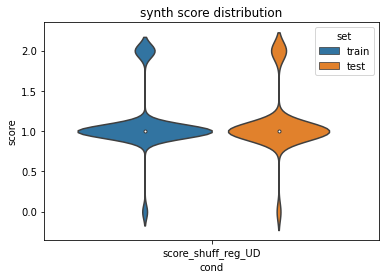

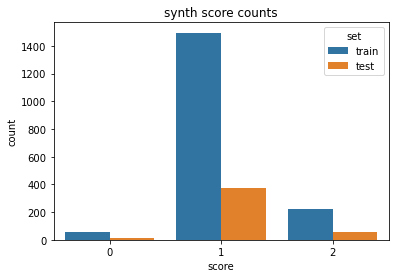

In [22]:
# for i, (train_idxs, test_idxs) in enumerate(skf.split(XYdf, XYdf['score_reg_UD'])):
#     print(f"_____Split {i}____")
#     train_df = XYdf.iloc[train_idxs]
#     test_df = XYdf.iloc[test_idxs]
    
#     score_col = "score_reg_UD"

#     plot_train_test_hist(train_df, test_df,score_col=score_col,bins=200)
#     view_train_test_dist(train_df, test_df,[score_col],"synth score",id_col='locus_tag')
    
#     print("")
    
#     split_dfs = {
#         'train':train_df,
#         'test':test_df
#     }
    
#     train_df.to_csv(f'data/synth_cls_splits/cv{i}_train.tsv',index=False,sep='\t')
#     test_df.to_csv(f'data/synth_cls_splits/cv{i}_test.tsv',index=False,sep='\t')

for i, (train_idxs, test_idxs) in enumerate(skf_shuff.split(XYdf, XYdf['score_shuff_reg_UD'])):
    print(f"_____Split {i}____")
    train_df = XYdf.iloc[train_idxs]
    test_df = XYdf.iloc[test_idxs]
    
    score_col = "score_shuff_reg_UD"

    plot_train_test_hist(train_df, test_df,score_col=score_col,bins=200)
    view_train_test_dist(train_df, test_df,[score_col],"synth score",id_col='locus_tag')
    
    print("")
    
    split_dfs = {
        'train':train_df,
        'test':test_df
    }
    
    train_df.to_csv(f'data/synth_cls_splits/cv{i}_shuff_train.tsv',index=False,sep='\t')
    test_df.to_csv(f'data/synth_cls_splits/cv{i}_shuff_test.tsv',index=False,sep='\t')



In [23]:
test_df['score_reg_UD'].value_counts()

1    402
0     20
2     20
Name: score_reg_UD, dtype: int64

In [24]:
test_df['score_shuff_reg_UD'].value_counts()

1    373
2     55
0     14
Name: score_shuff_reg_UD, dtype: int64

## Load 5G seqs into data loaders

In [22]:
dataset_types = [
    DatasetSpec('ohe'),
#     DatasetSpec('kmer',k=3),
#     DatasetSpec('kmer',k=6),
]

In [23]:
seq_col_name = 'upstream_region'
target_col_name = 'score_reg_UD'

# Dfs for the full train/test split
# final_dls = tu.build_dataloaders_single(
#     full_train_df, 
#     test_df, 
#     dataset_types,
#     seq_col=seq_col_name,
#     target_col=target_col_name
# )

# Dfs from further spliting train into train and val
dls = tu.build_dataloaders_single(
    train_df, 
    test_df, 
    dataset_types,
    seq_col=seq_col_name,
    target_col=target_col_name,
)

# log_kmer6_train_dl,log_kmer6_val_dl = log_dls['kmer_6']
# log_kmer3_train_dl,log_kmer3_val_dl = log_dls['kmer_3']
ohe_train_dl,ohe_val_dl = dls['ohe']

## Run models

In [24]:
def collect_model_stats(model_name,seq_len,encoding,
                        train_dl,val_dl,
                        lr=0.001,ep=1000,pat=100,
                        opt=None,model=None,load_best=False):
    
    if not model:
        model = m.DNA_2CNN_2FC_Multi(
            seq_len,
            3, # num tasks
        )
    model.to(DEVICE)

    #loss_func = torch.nn.MSELoss() 
    loss_func = torch.nn.CrossEntropyLoss()
    
    if opt:
        opt = opt(model.parameters(), lr=lr)

    # pass in
    #train_dl,val_dl = dls[encoding] 
    
    train_losses, \
    val_losses, \
    epoch_stop, \
    best_val_score = tu.run_model(
        train_dl,
        val_dl, 
        model, 
        loss_func, 
        DEVICE,
        lr=lr, 
        epochs=ep, 
        opt=opt,
        patience=pat,
        load_best=load_best # leave false to see overfitting in parity plots
    )

    # to plot loss
    data_label = [((train_losses,val_losses),model_name,epoch_stop,best_val_score)]
    tu.quick_loss_plot(data_label)
    
    return {
        'model_name':model_name,
        'model':model,
        'train_losses':train_losses,
        'val_losses':val_losses,
        'epoch_stop':epoch_stop,
        'best_val_score':best_val_score,
        'data_label':data_label
    }

In [25]:
# def parity_pred_by_split(model_name,
#                          device,
#                          split_dfs,
#                          locus_col='locus_tag',
#                          seq_col='seq',
#                          target_col="score",
#                          splits=['train','val'],
#                          alpha=0.2
#                         ):
#     '''
#     Given a trained model, get the model's predictions on each split
#     of the data and create parity plots of the y predictions vs actual ys
#     '''
#     # init subplots
#     fig, axs = plt.subplots(1,len(splits), sharex=True, sharey=True,figsize=(10,4))
#     pred_dfs = {}
    
#     def parity_plot(model_title,ytrue,ypred,rigid=True):
#         axs[i].scatter(ytrue, ypred, alpha=alpha)

#         r2 = r2_score(ytrue,ypred)
#         pr = pearsonr(ytrue,ypred)[0]
#         sp = spearmanr(ytrue,ypred).correlation

#         # y=x line
#         xpoints = ypoints = plt.xlim()
#         if rigid:
#             axs[i].set_ylim(min(xpoints),max(xpoints)) 
#         axs[i].plot(xpoints, ypoints, linestyle='--', color='k', lw=2, scalex=False, scaley=False)
#         axs[i].set_title(f"{model_title} (r2:{r2:.2f}|p:{pr:.2f}|sp:{sp:.2f})",fontsize=14)
#         axs[i].set_xlabel("Actual Score",fontsize=14)
#         axs[i].set_ylabel("Predicted Score",fontsize=14)
    
#     for i,split in enumerate(splits):
#         print(f"{split} split")
#         df = split_dfs[split]
#         loci = df[locus_col].values
#         seqs = list(df[seq_col].values)        
#         ohe_seqs = torch.stack([torch.tensor(u.one_hot_encode(x)) for x in seqs]).to(device)
#         labels = torch.tensor(list(df[target_col].values)).unsqueeze(1)
    
#     #dfs = {} # key: model name, value: parity_df
    
#         # initialize prediction df with just locus col
#         pred_df = df[[locus_col]]
#         pred_df['truth'] = df[target_col]
#         print(f"Running {model_name}")
        
#         model = model_res[model_name]['model']
#         # ask model to predict on seqs
#         preds = model(ohe_seqs.float()).tolist()
#         # preds is a tensor converted to a list, 
#         # single elements returned as a list, hence x[0]
#         pred_df['pred'] = [x[0] for x in preds]
        
#         # do I want the result dfs? revise if so
#         #dfs[model_name] = pred_df
        
#         # plot stuff
#         ytrue = pred_df['truth'].values
#         ypred = pred_df['pred'].values
        
#         #plt.subplot(len(splits),i+1,1)
#         model_title = split
#         parity_plot(model_title,ytrue,ypred,rigid=True)
        
#         # save predictions
#         pred_dfs[split] = pred_df
    
    
#     plt.suptitle(model_name,fontsize=14)
#     plt.tight_layout()
#     plt.show()
    
#     return pred_dfs

In [26]:
model_res = {}
pred_dfs = {}
seq_len = len(train_df[seq_col_name].values[0])

E:646 | train loss:0.432 | val loss: 0.438:  32%|███▏      | 647/2000 [00:39<01:19, 17.03it/s]

EarlyStopping counter: 50 out of 200


E:696 | train loss:0.432 | val loss: 0.438:  35%|███▍      | 697/2000 [00:42<01:16, 16.97it/s]

EarlyStopping counter: 100 out of 200


E:749 | train loss:0.432 | val loss: 0.438:  37%|███▋      | 749/2000 [00:45<01:13, 16.98it/s]

EarlyStopping counter: 50 out of 200


E:799 | train loss:0.432 | val loss: 0.438:  40%|███▉      | 799/2000 [00:48<01:10, 17.00it/s]

EarlyStopping counter: 100 out of 200


E:849 | train loss:0.432 | val loss: 0.438:  42%|████▏     | 849/2000 [00:51<01:07, 17.07it/s]

EarlyStopping counter: 150 out of 200


E:896 | train loss:0.431 | val loss: 0.438:  45%|████▍     | 896/2000 [00:54<01:07, 16.44it/s]


EarlyStopping counter: 200 out of 200
Early stopping


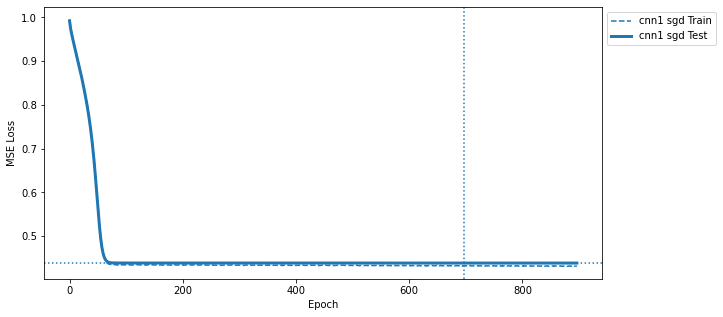

In [27]:
cnn1_name = 'cnn1 sgd'
model_res[cnn1_name] = collect_model_stats(
    cnn1_name,
    seq_len,
    'ohe',
    ohe_train_dl,
    ohe_val_dl,
    lr=0.001,
    ep=2000,
    pat=200,
)

In [34]:
from sklearn.metrics import confusion_matrix,ConfusionMatrixDisplay,classification_report

In [101]:
def get_confusion_stats(model,model_name,seq_list,save_file=False):#seqs,labels,seq_name):
    '''Get class predictions and plot confusion matrix'''

    def plot_confusion_raw_norm(mats):
        f, axes = plt.subplots(len(seq_list), 2, figsize=(9.8, 4.2*len(seq_list)))#, sharey='row')
        #axes = list(axes)
        axes_list = [item for sublist in axes for item in sublist]

        for i,(mat,title) in enumerate(mats):
            disp = ConfusionMatrixDisplay(confusion_matrix=mat)
            disp.plot(ax=axes_list.pop(0))
            #disp.plot(ax=axes.pop(0))
            disp.ax_.set_title(f"{title}")
            disp.im_.colorbar.remove()

        f.suptitle(f"{model_name}",fontsize=20)
        plt.tight_layout()
        if save_file:
            plt.savefig(save_file)

    model.eval()
    print(f"Running {model_name}")
    
    mats = [] # conf matrices
    res_data = [] # classification results

    for seqs, labels, split_name in seq_list:
        ohe_seqs = torch.stack([torch.tensor(u.one_hot_encode(x)) for x in seqs]).to(DEVICE)
        preds = [x.topk(1).indices.item() for x in model(ohe_seqs.float())]#.tolist()        
        
        cls_rep = classification_report(labels, preds,output_dict=True)
        pr = cls_rep['macro avg']['precision']
        re = cls_rep['macro avg']['recall']
        f1 = cls_rep['macro avg']['f1-score']
        sp = cls_rep['macro avg']['support']
        res_data.append([model_name,split_name,pr,re,f1,sp])
        
        c = confusion_matrix(labels, preds)
        mats.append((c,f"raw counts ({split_name})"))
        # get the normalized confusino matrix
        cp = np.zeros(c.shape)
        for i,row in enumerate(c):
            rowsum = sum(row)
            for j,item in enumerate(row):
                val = item/rowsum
                cp[i][j] = val

        mats.append((cp,f"normed counts ({split_name})"))

    plot_confusion_raw_norm(mats)
    
    res_df = pd.DataFrame(res_data,columns=['model_name','split','mac_precision','mac_recall','mac_f1','support'])
    
    
    return res_df

Running cnn1 sgd


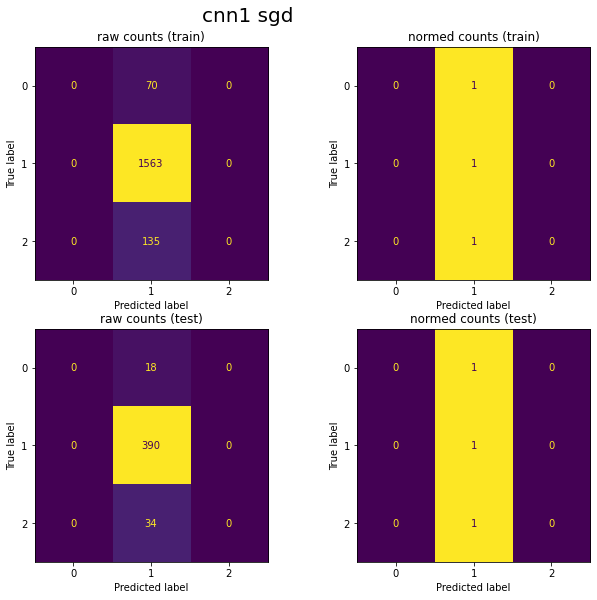

In [102]:
seq_list = [
    (train_df['upstream_region'].values,train_df['score_reg_UD'],"train"),
    (test_df['upstream_region'].values,test_df['score_reg_UD'],"test")
]

rep = get_confusion_stats(
    model_res[cnn1_name]['model'],
    cnn1_name,
    seq_list
)

In [103]:
rep

model_name  split  mac_precision  mac_recall    mac_f1  support
0   cnn1 sgd  train       0.294683    0.333333  0.312819     1768
1   cnn1 sgd   test       0.294118    0.333333  0.312500      442

In [42]:
rep

{'0': {'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 70},
 '1': {'precision': 0.8840497737556561,
  'recall': 1.0,
  'f1-score': 0.9384569198438907,
  'support': 1563},
 '2': {'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 135},
 'accuracy': 0.8840497737556561,
 'macro avg': {'precision': 0.29468325791855204,
  'recall': 0.3333333333333333,
  'f1-score': 0.3128189732812969,
  'support': 1768},
 'weighted avg': {'precision': 0.7815440024774267,
  'recall': 0.8840497737556561,
  'f1-score': 0.8296426276674215,
  'support': 1768}}

Running cnn1 sgd


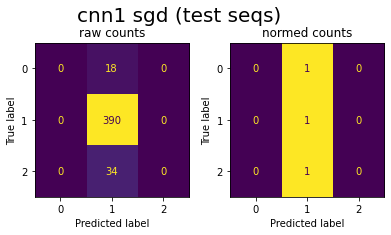

In [31]:
plot_confusion_raw_norm(
    model_res[cnn1_name]['model'],
    cnn1_name,
    test_df['upstream_region'].values,
    test_df['score_reg_UD'],
    "test seqs"
)

In [ ]:
cls_rep = classification_report(ys, y_preds,target_names=imods,output_dict=True)

E:131 | train loss:0.001 | val loss: 1.918:   3%|▎         | 132/5000 [00:08<05:06, 15.90it/s]

EarlyStopping counter: 125 out of 500


E:256 | train loss:0.001 | val loss: 2.038:   5%|▌         | 256/5000 [00:16<04:57, 15.92it/s]

EarlyStopping counter: 250 out of 500


E:381 | train loss:0.000 | val loss: 2.459:   8%|▊         | 382/5000 [00:24<04:49, 15.96it/s]

EarlyStopping counter: 375 out of 500


E:503 | train loss:0.000 | val loss: 2.677:  10%|█         | 503/5000 [00:31<04:43, 15.86it/s]


EarlyStopping counter: 500 out of 500
Early stopping


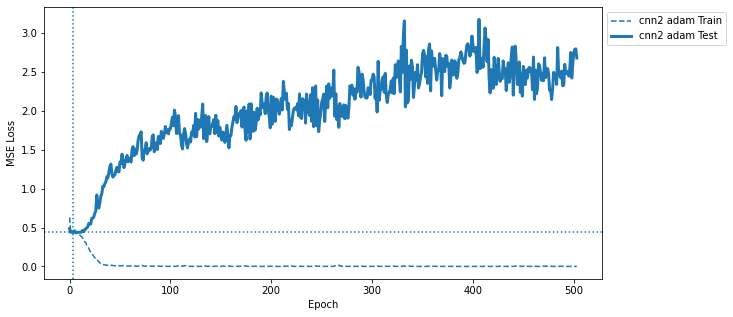

In [104]:
cnn2_name = 'cnn2 adam'
model_res[cnn2_name] = collect_model_stats(
    cnn2_name,
    seq_len,
    'ohe',
    ohe_train_dl,
    ohe_val_dl,
    lr=0.001,
    ep=5000,
    pat=500,
    opt=torch.optim.Adam
)

Running cnn2 adam
Running cnn2 adam


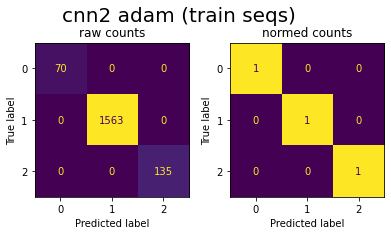

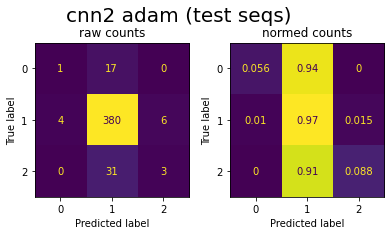

In [105]:
plot_confusion_raw_norm(
    model_res[cnn2_name]['model'],
    cnn2_name,
    train_df['upstream_region'].values,
    train_df['score_reg_UD'],
    "train seqs"
)

plot_confusion_raw_norm(
    model_res[cnn2_name]['model'],
    cnn2_name,
    test_df['upstream_region'].values,
    test_df['score_reg_UD'],
    "test seqs"
)

E:159 | train loss:0.258 | val loss: 0.540:   3%|▎         | 160/5000 [00:10<05:02, 16.02it/s]

EarlyStopping counter: 125 out of 500


E:284 | train loss:0.088 | val loss: 0.859:   6%|▌         | 284/5000 [00:17<04:52, 16.12it/s]

EarlyStopping counter: 250 out of 500


E:409 | train loss:0.019 | val loss: 1.210:   8%|▊         | 410/5000 [00:25<04:47, 15.96it/s]

EarlyStopping counter: 375 out of 500


E:531 | train loss:0.006 | val loss: 1.362:  11%|█         | 531/5000 [00:33<04:40, 15.91it/s]


EarlyStopping counter: 500 out of 500
Early stopping


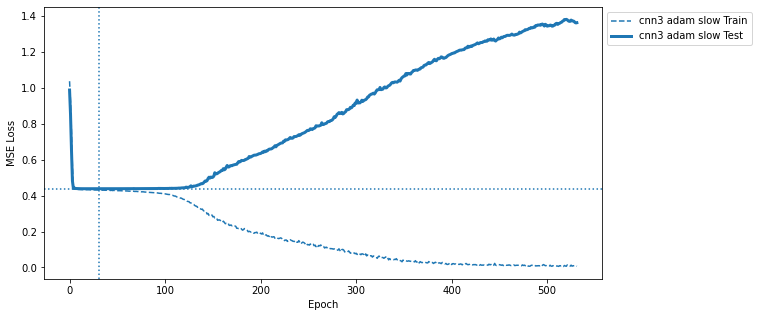

In [106]:
cnn3_name = 'cnn3 adam slow'
model_res[cnn3_name] = collect_model_stats(
    cnn3_name,
    seq_len,
    'ohe',
    ohe_train_dl,
    ohe_val_dl,
    lr=0.0001,
    ep=5000,
    pat=500,
    opt=torch.optim.Adam
)



Running cnn3 adam slow
Running cnn3 adam slow


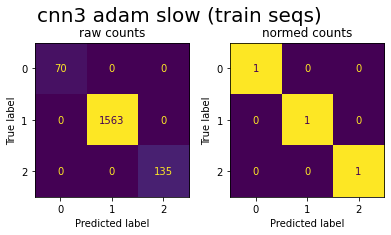

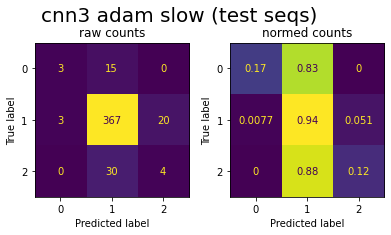

In [107]:
plot_confusion_raw_norm(
    model_res[cnn3_name]['model'],
    cnn3_name,
    train_df['upstream_region'].values,
    train_df['score_reg_UD'],
    "train seqs"
)

plot_confusion_raw_norm(
    model_res[cnn3_name]['model'],
    cnn3_name,
    test_df['upstream_region'].values,
    test_df['score_reg_UD'],
    "test seqs"
)

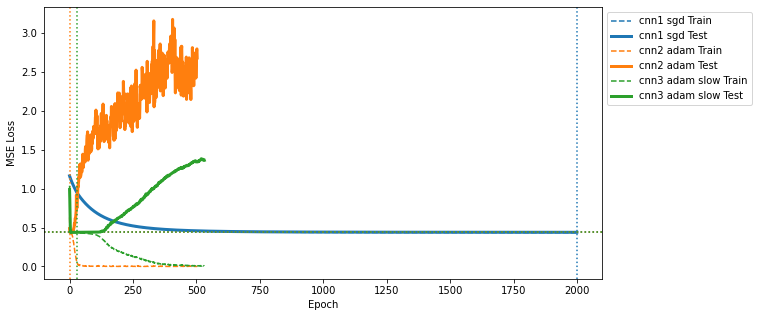

In [108]:
tu.quick_loss_plot([model_res[x]['data_label'][0] for x in model_res])

In [109]:
def augment_mutate(df,n,seq_col='upstream_region',mutation_rate=0.03):
    '''
    Given a dataframe of training data, augment it by adding 
    mutated versions back into the data frame
    '''
    mutation_dict = {
        'A':['C','G','T'],
        'C':['G','T','A'],
        'G':['T','A','C'],
        'T':['A','C','G']
    }
    new_rows = []
    # for each row in the original df
    for i,row in df.iterrows():
        seq = row[seq_col]
                
        # generate n mutants
        for j in range(n):
            new_row = copy.deepcopy(row)
            new_seq = list(seq)
            mutate_vec = [random.random() for x in range(len(seq))]
            
            # loop through mutation values along length of the seq
            for k in range(len(seq)):
                # if random value is below mutation rate, then make a change
                if mutate_vec[k] < mutation_rate:
                    cur_base = seq[k]
                    # select new base randomly
                    new_base = random.choice(mutation_dict[cur_base])
                    new_seq[k] = new_base
            
            new_row[seq_col] = ''.join(new_seq)
            new_row['seq_version'] = j+1
            new_rows.append(new_row.values)

    # put new rows into a df
    new_rows = pd.DataFrame(new_rows,columns=new_row.index)
    # add version to og df 
    df['seq_version'] = 0
    
    return pd.concat([df,new_rows])

In [110]:
aug_train_df = augment_mutate(train_df,10)
aug_train_df

/home/ubuntu/anaconda3/envs/torchp/lib/python3.7/site-packages/ipykernel_launcher.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


og_index      locus_tag  \
0             0  EQU24_RS00005   
1             1  EQU24_RS00010   
2             2  EQU24_RS00015   
3             4  EQU24_RS00035   
4             9  EQU24_RS00060   
...         ...            ...   
17675      3540  EQU24_RS19410   
17676      3540  EQU24_RS19410   
17677      3540  EQU24_RS19410   
17678      3540  EQU24_RS19410   
17679      3540  EQU24_RS19410   

                                         upstream_region      uMax  \
0      ACTGTTAGCTTGGCACGGCCCTTGGCTCTGCGGGCGTTAAGGACTT...  0.333441   
1      GTGGACGCGATCACACCACGGTTATTAATGCTTGTAAACGCATTGC...  0.179318   
2      TTGCGAAGAGGGGCGGTTTCTCGTCCGACAGGCGTCGGCGGCAAGG...  0.364849   
3      GTATAAACCATGAAAGTCAGCCTATTTCGAAGATACCGACACCCTA...  0.193539   
4      GAATTTTCGGGTTCGGGCATCAGCTACCGGGTATCGCCGGTACTCG...  0.173256   
...                                                  ...       ...   
17675  TGGGCAAAAAACTTTCCGAGTTTGATTTCGACGGCGTGACGGTTTC...  1.183261   
17676  TAGGCAAAAAACTTTCCGAGTTTGCTTTCGACGGCGTGAAGGTTTC...  1.183261   
17677  TCGGCAAAAAGCTTTCCGAGTTTGCTTTCGACGGAGTGACGGTTTC...  1.183261   
17678  TCGGCAAAAAACTTTCCGAGTTGGCTTTCGACGGCGTGACGGTTTC...  1.183261   
17679  TCGGCAAAAAACTTTCCGAGTTTGCTTTCGACGGCGTGACGGTTTC...  1.183261   

       lowO2_fast_growth    lowCH4      MeOH  NoCu     medCu    highCu  ...  \
0              -0.087509 -0.248330 -0.654293   0.0  0.252788  0.260753  ...   
1              -0.183682 -0.493245 -1.323530   0.0  0.418315  0.611021  ...   
2               0.170159 -0.338861 -0.347147   0.0  0.287824  0.387577  ...   
3               0.035923  0.136026 -0.642058   0.0  0.189394  0.345084  ...   
4               0.283822 -0.740565 -1.011908   0.0  0.215938  0.306791  ...   
...                  ...       ...       ...   ...       ...       ...  ...   
17675           0.831256 -0.068947 -0.483096   0.0  0.548920  0.766772  ...   
17676           0.831256 -0.068947 -0.483096   0.0  0.548920  0.766772  ...   
17677           0.831256 -0.068947 -0.483096   0.0  0.548920  0.766772  ...   
17678           0.831256 -0.068947 -0.483096   0.0  0.548920  0.766772  ...   
17679           0.831256 -0.068947 -0.483096   0.0  0.548920  0.766772  ...   

       CH4_500ppm  CH4_1000ppm  gene  \
0        0.668619     0.215153  dnaA   
1       -0.462317    -0.490073  dnaN   
2        0.144467    -0.239513  recF   
3        0.367039     0.695145   NaN   
4       -0.367242    -0.319915   NaN   
...           ...          ...   ...   
17675   -1.166172    -1.015641   tgt   
17676   -1.166172    -1.015641   tgt   
17677   -1.166172    -1.015641   tgt   
17678   -1.166172    -1.015641   tgt   
17679   -1.166172    -1.015641   tgt   

                                                 product  type      score  \
0         chromosomal replication initiator protein DnaA   CDS  -0.563333   
1                        DNA polymerase III subunit beta   CDS  -0.130000   
2                    DNA replication/repair protein RecF   CDS  -0.073333   
3                                   hypothetical protein   CDS   0.220000   
4      bifunctional diguanylate cyclase/phosphodieste...   CDS  -0.146667   
...                                                  ...   ...        ...   
17675            tRNA guanosine(34) transglycosylase Tgt   CDS -10.576667   
17676            tRNA guanosine(34) transglycosylase Tgt   CDS -10.576667   
17677            tRNA guanosine(34) transglycosylase Tgt   CDS -10.576667   
17678            tRNA guanosine(34) transglycosylase Tgt   CDS -10.576667   
17679            tRNA guanosine(34) transglycosylase Tgt   CDS -10.576667   

       score_reg_UD  highCu_reg_UD    set  seq_version  
0                 1              1  train            0  
1                 1              2  train            0  
2                 1              1  train            0  
3                 1              1  train            0  
4                 1              1  train            0  
...             ...            ...    ...          ...  
176

In [111]:
aug_dls = tu.build_dataloaders_single(
    aug_train_df, 
    test_df, 
    dataset_types,
    seq_col=seq_col_name,
    target_col=target_col_name,
)

aug_ohe_train_dl,aug_ohe_val_dl = aug_dls['ohe']

In [113]:
target_col_name

'score_reg_UD'

E:129 | train loss:0.081 | val loss: 1.646:   3%|▎         | 130/5000 [01:17<48:41,  1.67it/s]

EarlyStopping counter: 125 out of 500


E:254 | train loss:0.000 | val loss: 2.114:   5%|▌         | 255/5000 [02:33<47:55,  1.65it/s]

EarlyStopping counter: 250 out of 500


E:379 | train loss:0.000 | val loss: 2.327:   8%|▊         | 380/5000 [03:49<46:44,  1.65it/s]

EarlyStopping counter: 375 out of 500


E:504 | train loss:0.000 | val loss: 2.334:  10%|█         | 504/5000 [05:04<45:20,  1.65it/s]

EarlyStopping counter: 500 out of 500
Early stopping


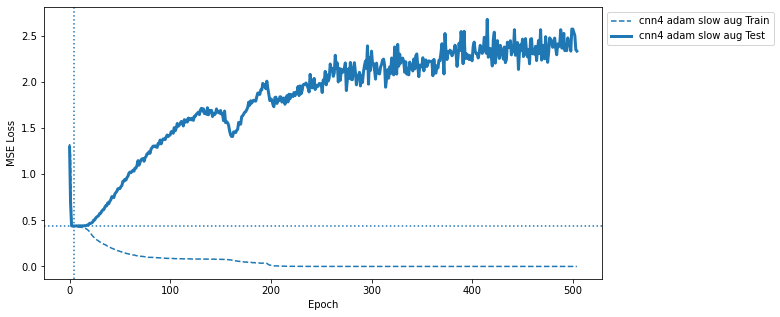

Running cnn4 adam slow aug
Running cnn4 adam slow aug


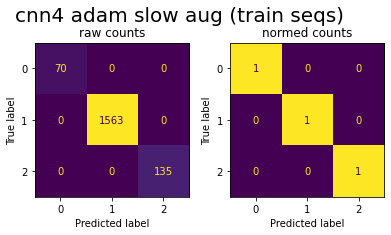

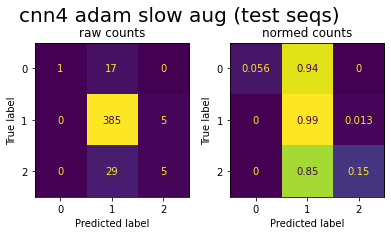

In [114]:
cnn4_name = 'cnn4 adam slow aug'
model_res[cnn4_name] = collect_model_stats(
    cnn4_name,
    seq_len,
    'ohe',
    aug_ohe_train_dl,
    aug_ohe_val_dl,
    lr=0.0001,
    ep=5000,
    pat=500,
    opt=torch.optim.Adam
)

plot_confusion_raw_norm(
    model_res[cnn4_name]['model'],
    cnn4_name,
    train_df['upstream_region'].values,
    train_df['score_reg_UD'],
    "train seqs"
)

plot_confusion_raw_norm(
    model_res[cnn4_name]['model'],
    cnn4_name,
    test_df['upstream_region'].values,
    test_df['score_reg_UD'],
    "test seqs"
)

In [38]:
target_col_name

'score'

E:127 | train loss:0.064 | val loss: 0.759:   3%|▎         | 128/5000 [01:31<57:45,  1.41it/s]

EarlyStopping counter: 125 out of 500


E:252 | train loss:0.028 | val loss: 1.000:   5%|▌         | 253/5000 [03:00<56:12,  1.41it/s]

EarlyStopping counter: 250 out of 500


E:377 | train loss:0.023 | val loss: 1.087:   8%|▊         | 378/5000 [04:29<55:02,  1.40it/s]

EarlyStopping counter: 375 out of 500


E:502 | train loss:0.017 | val loss: 1.128:  10%|█         | 502/5000 [05:58<53:34,  1.40it/s]

EarlyStopping counter: 500 out of 500
Early stopping


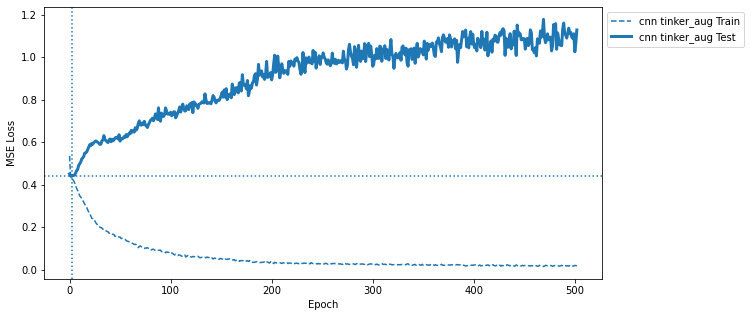

Running cnn tinker_aug
Running cnn tinker_aug


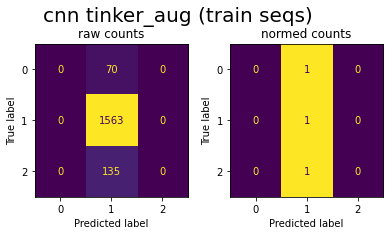

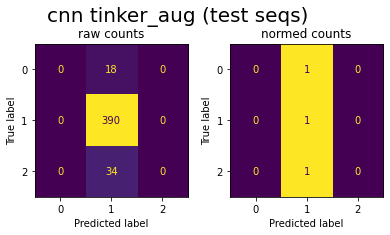

In [115]:
cnn_tinker = 'cnn tinker_aug'
model = m.DNA_2CNN_2FC_Multi(
    seq_len,
    3, # num tasks
    num_filters1=8,
    num_filters2=8,
    kernel_size1=6,
    kernel_size2=6,
    conv_pool_size1=2,
    fc_node_num1=10,
    fc_node_num2=10,
    dropout1=0.25
)

model_res[cnn_tinker] = collect_model_stats(
    cnn_tinker,
    seq_len,
    'ohe',
    aug_ohe_train_dl,
    aug_ohe_val_dl,
    lr=0.0005,
    ep=5000,
    pat=500,
    opt=torch.optim.Adam,
    model=model,
    load_best=True
)

plot_confusion_raw_norm(
    model_res[cnn_tinker]['model'],
    cnn_tinker,
    train_df['upstream_region'].values,
    train_df['score_reg_UD'],
    "train seqs"
)

plot_confusion_raw_norm(
    model_res[cnn_tinker]['model'],
    cnn_tinker,
    test_df['upstream_region'].values,
    test_df['score_reg_UD'],
    "test seqs"
)

In [118]:
cnn_tinker2 = 'cnn tinker2_aug'
model = m.DNA_2CNN_2FC_Multi(
    seq_len,
    3, # num tasks
    num_filters1=8,
    num_filters2=4,
    kernel_size1=10,
    kernel_size2=6,
    conv_pool_size1=2,
    fc_node_num1=5,
    fc_node_num2=5,
    dropout1=0.25
)

model_res[cnn_tinker2] = collect_model_stats(
    cnn_tinker2,
    seq_len,
    'ohe',
    aug_ohe_train_dl,
    aug_ohe_val_dl,
    lr=0.0005,
    ep=5000,
    pat=1000,
    opt=torch.optim.Adam,
    model=model,
    load_best=True
)

plot_confusion_raw_norm(
    model_res[cnn_tinker2]['model'],
    cnn_tinker2,
    train_df['upstream_region'].values,
    train_df['score_reg_UD'],
    "train seqs"
)

plot_confusion_raw_norm(
    model_res[cnn_tinker2]['model'],
    cnn_tinker2,
    test_df['upstream_region'].values,
    test_df['score_reg_UD'],
    "test seqs"
)

RuntimeError: CUDA error: device-side assert triggered

E:377 | train loss:6.326 | val loss: 10.881:   8%|▊         | 378/5000 [03:32<43:06,  1.79it/s] 

EarlyStopping counter: 250 out of 1000


E:1220 | train loss:3.495 | val loss: 7.738:  24%|██▍       | 1221/5000 [11:25<35:22,  1.78it/s]

EarlyStopping counter: 250 out of 1000


E:1720 | train loss:3.090 | val loss: 7.756:  34%|███▍      | 1721/5000 [16:06<30:39,  1.78it/s]

EarlyStopping counter: 750 out of 1000


E:1970 | train loss:3.077 | val loss: 7.796:  39%|███▉      | 1970/5000 [18:27<28:22,  1.78it/s]

EarlyStopping counter: 1000 out of 1000
Early stopping


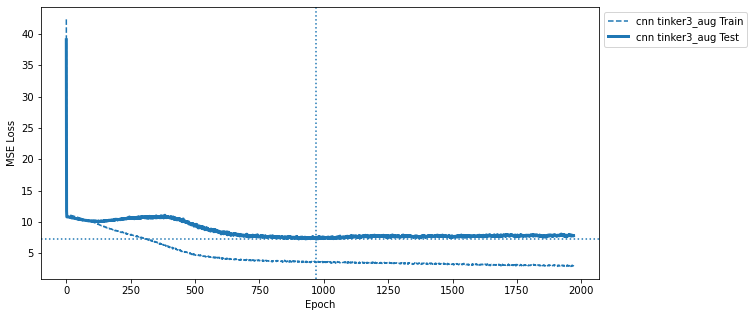

train split


/home/ubuntu/anaconda3/envs/torchp/lib/python3.7/site-packages/ipykernel_launcher.py:46: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/home/ubuntu/anaconda3/envs/torchp/lib/python3.7/site-packages/ipykernel_launcher.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/home/ubuntu/anaconda3/envs/torchp/lib/python3.7/site-packages/ipykernel_launcher.py:46: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the 

Running cnn tinker3_aug
val split
Running cnn tinker3_aug
test split


/home/ubuntu/anaconda3/envs/torchp/lib/python3.7/site-packages/ipykernel_launcher.py:46: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/home/ubuntu/anaconda3/envs/torchp/lib/python3.7/site-packages/ipykernel_launcher.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Running cnn tinker3_aug


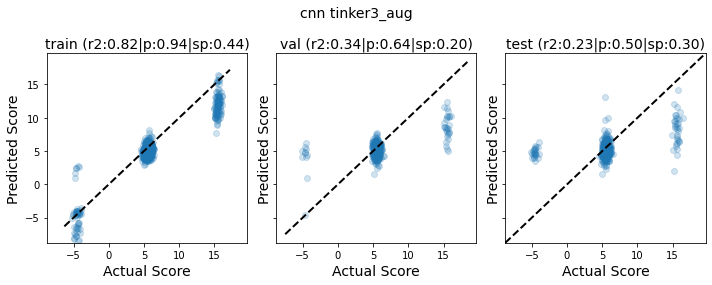

In [46]:
cnn_tinker3 = 'cnn tinker3_aug'
model = m.DNA_2CNN_2FC_Multi(
    seq_len,
    1, # num tasks
    num_filters1=8,
    num_filters2=4,
    kernel_size1=10,
    kernel_size2=6,
    conv_pool_size1=2,
    fc_node_num1=5,
    fc_node_num2=5,
    dropout1=0.25
)

model_res[cnn_tinker3] = collect_model_stats(
    cnn_tinker3,
    seq_len,
    'ohe',
    aug_ohe_train_dl,
    aug_ohe_val_dl,
    lr=0.0001,
    ep=5000,
    pat=1000,
    opt=torch.optim.Adam,
    model=model,
    load_best=True
)

pred_dfs[cnn_tinker3] = parity_pred_by_split(cnn_tinker3,
                     DEVICE,
                     split_dfs,
                     locus_col='locus_tag',
                     seq_col=seq_col_name,
                     target_col=target_col_name,
                     splits=['train','val','test']
                    )

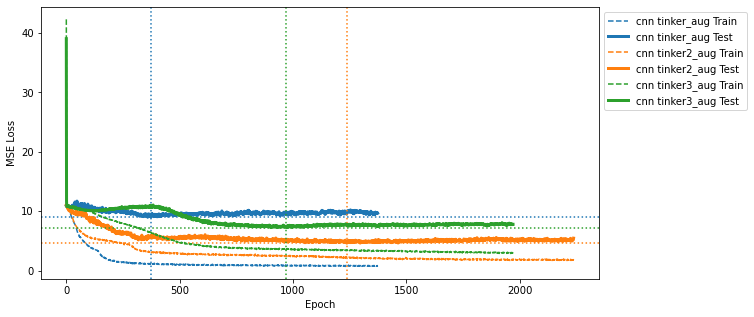

In [48]:
tu.quick_loss_plot([model_res[x]['data_label'][0] for x in [cnn_tinker,cnn_tinker2, cnn_tinker3]])